# Import

In [132]:
import pycpt
import packaging
min_version = '2.6.1'
assert packaging.version.parse(pycpt.__version__) >= packaging.version.parse(min_version), f'This notebook requires version {min_version} or higher of the pycpt library, but you have version {pycpt.__version__}. Please close the notebook, update your environment, and load the notebook again. See https://iri-pycpt.github.io/installation/'

import cptdl as dl 
from cptextras import get_colors_bars
import datetime as dt
import numpy as np
from pathlib import Path
import xarray as xr
import cptcore as cc
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
import scipy as sp
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
import itertools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression


# TODO


- mask only for fcast
- perfect prog vs MOS 
- CCA fcast -30 to 30, 0 to 360 SST 
- repeat all detrended

# Load

In [87]:
spi03 = xr.open_dataset('data/spi03.nc')
#change time format to MM-YYYY
spi03['time'] = pd.to_datetime(spi03.time.values).strftime('%m-%Y')
#rename dims to T, X, Y
spi03 = spi03.rename({'time':'T', 'latitude':'Y', 'longitude':'X'})
#change T format to MM-YYYY
spi03['T'] = pd.to_datetime(spi03.T.values).strftime('%m-%Y')
spi03['T'] = pd.to_datetime(spi03.T.values)
#keep only since 01-79
#spi03 = spi03.sel(T=slice('01-1979', None))
#count number of infinite values 
np.sum(np.isinf(spi03['spi'].values))
#replace values aboe 1e10 with 10
print(np.sum(np.isinf(spi03['spi'].values)))
#spi03['spi'] = xr.where(spi03['spi']>1e10, 10, spi03['spi'])
#print dates where spi is infinite

spi03 = spi03.sel(X=slice(32, 60))



C:\Users\emile\AppData\Local\Temp\ipykernel_12856\1532977346.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  spi03['T'] = pd.to_datetime(spi03.T.values).strftime('%m-%Y')
C:\Users\emile\AppData\Local\Temp\ipykernel_12856\1532977346.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  spi03['T'] = pd.to_datetime(spi03.T.values)


0


In [88]:
spei03 = xr.open_dataset('data/spei03.nc')
#change time format to MM-YYYY
spei03['time'] = pd.to_datetime(spei03.time.values).strftime('%m-%Y')
#rename dims to T, X, Y
spei03 = spei03.rename({'time':'T', 'latitude':'Y', 'longitude':'X'})
#change T format to MM-YYYY
spei03['T'] = pd.to_datetime(spei03.T.values).strftime('%m-%Y')
spei03['T'] = pd.to_datetime(spei03.T.values)
#keep only since 01-79
#spei03 = spei03.sel(T=slice('01-1979', None))
#count number of infinite values 
np.sum(np.isinf(spei03['spei'].values))
#replace values aboe 1e10 with 10
print(np.sum(np.isinf(spei03['spei'].values)))
#spei03['spei'] = xr.where(spei03['spei']>1e10, 10, spei03['spei'])
#print dates where spei is infinite

spei03 = spei03.sel(X=slice(32, 60))

C:\Users\emile\AppData\Local\Temp\ipykernel_12856\280398115.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  spei03['T'] = pd.to_datetime(spei03.T.values).strftime('%m-%Y')
C:\Users\emile\AppData\Local\Temp\ipykernel_12856\280398115.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  spei03['T'] = pd.to_datetime(spei03.T.values)


0


In [89]:
cams03 = xr.open_dataset('data/cams03.nc', decode_times=False)
reference_time = pd.Timestamp('1960-01-01')
# Apply the conversion to each time value in 'T'
cams03['T'] = xr.DataArray([reference_time + relativedelta(months=int(month)) for month in cams03['T'].values])
# Format the time as month-year (MM-YYYY)
cams03['T'] = cams03['T'].dt.strftime('%m-%Y')
cams03['T'] = pd.to_datetime(cams03['T'])
np.sum(np.isinf(cams03['SPI-CAMSOPI_3-Month'].values))
cams03 = cams03.sel(X=slice(32, 60))


C:\Users\emile\AppData\Local\Temp\ipykernel_12856\1890053190.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cams03['T'] = pd.to_datetime(cams03['T'])


In [90]:
opi = xr.open_dataset('data/opi.nc', decode_times=False)
# Apply the conversion to each time value in 'T'
opi['T'] = xr.DataArray([reference_time + relativedelta(months=int(month)) for month in opi['T'].values])
# Format the time as month-year (MM-YYYY)

opi['T'] = opi['T'].dt.strftime('%m-%Y')
opi['T'] = pd.to_datetime(opi['T'])
#rename dim_0 to T
#opi = opi.swap_dims({'dim_0':'T'})

opi = opi.sel(X=slice(32, 60))


C:\Users\emile\AppData\Local\Temp\ipykernel_12856\2605572955.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  opi['T'] = pd.to_datetime(opi['T'])


In [91]:
era5 = xr.open_dataset('data/era5.nc', decode_times=False)
#time is YYYMMDD change ot datetime
# Convert to pandas datetime using the correct format
date_times = pd.to_datetime(era5.date.values.astype(str), format='%Y%m%d')
# Assign the datetime values back to the DataArray if needed
era5 = era5.swap_dims({'date':'T', 'longitude':'X', 'latitude':'Y'})
era5 = era5.assign_coords(T=date_times, X = era5.longitude, Y = era5.latitude)
#remove coordinate date
era5 = era5.drop(['date','latitude', 'longitude', 'expver','number'])


#era5 = era5.sel(T=slice('1979-01-01', '2024-08-01'))

era5['tp'] = era5['tp']*1000*30

era5['tp3m'] = era5['tp'] + era5['tp'].shift(T=1) + era5['tp'].shift(T=2)

C:\Users\emile\AppData\Local\Temp\ipykernel_12856\1644435322.py:9: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  era5 = era5.drop(['date','latitude', 'longitude', 'expver','number'])


In [92]:
custom_spi = xr.open_dataset('data/custom_spi_mask_pearson3_3m.nc', decode_times=True)

# Merge

In [93]:
#merge spi03 and cams01
spi03_cams01 = spi03.merge(cams03)
#merge spi03_cams01 and opi
data = spi03_cams01.merge(opi)
data = data.merge(spei03) 

data = data.merge(era5)
data = data.merge(custom_spi)

data = data.sel(T=slice('01-1951', '08-2024'))


In [94]:
#rename data variables and transpose dims to T, X, Y
data = data.rename({'spi':'KAUST_SPI', 'SPI-CAMSOPI_3-Month':'CAMS_SPI', 'aprod':'CAMS_precip','__xarray_dataarray_variable__':'custom_SPI', 'tp3m':'KAUST_precip',
                    'spei':'KAUST_SPEI'})
data['KAUST_SPI'] = data['KAUST_SPI'].transpose('T', 'Y', 'X')
data['CAMS_SPI'] = data['CAMS_SPI'].transpose('T', 'Y', 'X')
data['CAMS_precip'] = data['CAMS_precip'].transpose('T', 'Y', 'X')
data['KAUST_precip'] = data['KAUST_precip'].transpose('T', 'Y', 'X')
data['KAUST-SPEI'] = data['KAUST_SPEI'].transpose('T', 'Y', 'X')

data['custom_SPI'] = xr.where(data['custom_SPI']>1e10, 3, data['custom_SPI'])
data['KAUST_SPI'] = xr.where(data['KAUST_SPI']>1e10, 3, data['KAUST_SPI'])

In [95]:
data 

<xarray.Dataset> Size: 363MB
Dimensions:       (T: 884, Y: 101, X: 113)
Coordinates:
  * T             (T) datetime64[ns] 7kB 1951-01-01 1951-02-01 ... 2024-08-01
  * Y             (Y) float64 808B 12.0 12.25 12.5 12.75 ... 36.5 36.75 37.0
  * X             (X) float32 452B 32.0 32.25 32.5 32.75 ... 59.5 59.75 60.0
Data variables:
    KAUST_SPI     (T, Y, X) float32 40MB nan nan nan ... 0.5404 0.5271 -0.2428
    CAMS_SPI      (T, Y, X) float32 40MB nan nan nan nan nan ... nan nan nan nan
    CAMS_precip   (T, Y, X) float32 40MB nan nan nan ... -0.1653 -0.1656 -0.1658
    KAUST_SPEI    (T, Y, X) float32 40MB nan nan nan ... 0.486 0.4567 -0.6243
    tp            (T, Y, X) float32 40MB 0.0 0.0 0.0 0.0 ... 3.605 1.259 0.4005
    KAUST_precip  (T, Y, X) float32 40MB 9.098 7.095 4.12 ... 57.22 50.3 0.9155
    custom_SPI    (T, Y, X) float64 81MB nan nan nan nan ... 0.5767 0.5654 nan
    KAUST-SPEI    (T, Y, X) float32 40MB nan nan nan ... 0.486 0.4567 -0.6243

# Spatial smoothing

In [96]:
#spatial smoothing for custom SPI
smooth = False
if smooth:
    for i in range(len(data['T'])):
        data['custom_SPI'][i] = sp.ndimage.filters.gaussian_filter(data['custom_SPI'][i], sigma=[1,1], mode='constant')



In [97]:
mask = data.KAUST_SPI.isnull()
#apply mask to other data variables
data['CAMS_SPI'] = data.CAMS_SPI.where(~mask)
data['CAMS_precip'] = data.CAMS_precip.where(~mask)
data['KAUST_precip'] = data.KAUST_precip.where(~mask)
data['custom_SPI'] = data.custom_SPI.where(~mask)
data['KAUST_SPEI'] = data.KAUST_SPEI.where(~mask)

# Compute ERA5 anomaly

In [98]:
array_list = []
for month in range(1, 13):
    reference_period = data['KAUST_precip'].sel(T=data['T.month']==month).sel(T=slice('1991-01-01', '2020-12-01'))
    data_month = data['KAUST_precip'].sel(T=data['T.month']==month)
    data_month = (data_month - reference_period.mean(dim='T') )  / (reference_period.std(dim='T') + 1e-10)
    array_list.append(data_month)
era5_anomalies = xr.concat(array_list, dim='T')
  

In [99]:
data['KAUST_precip_anomalies'] = era5_anomalies

# Climatologies 

C:\Users\emile\AppData\Local\Temp\ipykernel_12856\1013926472.py:16: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  first_plot = g.axes.flat[0].collections[0]


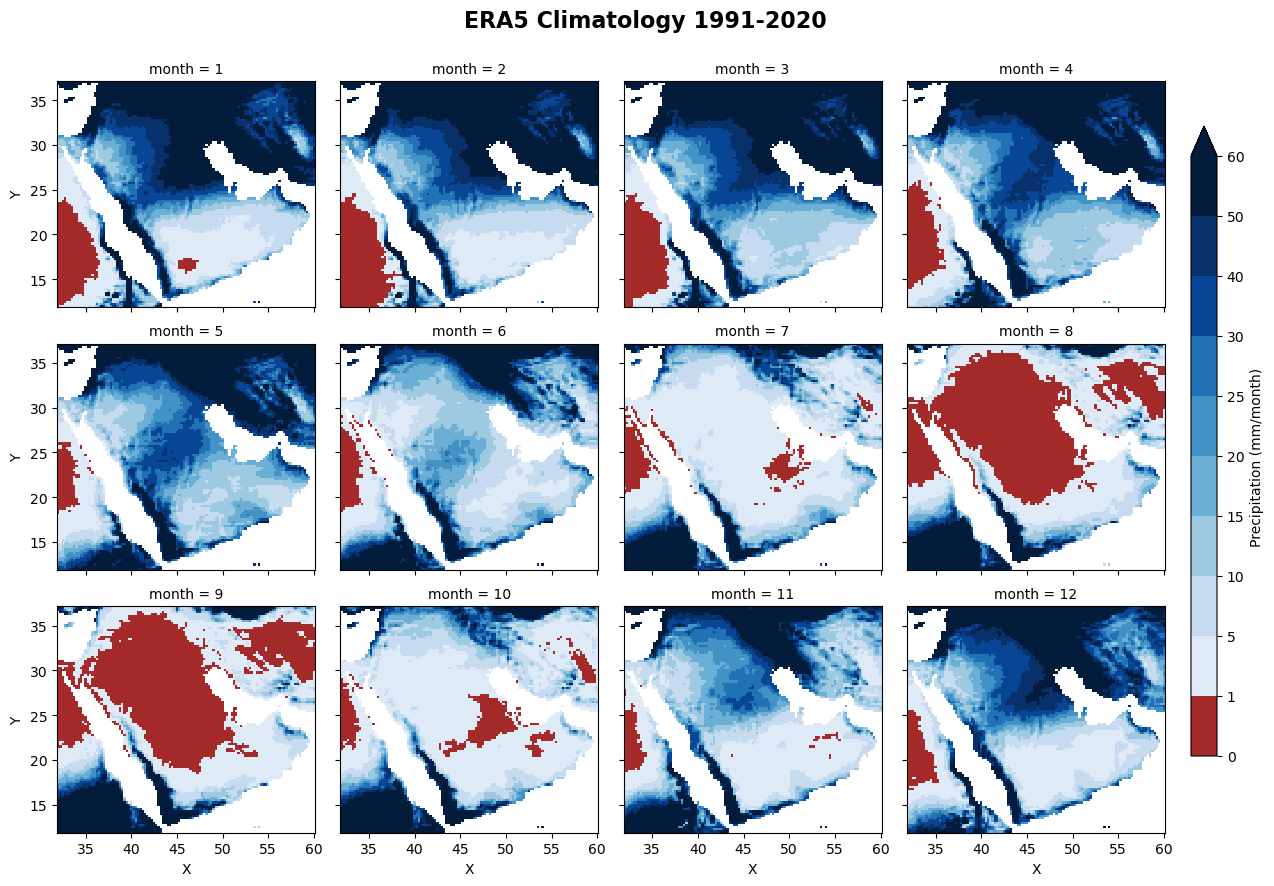

In [16]:
# Define your custom colors
custom_colors = ['brown', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', 
                 '#4292c6', '#2171b5', '#084594', '#08306b', '#041c3c']
custom_cmap = ListedColormap(custom_colors)

# Plot with faceting
g = data['KAUST_precip'].sel(T=slice('1991-01-01', '2020-12-01')).groupby('T.month').mean(dim='T').plot(
    col='month',
    col_wrap=4,
    cmap=custom_cmap,
    levels=[0, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60],
    add_colorbar=False  # Disable individual colorbars
)

# Access the first plot's image (used for the colorbar)
first_plot = g.axes.flat[0].collections[0]

# Add a single shared colorbar
cbar_ax = g.fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
plt.colorbar(
    first_plot,
    cax=cbar_ax,
    spacing='uniform',
    ticks=[0, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60],
    label='Precipitation (mm/month)'
)

# Adjust subplot spacing
g.fig.subplots_adjust(top=0.9, right=0.9)  # Make room for the title and colorbar

# Add the main title
g.fig.suptitle('ERA5 Climatology 1991-2020', fontsize=16, fontweight='bold')

# Show the plot
plt.show()


C:\Users\emile\AppData\Local\Temp\ipykernel_12856\916186142.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  cmap = cmap.drop(['time', 'lat', 'lon'])
C:\Users\emile\AppData\Local\Temp\ipykernel_12856\916186142.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 0.95])  # Make room for colorbar on the right


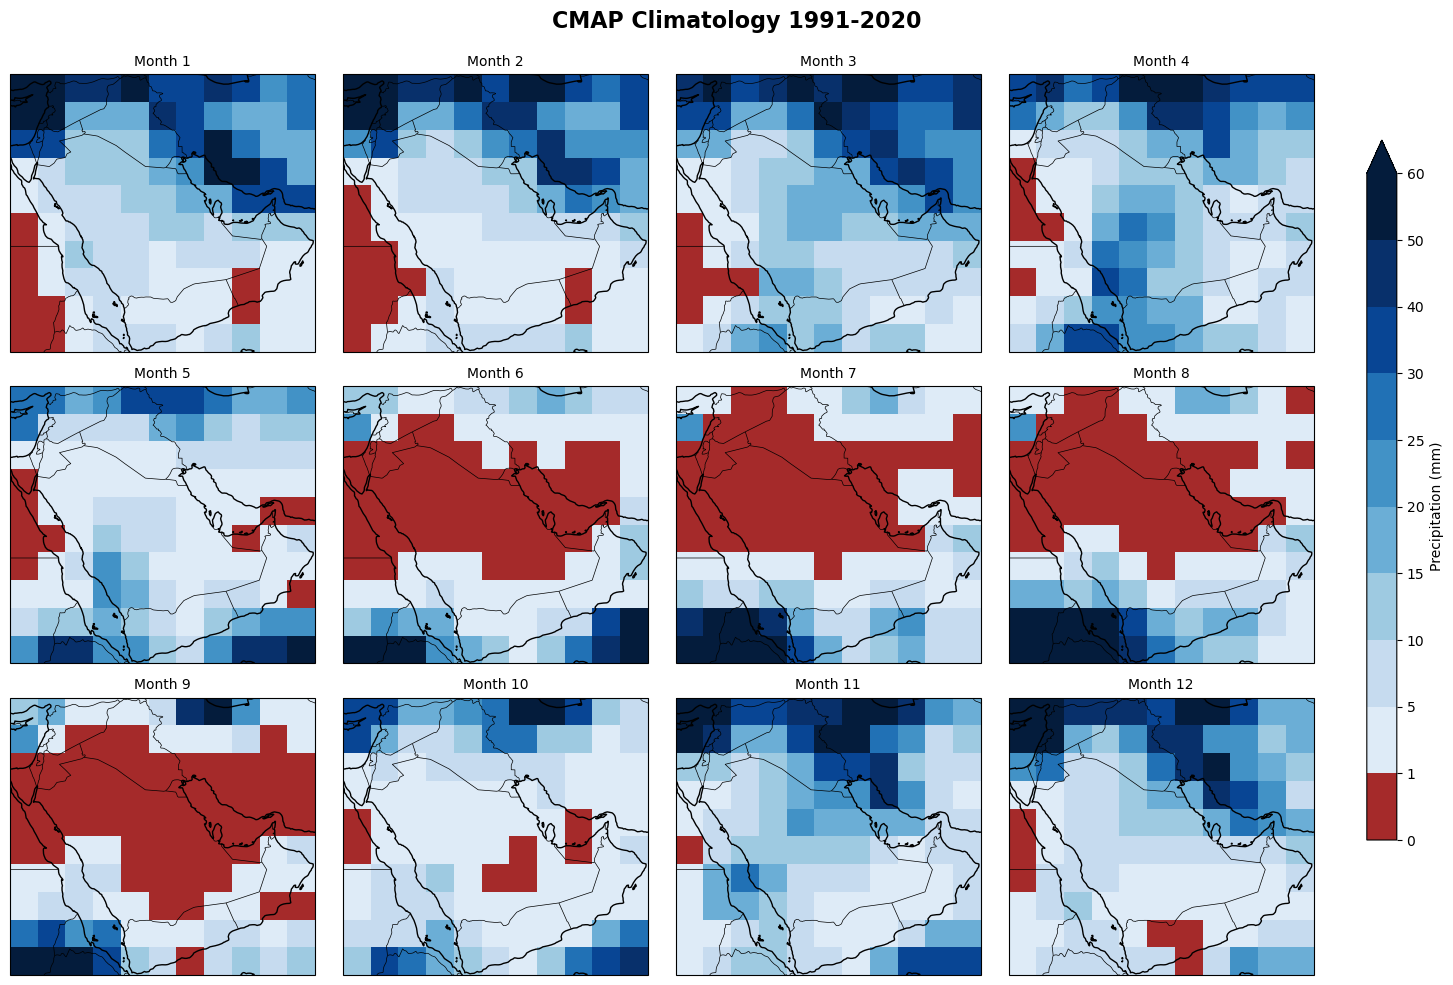

In [17]:
# Prepare data
cmap = xr.open_dataset('data/precip_cmap.nc', decode_times=True)
cmap = cmap.swap_dims({'time': 'T', 'lon': 'X', 'lat': 'Y'})
cmap = cmap.assign_coords(T=cmap.time, X=cmap.lon, Y=cmap.lat)
cmap = cmap.drop(['time', 'lat', 'lon'])
cmap = cmap.sel(X=slice(32, 60), Y=slice(37, 12))
cmap = cmap.transpose('T', 'Y', 'X')
cmap['precip'] = cmap['precip'] * 30
cmap['rolling_sum'] = cmap['precip'] + cmap['precip'].shift(T=1) + cmap['precip'].shift(T=2)
cmap = cmap.isel(T=slice(2, None))

# Compute monthly means
monthly_means = cmap['precip'].sel(T=slice('1991-01-01', '2020-12-01')).groupby('T.month').mean(dim='T')

# Set up facets with transforms
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(3, 4, subplot_kw={'projection': proj}, figsize=(15, 10))
axes = axes.flatten()

# Plot data for each month
for i, (month, ax) in enumerate(zip(monthly_means.month.values, axes)):
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.3)
    
    # Plot with transform and no individual colorbars
    img = monthly_means.sel(month=month).plot(
        ax=ax,
        transform=proj,
        cmap=custom_cmap,
        levels=[0, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60],
        add_colorbar=False  # Disable individual colorbars
    )
    ax.set_title(f'Month {month}', fontsize=10)

# Add a single shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(
    img,
    cax=cbar_ax,
    spacing='uniform',
    ticks=[0, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60],
    label='Precipitation (mm)'
)

# Adjust layout and title
fig.tight_layout(rect=[0, 0, 0.9, 0.95])  # Make room for colorbar on the right
plt.suptitle('CMAP Climatology 1991-2020', fontsize=16, fontweight='bold')

# Show the plot
plt.show()

# Key Dates 

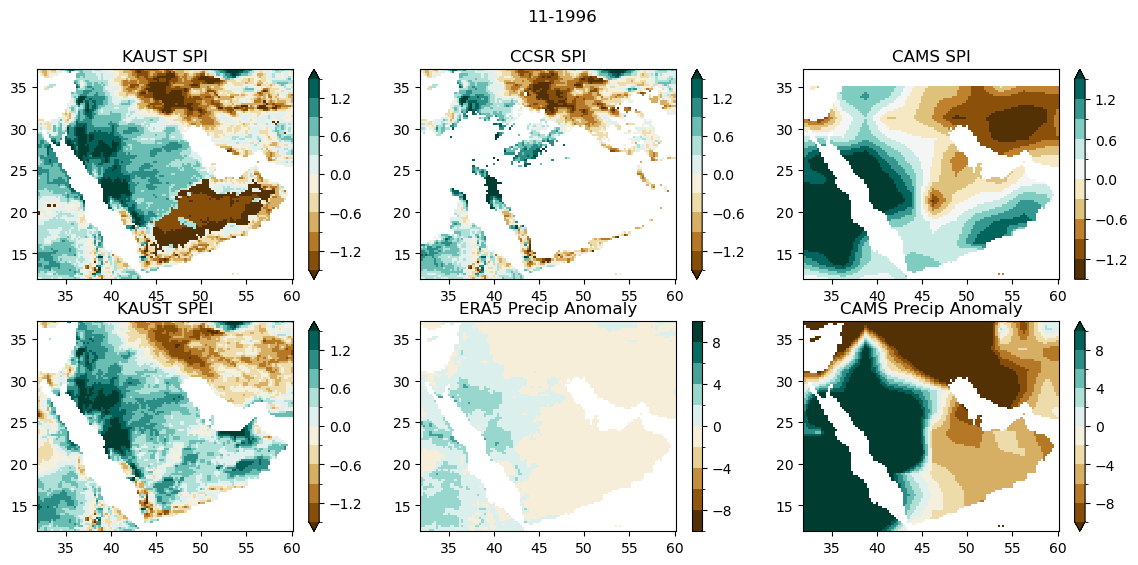

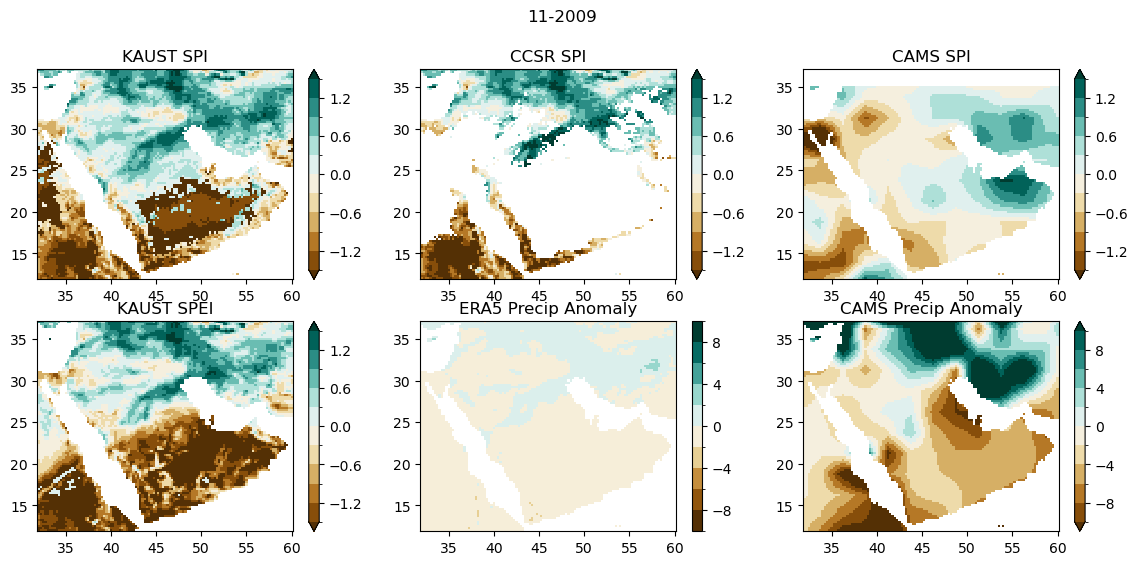

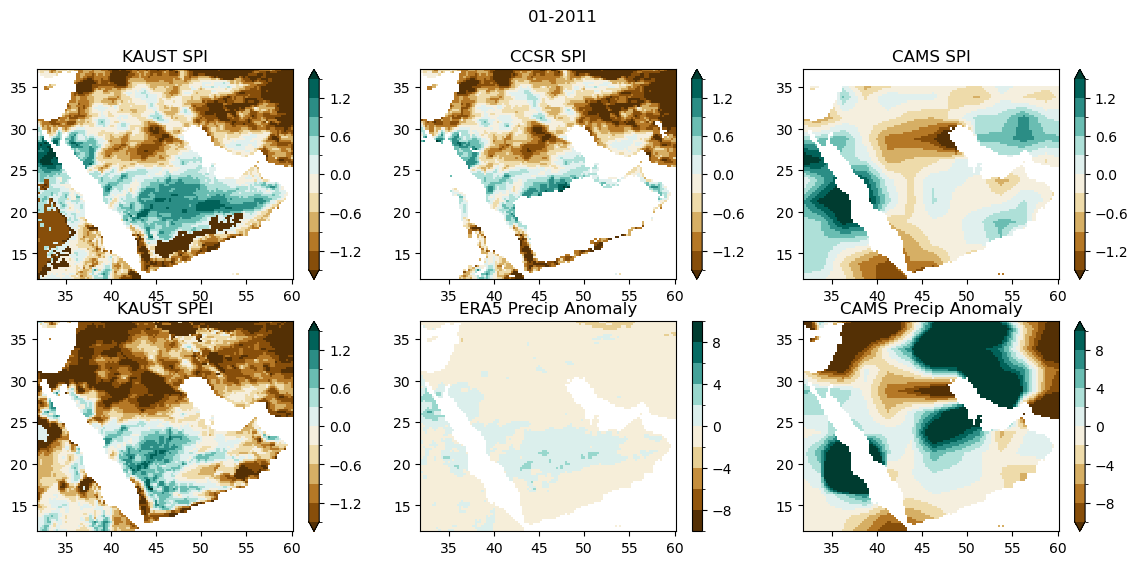

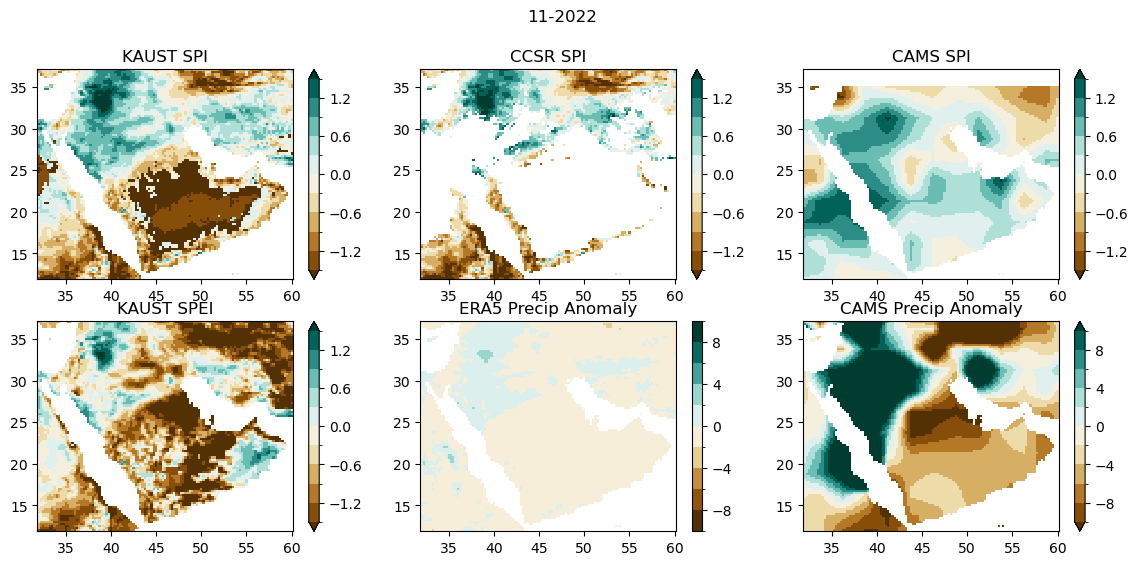

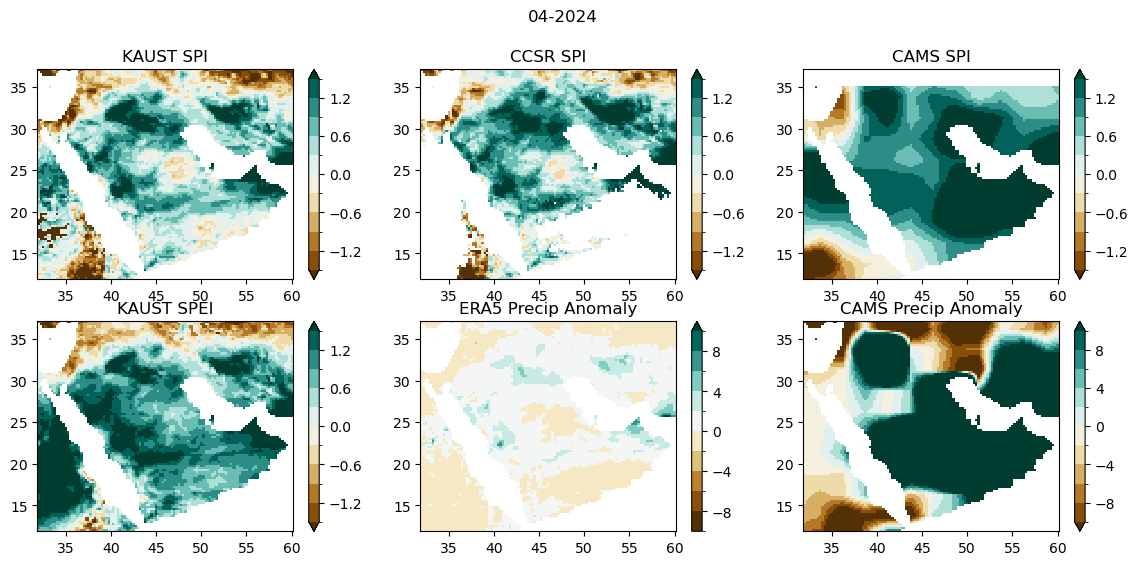

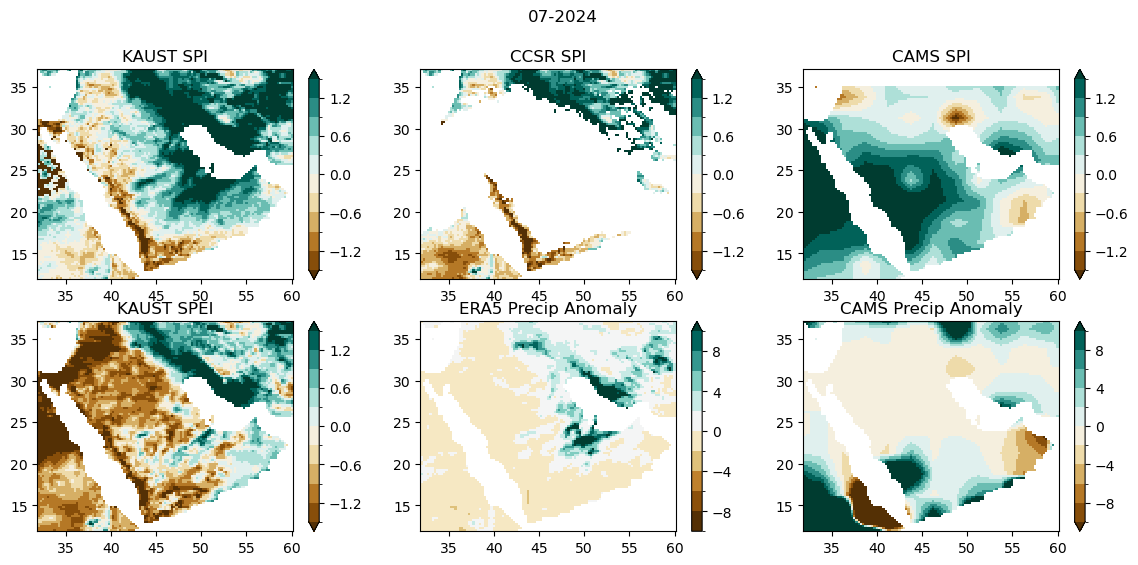

In [17]:
# Create a figure with 3 subplots (one row, three columns)
def plot_date(string):
    fig, axs = plt.subplots(2, 3, figsize=(14, 6))

    # Plot the three variables remove X and Y labels
    data.sel(T=string).KAUST_SPI.plot(ax=axs[0, 0], vmin=-1.5, vmax=1.5,cmap='BrBG', levels=11,cbar_kwargs={'label': ''})
    axs[0, 0].set_title('KAUST SPI')
    data.sel(T=string).custom_SPI.plot(ax=axs[0, 1], vmin=-1.5, vmax=1.5,cmap='BrBG', levels=11,cbar_kwargs={'label': ''})
    axs[0, 1].set_title('CCSR SPI')
    data.sel(T=string).CAMS_SPI.plot(ax=axs[0, 2], vmin=-1.5, vmax=1.5,cmap='BrBG', levels=11,cbar_kwargs={'label': ''})
    axs[0, 2].set_title('CAMS SPI')
    data.sel(T=string).KAUST_SPEI.plot(ax=axs[1, 0], vmin=-1.5, vmax=1.5,cmap='BrBG', levels=11,cbar_kwargs={'label': ''})
    axs[1, 0].set_title('KAUST SPEI')
    data.sel(T=string).KAUST_precip_anomalies.plot(ax=axs[1, 1], vmin=-10, vmax=10,cmap='BrBG', levels=11,cbar_kwargs={'label': ''})
    axs[1, 1].set_title('ERA5 Precip Anomaly')
    data.sel(T=string).CAMS_precip.plot(ax=axs[1, 2], vmin=-10, vmax=10,cmap='BrBG', levels=11,cbar_kwargs={'label': ''})
    axs[1, 2].set_title('CAMS Precip Anomaly')
    #remove X and Y labels
    for ax in axs.flat:
        ax.set(xlabel='', ylabel='')

    # Adjust layout for better appearance
    #plt.tight_layout()
    plt.suptitle(string)
    plt.show()

plot_date('11-1996')
plot_date('11-2009')
plot_date('01-2011')
plot_date('11-2022')
plot_date('04-2024')
plot_date('07-2024')

# Top years

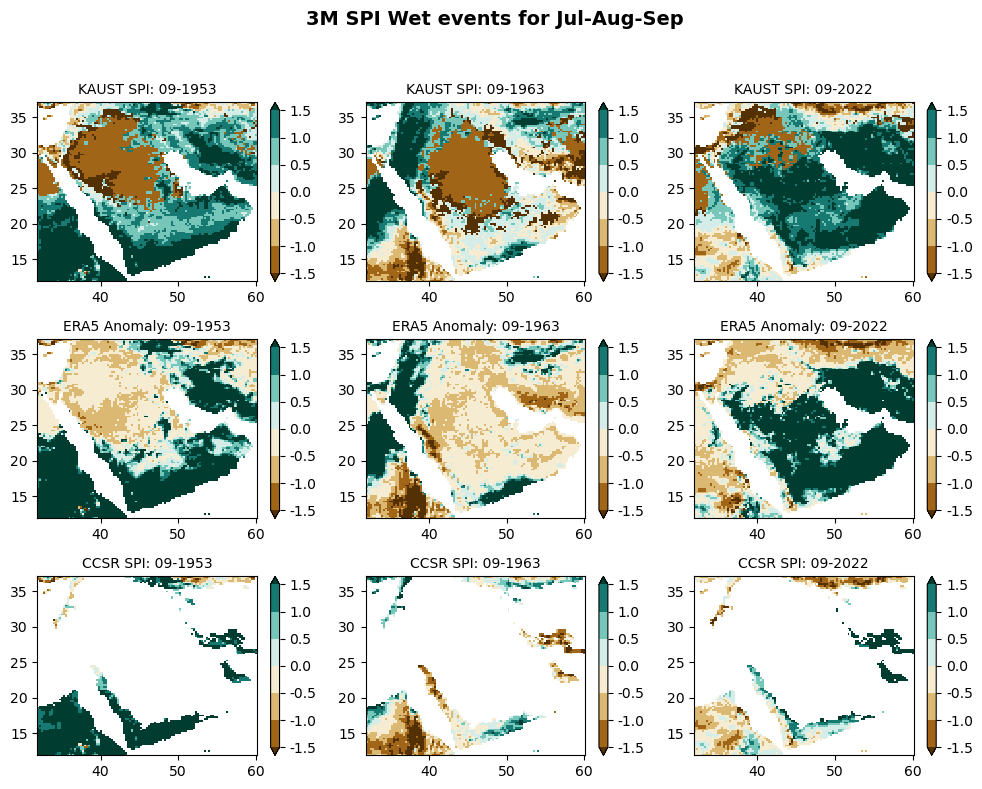

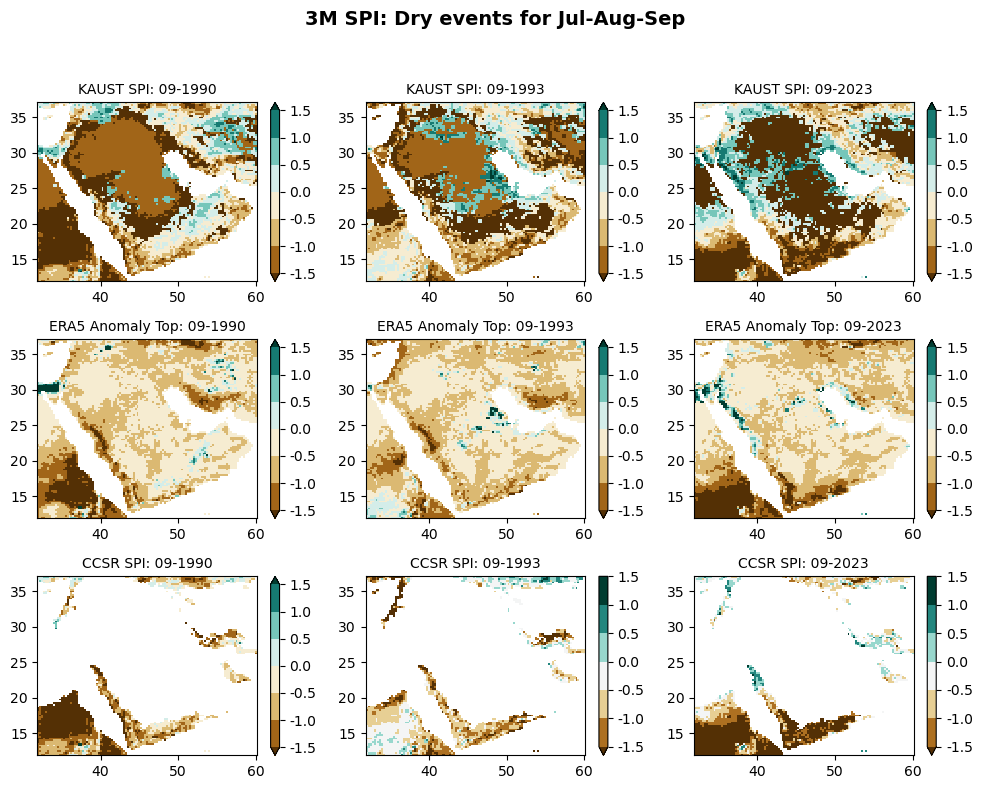

In [18]:
month = 9
month_name = 'Jul-Aug-Sep'

def get_top_bottom_dates(data_var,month=month):
    # Calculate the mean across X and Y
    data_var_month = data_var.sel(T=data_var['T'].dt.month==month)
    mean_values = data_var_month.mean(dim=['X', 'Y'])

    # Sort and get the indices of the top 5 and bottom 5 values
    sorted_indices = mean_values.argsort()

    # Get top 5 and bottom 5 indices
    top_5_indices = sorted_indices[-3:].values
    bottom_5_indices = sorted_indices[:3].values

    # Get the corresponding dates for top 5 and bottom 5
    top_5_dates = data_var_month['T'][top_5_indices].values
    bottom_5_dates = data_var_month['T'][bottom_5_indices].values

    top_5_dates = sorted(top_5_dates)
    bottom_5_dates = sorted(bottom_5_dates)

    return top_5_dates, bottom_5_dates

# Get top 5 and bottom 5 dates for each variable
kaust_top_5, kaust_bottom_5 = get_top_bottom_dates(data['KAUST_SPI'])
era5_top_5, era5_bottom_5 = get_top_bottom_dates(data['KAUST_precip_anomalies'])
custom_top_5, custom_bottom_5 = get_top_bottom_dates(data['custom_SPI'])
spei_top_5, spei_bottom_5 = get_top_bottom_dates(data['KAUST_SPEI'])

kaust_top_5 = era5_top_5
kaust_bottom_5 = era5_bottom_5
custom_top_5 = era5_top_5
custom_bottom_5 = era5_bottom_5



vmin = -1.5
vmax = 1.5
levels = 7
cbar_kwargs={'label': '','format': '%.1f','ticks': np.arange(-3, 3.1, 0.5)}


fig, axes = plt.subplots(3, 3, figsize=(10, 8))
    # Top row (highest 5)
for i, date in enumerate(kaust_top_5):
    #format date to MM-YYYY
    date_str = pd.Timestamp(date).strftime('%m-%Y') 
    ax = axes[0, i]
    data['KAUST_SPI'].sel(T=date).plot(ax=ax, vmin=vmin, vmax=vmax, cmap='BrBG', levels=levels,cbar_kwargs=cbar_kwargs)
    ax.set_title(f"KAUST SPI: {date_str}", fontsize=10)
    ax.set(xlabel='', ylabel='')

    # Bottom row (lowest 5)
for i, date in enumerate(era5_top_5):
    #format date to MM-YYYY
    date_str = pd.Timestamp(date).strftime('%m-%Y') 
    ax = axes[1, i]
    data['KAUST_precip_anomalies'].sel(T=date).plot(ax=ax, vmin=vmin, vmax=vmax, cmap='BrBG', levels=levels,cbar_kwargs=cbar_kwargs)
    ax.set_title(f"ERA5 Anomaly: {date_str}", fontsize=10)
    ax.set(xlabel='', ylabel='')

for i, date in enumerate(custom_top_5):
    #format date to MM-YYYY
    date_str = pd.Timestamp(date).strftime('%m-%Y') 
    ax = axes[2, i]
    data['custom_SPI'].sel(T=date).plot(ax=ax, vmin=vmin, vmax=vmax, cmap='BrBG', levels=levels,cbar_kwargs=cbar_kwargs)
    ax.set_title(f"CCSR SPI: {date_str}", fontsize=10)
    ax.set(xlabel='', ylabel='')


    # Set overall title
plt.suptitle(f"3M SPI Wet events for {month_name}", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


fig, axes = plt.subplots(3, 3, figsize=(10, 8))
    # Top row (highest 5)
for i, date in enumerate(kaust_bottom_5):
    #format date to MM-YYYY
    date_str = pd.Timestamp(date).strftime('%m-%Y') 
    ax = axes[0, i]
    data['KAUST_SPI'].sel(T=date).plot(ax=ax, vmin=vmin, vmax=vmax, cmap='BrBG', levels=levels,cbar_kwargs=cbar_kwargs)
    ax.set_title(f"KAUST SPI: {date_str}", fontsize=10)
    ax.set(xlabel='', ylabel='')

    # Bottom row (lowest 5)
for i, date in enumerate(era5_bottom_5):
    #format date to MM-YYYY
    date_str = pd.Timestamp(date).strftime('%m-%Y') 
    ax = axes[1, i]
    data['KAUST_precip_anomalies'].sel(T=date).plot(ax=ax, vmin=vmin, vmax=vmax, cmap='BrBG', levels=levels,cbar_kwargs=cbar_kwargs)
    ax.set_title(f"ERA5 Anomaly Top: {date_str}", fontsize=10)
    ax.set(xlabel='', ylabel='')

for i, date in enumerate(custom_bottom_5):
    #format date to MM-YYYY
    date_str = pd.Timestamp(date).strftime('%m-%Y') 
    ax = axes[2, i]
    data['custom_SPI'].sel(T=date).plot(ax=ax, vmin=vmin, vmax=vmax, cmap='BrBG', levels=levels,cbar_kwargs=cbar_kwargs)
    ax.set_title(f"CCSR SPI: {date_str}", fontsize=10)
    ax.set(xlabel='', ylabel='')

# for i, date in enumerate(spei_bottom_5):
#     #format date to MM-YYYY
#     date_str = pd.Timestamp(date).strftime('%m-%Y')
#     ax = axes[3, i]
#     data['KAUST_SPEI'].sel(T=date).plot(ax=ax, vmin=vmin, vmax=vmax, cmap='BrBG', levels=levels,cbar_kwargs={'label': ''})
#     ax.set_title(f"KAUST SPEI Top {i+1}: {date_str}", fontsize=10)
#     ax.set(xlabel='', ylabel='')

    # Set overall title
plt.suptitle(f"3M SPI: Dry events for {month_name}", fontsize=14,fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Correlations

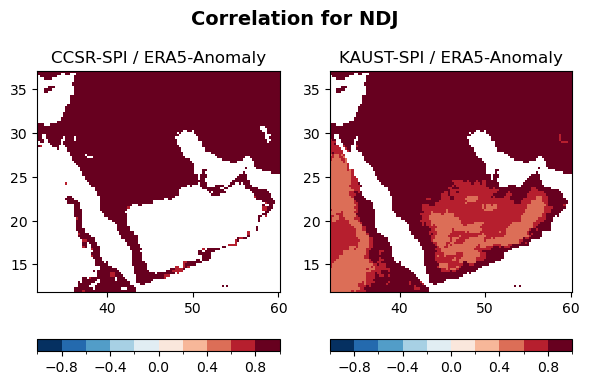

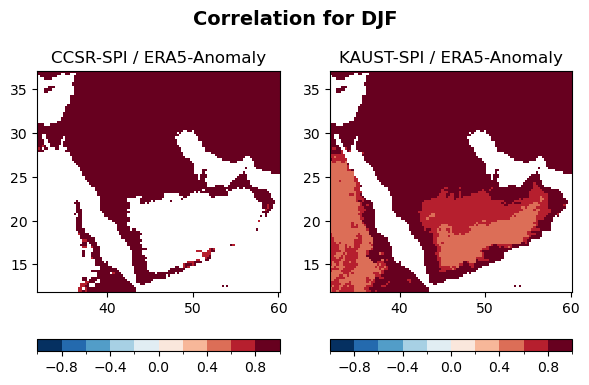

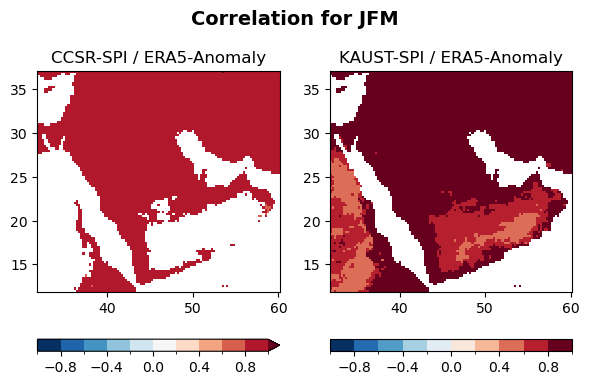

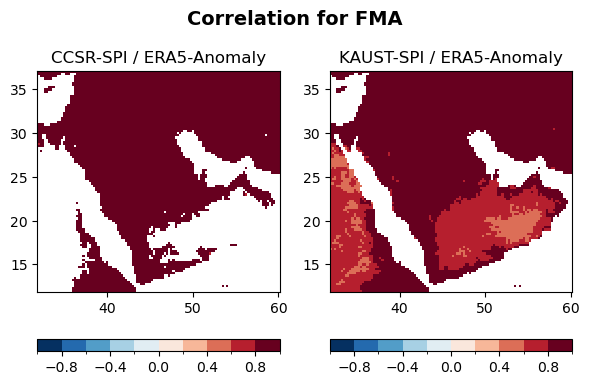

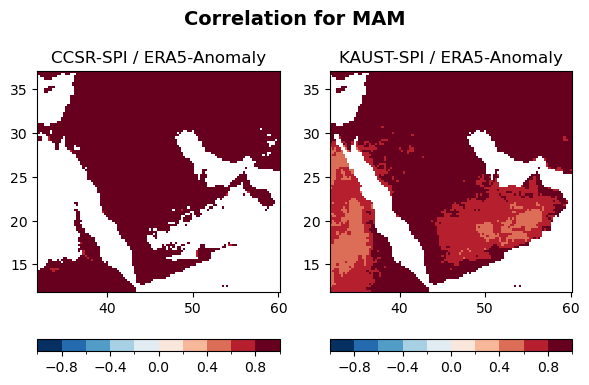

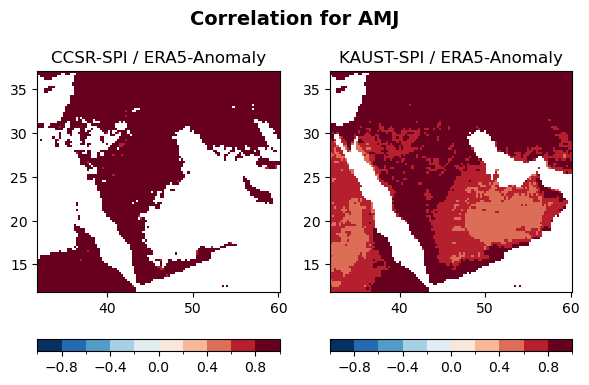

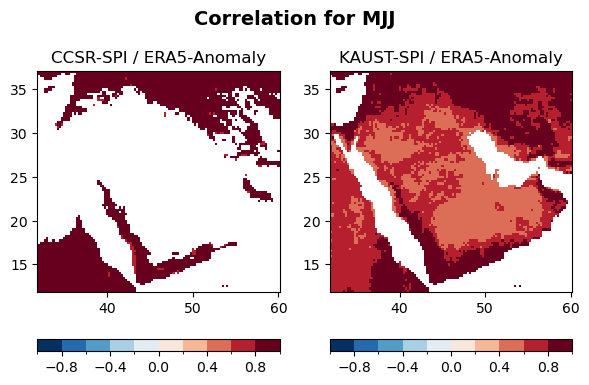

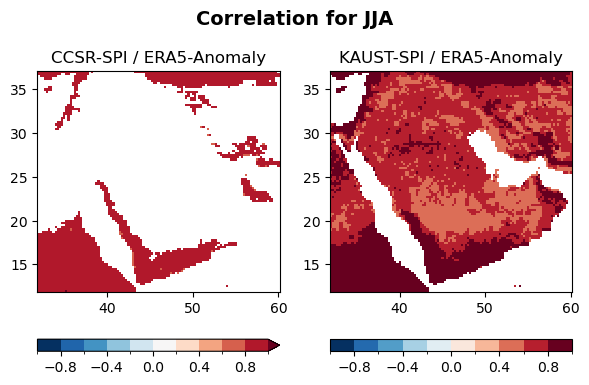

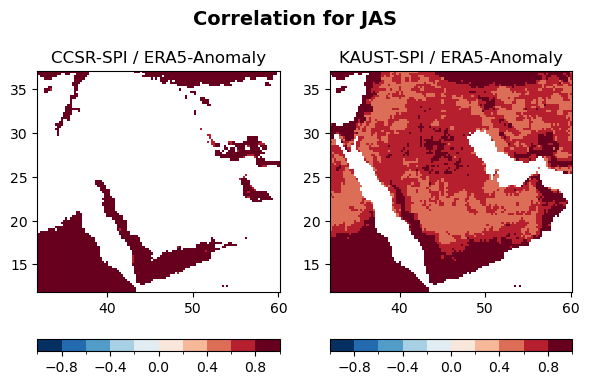

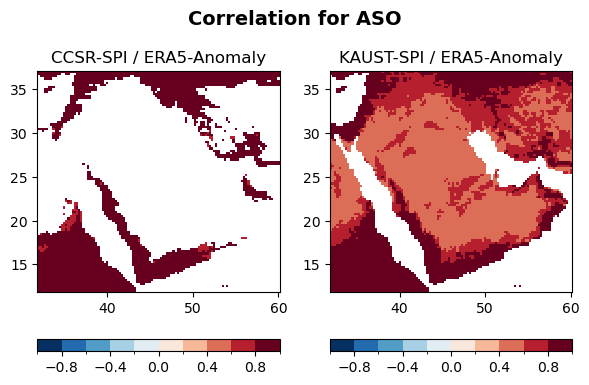

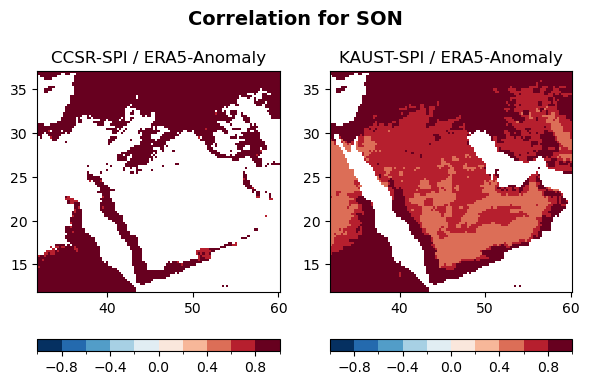

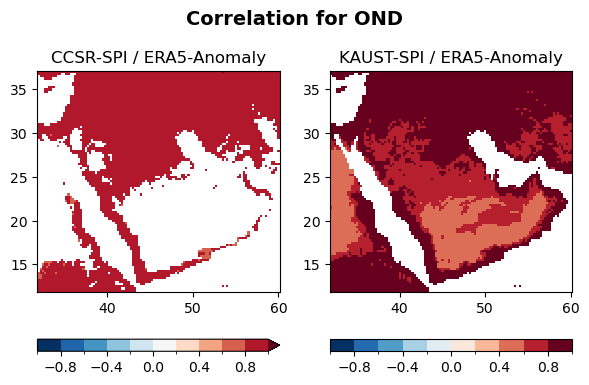

In [19]:
def compute_gridwise_correlation(data, var1, var2, var3, var4,var5):


    # Ensure the time coordinate is in datetime format and extract the month
    if data['T'].dtype != 'datetime64[ns]':
        data['T'] = pd.to_datetime(data['T'].values, format='%m-%Y')
    months = data['T'].dt.month

    
    # Prepare an empty dataset to store the correlations for each month
    corr_ds = xr.Dataset()
    # Loop over each month
    for month in range(1, 13):  # Months 1 to 12
        # Select data for the specific month
        monthly_data = data.where(months == month, drop=True)

        # Compute correlations for each pair of variables using xarray's corr method
        corr1_2 = xr.corr(monthly_data[var1], monthly_data[var2], dim='T').assign_coords(X=monthly_data.X, Y=monthly_data.Y)
        corr1_3 = xr.corr(monthly_data[var1], monthly_data[var3], dim='T').assign_coords(X=monthly_data.X, Y=monthly_data.Y)
        corr2_3 = xr.corr(monthly_data[var2], monthly_data[var3], dim='T').assign_coords(X=monthly_data.X, Y=monthly_data.Y)
        corr1_4 = xr.corr(monthly_data[var1], monthly_data[var4], dim='T').assign_coords(X=monthly_data.X, Y=monthly_data.Y)
        corr2_4 = xr.corr(monthly_data[var2], monthly_data[var4], dim='T').assign_coords(X=monthly_data.X, Y=monthly_data.Y)
        corr3_4 = xr.corr(monthly_data[var3], monthly_data[var4], dim='T').assign_coords(X=monthly_data.X, Y=monthly_data.Y)
        corr1_5 = xr.corr(monthly_data[var1], monthly_data[var5], dim='T').assign_coords(X=monthly_data.X, Y=monthly_data.Y)
        corr2_5 = xr.corr(monthly_data[var2], monthly_data[var5], dim='T')
        corr3_5 = xr.corr(monthly_data[var3], monthly_data[var5], dim='T')
        corr4_5 = xr.corr(monthly_data[var4], monthly_data[var5], dim='T')
    

        # Store the correlation results in the dataset using X and Y coordinates from the first variable
        corr_ds[f'corr_{var1}_{var2}_month_{month}']  =  corr1_2
        corr_ds[f'corr_{var1}_{var3}_month_{month}'] = corr1_3
        corr_ds[f'corr_{var2}_{var3}_month_{month}'] = corr2_3
        corr_ds[f'corr_{var1}_{var4}_month_{month}'] = corr1_4
        corr_ds[f'corr_{var2}_{var4}_month_{month}'] = corr1_4
        corr_ds[f'corr_{var3}_{var4}_month_{month}'] = corr3_4
        corr_ds[f'corr_{var1}_{var5}_month_{month}'] = corr1_5
        corr_ds[f'corr_{var2}_{var5}_month_{month}'] = corr2_5
        corr_ds[f'corr_{var3}_{var5}_month_{month}'] = corr3_5
        corr_ds[f'corr_{var4}_{var5}_month_{month}'] = corr4_5


    return corr_ds

# Compute the gridwise correlation between KAUST, CAMS, and SPI
corr_ds = compute_gridwise_correlation(data, 'KAUST_SPI', 'CAMS_SPI', 'KAUST_precip_anomalies', 'KAUST_SPEI', 'custom_SPI')



# Plot the gridwise correlation for each month (var1 vs var2)
for month in range(1, 13):
    month_names = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
    month_name = month_names[month - 1]
    plt.figure(figsize=(6, 4))

    # Plot correlation between KAUST and CAMS
    plt.subplot(1, 2, 1)
    corr_map = corr_ds[f'corr_KAUST_precip_anomalies_custom_SPI_month_{month}']
    corr_map.plot(vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=True,levels=11,cbar_kwargs={'label': '','orientation': 'horizontal'})
    plt.title(f'CCSR-SPI / ERA5-Anomaly')

    # Plot correlation between KAUST and SPI
    plt.subplot(1, 2, 2)
    corr_map = corr_ds[f'corr_KAUST_SPI_KAUST_precip_anomalies_month_{month}']
    corr_map.plot(vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=True,levels=11,cbar_kwargs={'label': '','orientation': 'horizontal'})
    plt.title(f'KAUST-SPI / ERA5-Anomaly')

    # # Plot correlation between CAMS and SPI
    # plt.subplot(1, 5, 3)
    # corr_map = corr_ds[f'corr_KAUST_precip_anomalies_KAUST_SPEI_month_{month}']
    # corr_map.plot(vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False,levels=11)
    # plt.title(f'KAUST-SPEI / ERA5-prcp - Month {month}')

    # plt.subplot(1, 5, 4)
    # corr_map = corr_ds[f'corr_KAUST_SPI_custom_SPI_month_{month}']
    # corr_map.plot(vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=False,levels=11)
    # plt.title(f'KAUST-SPI / CCSR-SPI - Month {month}')

    # plt.subplot(1, 5, 5)
    # corr_map = corr_ds[f'corr_KAUST_precip_anomalies_custom_SPI_month_{month}']
    # corr_map.plot(vmin=-1, vmax=1, cmap='RdBu_r', add_colorbar=True,levels=11)
    # plt.title(f'CCSR SPI / ERA5-prcp - Month {month}')
    #remove X and Y labels
    for ax in plt.gcf().axes:
        ax.set(xlabel='', ylabel='')
    plt.suptitle(f'Correlation for {month_name}', fontsize=14,fontweight='bold')
    plt.tight_layout()
    plt.show()

## Time series

C:\Users\emile\AppData\Local\Temp\ipykernel_7948\932577632.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND'])


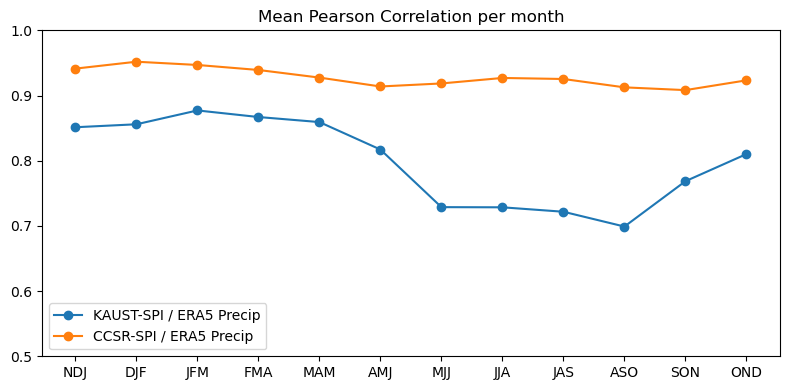

In [20]:
corr_kaust_custom = np.zeros(12)
corr_kaust_cams = np.zeros(12)
corr_cams_opi = np.zeros(12)
corr_kaust_era5 = np.zeros(12)
corr_custom_era5 = np.zeros(12)
corr_cams_era5 = np.zeros(12)
corr_spei_era5 = np.zeros(12)
corr_spei_custom = np.zeros(12)
months = np.arange(1, 13)
for month in months:
    data_month = data.where(data['T'].dt.month == month, drop=True)

    corr_mat_kaust_custom = xr.corr(data_month['KAUST_SPI'], data_month['custom_SPI'], dim='T')
    corr_mat_kaust_cams = xr.corr(data_month['KAUST_SPI'], data_month['CAMS_SPI'], dim='T')
    corr_mat_cams_opi = xr.corr(data_month['CAMS_SPI'], data_month['CAMS_precip'], dim='T')
    corr_mat_kaust_era5 = xr.corr(data_month['KAUST_SPI'], data_month['KAUST_precip_anomalies'], dim='T')
    corr_mat_custom_era5 = xr.corr(data_month['custom_SPI'], data_month['KAUST_precip_anomalies'], dim='T')
    corr_mat_cams_era5 = xr.corr(data_month['CAMS_SPI'], data_month['KAUST_precip_anomalies'], dim='T')
    corr_mat_spei_era5 = xr.corr(data_month['KAUST_SPEI'], data_month['KAUST_precip_anomalies'], dim='T')
    corr_mat_spei_custom = xr.corr(data_month['KAUST_SPEI'], data_month['custom_SPI'], dim='T')


    corr_kaust_custom[month-1] = xr.where(np.isinf(corr_mat_kaust_custom), np.nan, corr_mat_kaust_custom).mean()
    corr_kaust_cams[month-1] = xr.where(np.isinf(corr_mat_kaust_cams), np.nan, corr_mat_kaust_cams).mean()
    corr_cams_opi[month-1] = xr.where(np.isinf(corr_mat_cams_opi), np.nan, corr_mat_cams_opi).mean()
    corr_kaust_era5[month-1] = xr.where(np.isinf(corr_mat_kaust_era5), np.nan, corr_mat_kaust_era5).mean()
    corr_custom_era5[month-1] = xr.where(np.isinf(corr_mat_custom_era5), np.nan, corr_mat_custom_era5).mean()
    corr_cams_era5[month-1] = xr.where(np.isinf(corr_mat_cams_era5), np.nan, corr_mat_cams_era5).mean()
    corr_spei_era5[month-1] = xr.where(np.isinf(corr_mat_spei_era5), np.nan, corr_mat_spei_era5).mean()
    corr_spei_custom[month-1] = xr.where(np.isinf(corr_mat_spei_custom), np.nan, corr_mat_spei_custom).mean()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

#dataframe with correlation values
df = pd.DataFrame({'Month': months, 'KAUST-SPI / CCSR-SPI': corr_kaust_custom, 'KAUST-SPi / CAMS SPI': corr_kaust_cams,
                    'CAMS-SPI / CAMS-Precip': corr_cams_opi, 'KAUST-SPI / ERA5 Precip': corr_kaust_era5,
                      'CCSR-SPI / ERA5 Precip': corr_custom_era5, 'CAMS-SPI / ERA5 Precip': corr_cams_era5,
                      'KAUST-SPEI / ERA5 Precip': corr_spei_era5, 'KAUST-SPEI / CCSR-SPI': corr_spei_custom})

#bar plot
#df.plot(x='Month', kind='bar', ax=ax)

# # Plot the correlation values
#ax.plot(months, corr_kaust_custom, label='KAUST-SPI / CCSR-SPI', marker='o')
#ax.plot(months, corr_kaust_cams, label='KAUST-SPi / CAMS SPI', marker='o')
#ax.plot(months, corr_cams_opi, label='CAMS-SPI / CAMS-Precip', marker='o')
ax.plot(months, corr_kaust_era5, label='KAUST-SPI / ERA5 Precip', marker='o')
ax.plot(months, corr_custom_era5, label='CCSR-SPI / ERA5 Precip', marker='o')
#ax.plot(months, corr_spei_era5, label='KAUST-SPEI / ERA5 Precip', marker='o')
#ax.plot(months, corr_spei_custom, label='KAUST-SPEI / CCSR-SPI', marker='o')
#ticks every month
ax.set_xticklabels(['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND'])
ax.set_xticks(months)
ax.set_ylim(0.5, 1)
plt.legend()
plt.title('Mean Pearson Correlation per month')
plt.tight_layout()


# Mean

C:\Users\emile\AppData\Local\Temp\ipykernel_7948\4117334953.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


Text(0.5, 1.0, 'Mean Value per month')

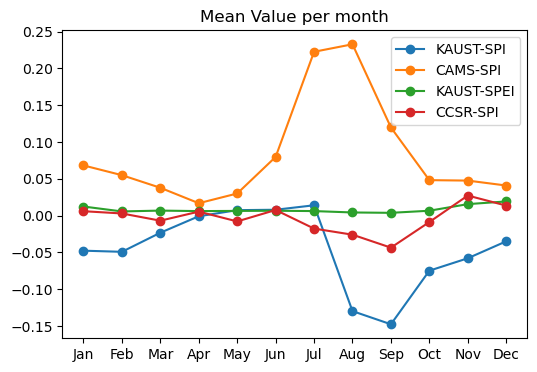

In [21]:
opi_mean = np.zeros(12)
kaust_mean = np.zeros(12)
cams_mean = np.zeros(12)
era5_mean = np.zeros(12)
custom_mean = np.zeros(12)
spei_mean = np.zeros(12)
months = np.arange(1, 13)
for month in months:
    data_month = data.where(data['T'].dt.month == month, drop=True)

    opi_mean[month-1] = data_month['CAMS_precip'].mean()
    kaust_mean[month-1] = data_month['KAUST_SPI'].mean()
    cams_mean[month-1] = data_month['CAMS_SPI'].mean()
    era5_mean[month-1] = data_month['KAUST_precip_anomalies'].mean()
    custom_mean[month-1] = data_month['custom_SPI'].mean()
    spei_mean[month-1] = data_month['KAUST_SPEI'].mean()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the correlation values
#ax.plot(months, opi_mean, label='OPI', marker='o')
ax.plot(months, kaust_mean, label='KAUST-SPI', marker='o')
ax.plot(months, cams_mean, label='CAMS-SPI', marker='o')
#ax.plot(months, era5_mean, label='ERA5', marker='o')
ax.plot(months, spei_mean, label='KAUST-SPEI', marker='o')
ax.plot(months, custom_mean, label='CCSR-SPI', marker='o')

#ticks every month
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_xticks(months)
plt.legend()
plt.title('Mean Value per month')

Text(0.5, 1.0, 'Std per month')

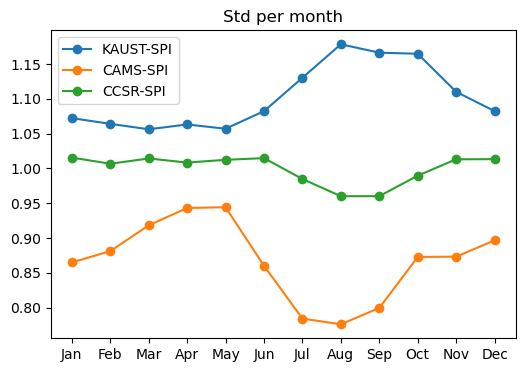

In [22]:
opi_mean = np.zeros(12)
kaust_mean = np.zeros(12)
cams_mean = np.zeros(12)
era5_mean = np.zeros(12)
custom_mean = np.zeros(12)
months = np.arange(1, 13)
for month in months:
    data_month = data.where(data['T'].dt.month == month, drop=True)

    opi_mean[month-1] = data_month['CAMS_precip'].std()
    kaust_mean[month-1] = data_month['KAUST_SPI'].std()
    cams_mean[month-1] = data_month['CAMS_SPI'].std()
    era5_mean[month-1] = data_month['KAUST_precip_anomalies'].std()
    custom_mean[month-1] = data_month['custom_SPI'].std()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the correlation values
#ax.plot(months, opi_mean, label='OPI', marker='o')
ax.plot(months, kaust_mean, label='KAUST-SPI', marker='o')
ax.plot(months, cams_mean, label='CAMS-SPI', marker='o')
#ax.plot(months, era5_mean, label='ERA5', marker='o')
ax.plot(months, custom_mean, label='CCSR-SPI', marker='o')

#ticks every month
ax.set_xticks(months)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.title('Std per month')

Text(0.5, 0.98, 'Time Average')

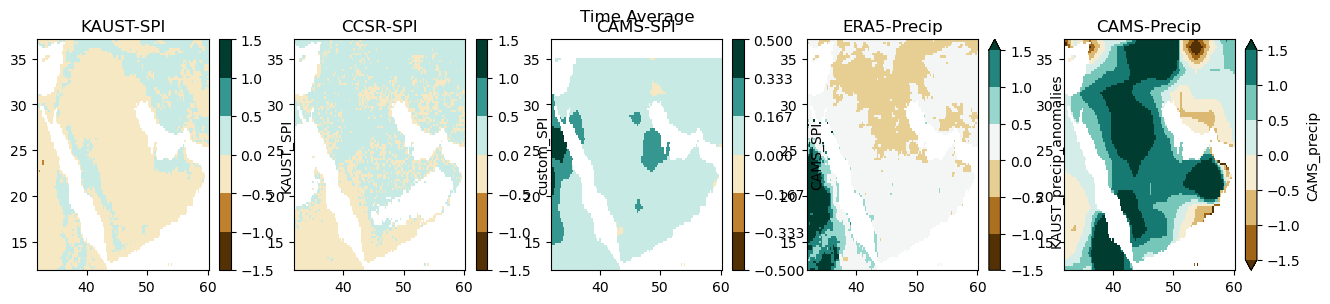

In [23]:

# Time average for KAUST and CAMS labeled variables
kaust_time_avg = data['KAUST_SPI'].mean(dim='T')
cams_time_avg = data['CAMS_SPI'].mean(dim='T')
opi_time_avg = data['CAMS_precip'].mean(dim='T')
era5_time_avg = data['KAUST_precip_anomalies'].mean(dim='T')
custom_time_avg = data['custom_SPI'].mean(dim='T')

# Create a figure with 3 subplots (one row, three columns)
fig, axs = plt.subplots(1, 5, figsize=(16, 3))

# Plot the time average for each variable
kaust_time_avg.plot(ax=axs[0], cmap='BrBG',levels=7,vmin=-1.5, vmax=1.5)
axs[0].set_title('KAUST-SPI')

custom_time_avg.plot(ax=axs[1], cmap='BrBG',levels=7,vmin=-1.5, vmax=1.5)
axs[1].set_title('CCSR-SPI')

cams_time_avg.plot(ax=axs[2], cmap='BrBG',levels=7,vmin=-0.5, vmax=0.5)
axs[2].set_title('CAMS-SPI')

era5_time_avg.plot(ax=axs[3], cmap='BrBG',levels=7,vmin=-1.5, vmax=1.5)
axs[3].set_title('ERA5-Precip')

opi_time_avg.plot(ax=axs[4], cmap='BrBG',levels=7,vmin=-1.5, vmax=1.5)
axs[4].set_title('CAMS-Precip')


#rempve X and Y labels
for ax in axs.flat:
    ax.set(xlabel='', ylabel='')

plt.suptitle('Time Average')

Text(0.5, 0.98, 'Time Stdev')

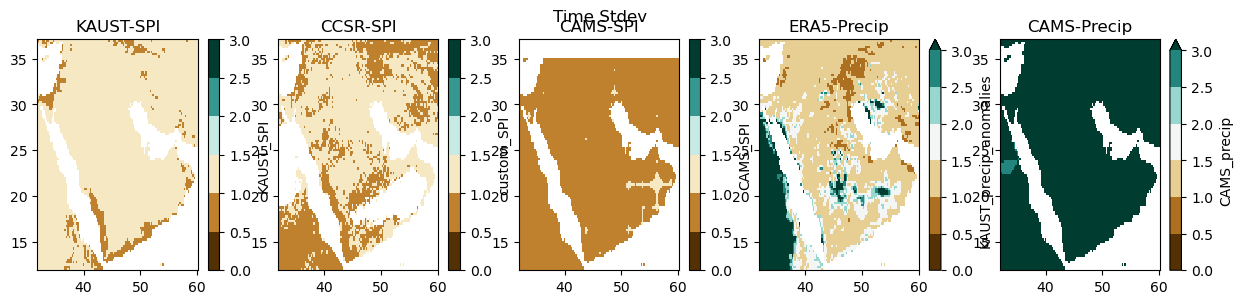

In [24]:

# Time average for KAUST and CAMS labeled variables
kaust_time_avg = data['KAUST_SPI'].std(dim='T')
cams_time_avg = data['CAMS_SPI'].std(dim='T')
opi_time_avg = data['CAMS_precip'].std(dim='T')
era5_time_avg = data['KAUST_precip_anomalies'].std(dim='T')
custom_time_avg = data['custom_SPI'].std(dim='T')

# Create a figure with 3 subplots (one row, three columns)
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Plot the time average for each variable
kaust_time_avg.plot(ax=axs[0], cmap='BrBG',levels=7,vmin=0, vmax=3)
axs[0].set_title('KAUST-SPI')

custom_time_avg.plot(ax=axs[1], cmap='BrBG',levels=7,vmin=0, vmax=3)
axs[1].set_title('CCSR-SPI')

cams_time_avg.plot(ax=axs[2], cmap='BrBG',levels=7,vmin=0, vmax=3)
axs[2].set_title('CAMS-SPI')

era5_time_avg.plot(ax=axs[3], cmap='BrBG',levels=7,vmin=0, vmax=3)
axs[3].set_title('ERA5-Precip')

opi_time_avg.plot(ax=axs[4], cmap='BrBG',levels=7,vmin=0, vmax=3)
axs[4].set_title('CAMS-Precip')


#rempve X and Y labels
for ax in axs.flat:
    ax.set(xlabel='', ylabel='')

plt.suptitle('Time Stdev')

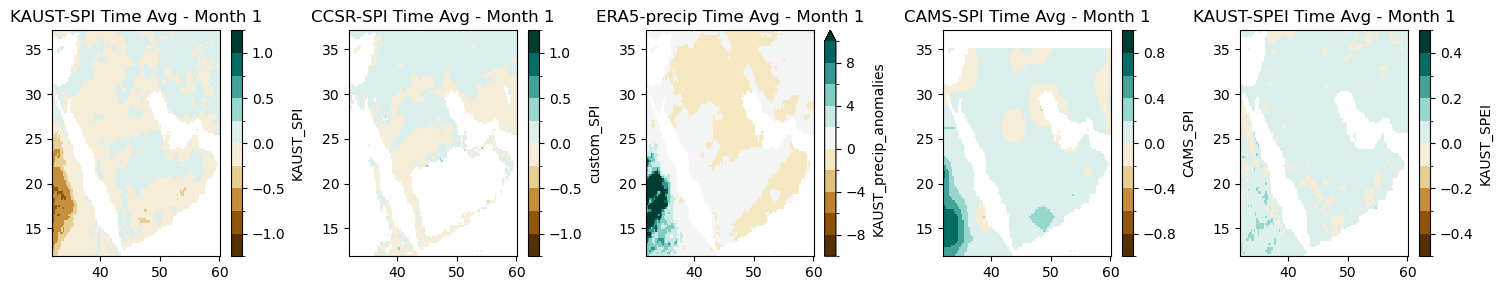

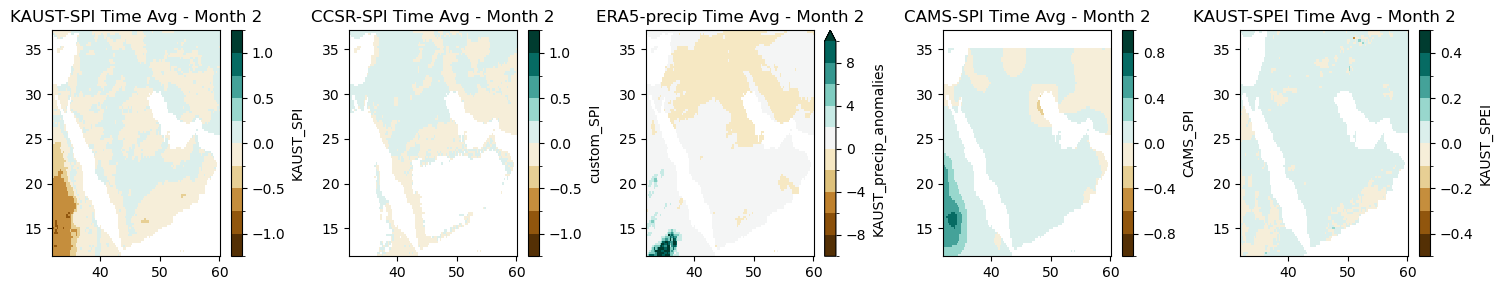

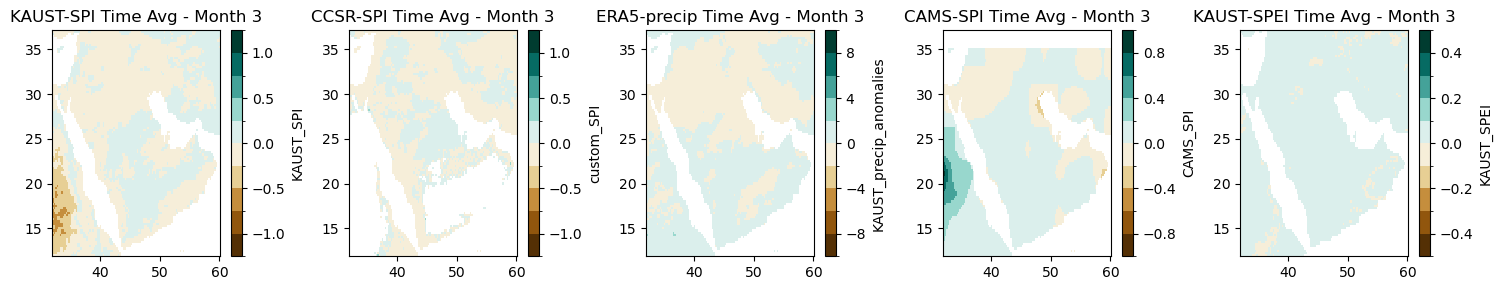

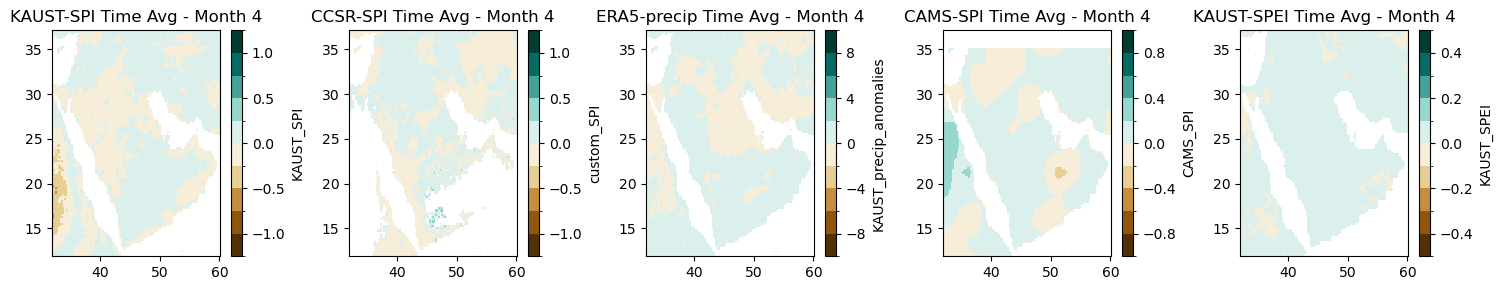

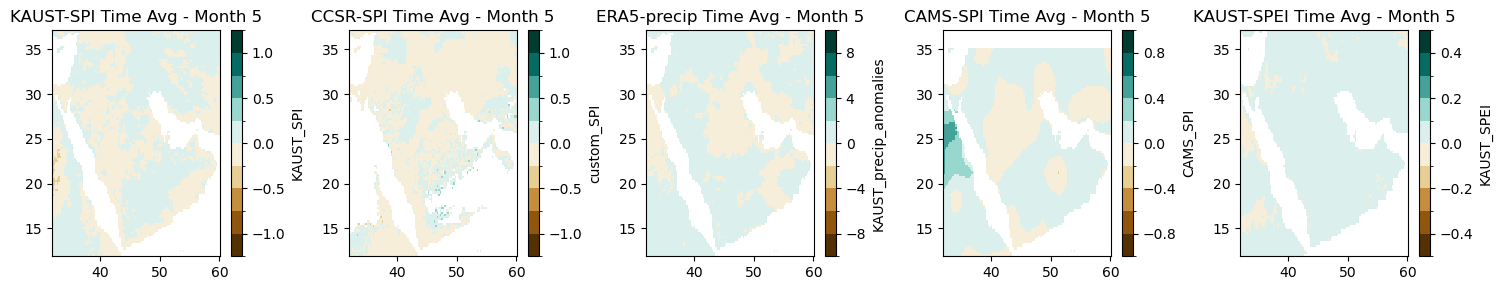

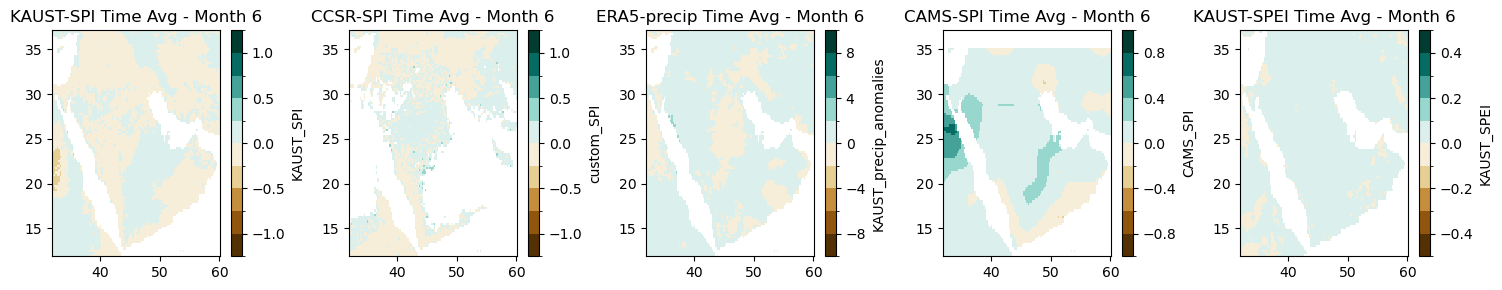

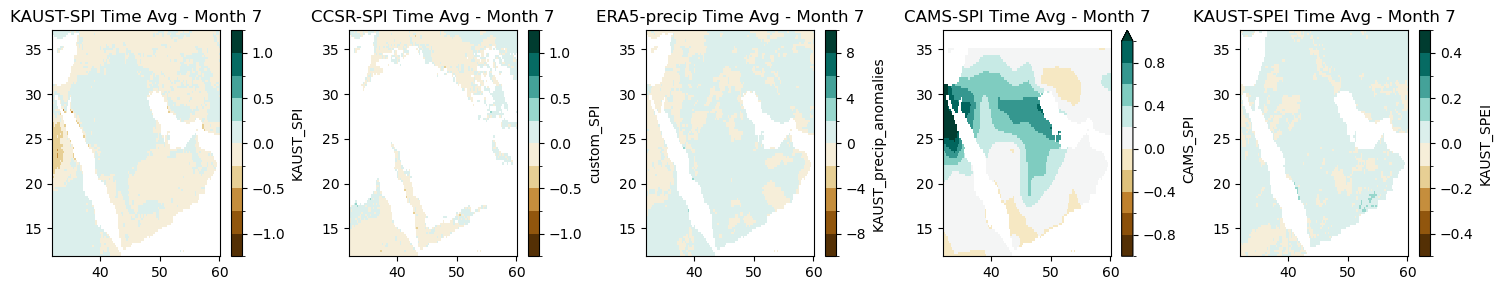

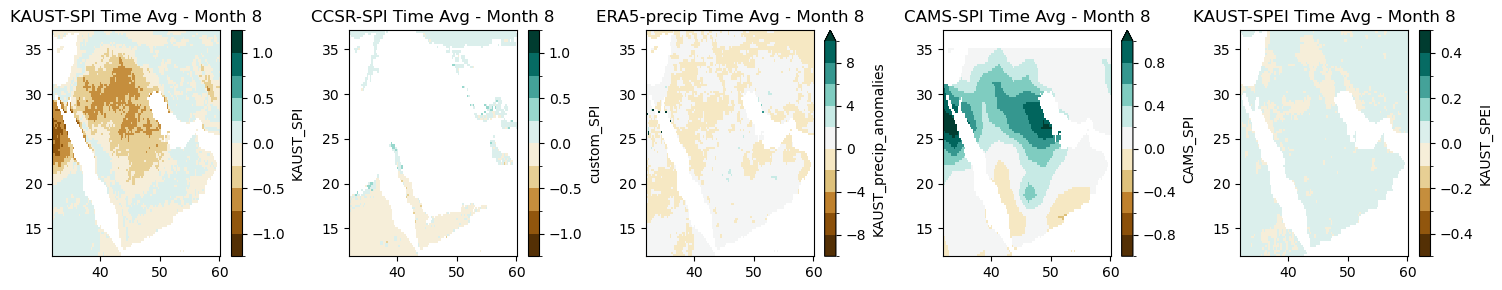

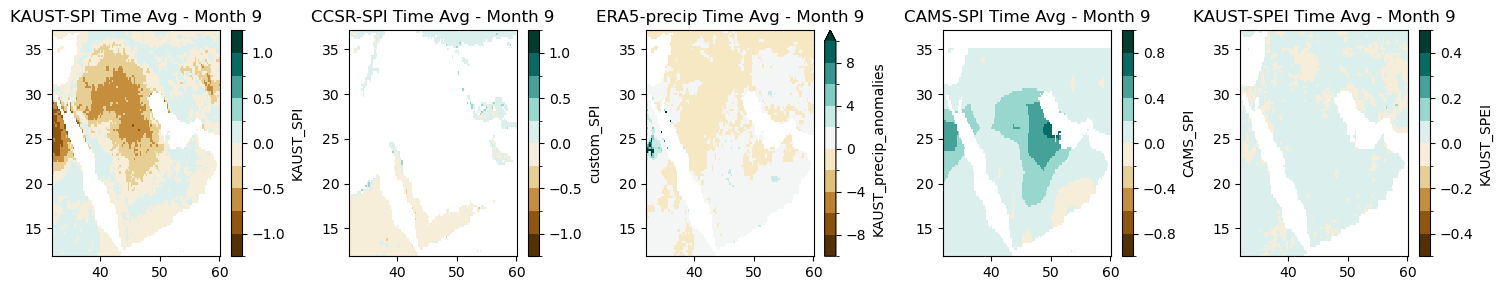

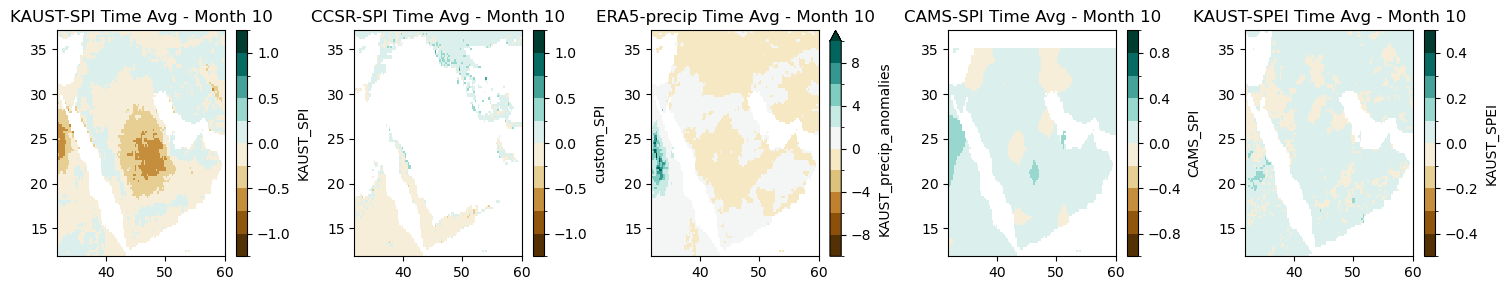

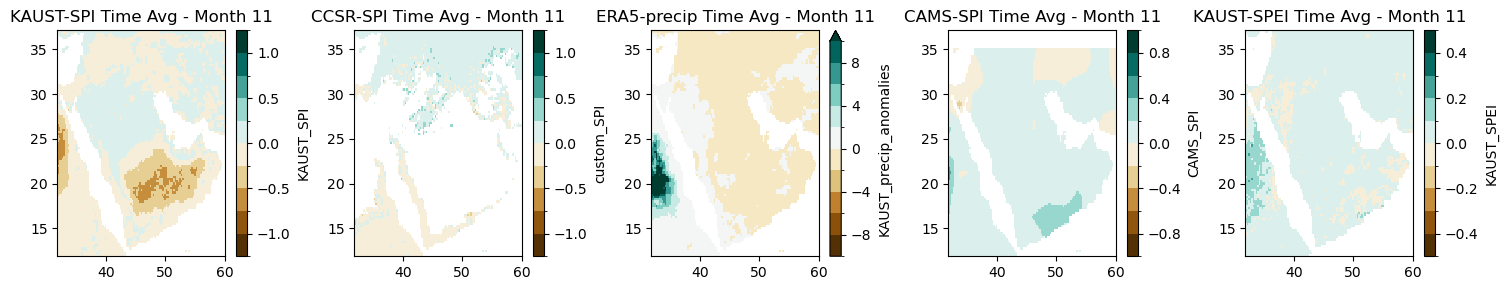

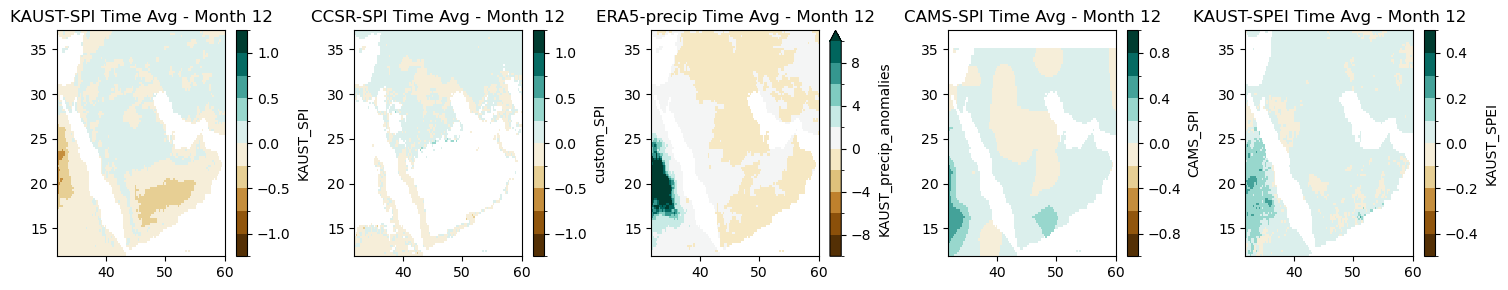

In [25]:

# Loop over each month
for month in range(1, 13):
    if data['T'].dtype != 'datetime64[ns]':
        data['T'] = pd.to_datetime(data['T'].values, format='%m-%Y')
    # Select the data for the specific month
    data_month = data.where(data['T'].dt.month == month, drop=True)
    
    # Compute the time averages for each variable over the time dimension (T)
    kaust_time_avg = data_month['KAUST_SPI'].mean(dim='T')
    cams_time_avg = data_month['CAMS_SPI'].mean(dim='T')
    opi_time_avg = data_month['CAMS_precip'].mean(dim='T')
    era5_time_avg = data_month['KAUST_precip_anomalies'].mean(dim='T')
    custom_time_avg = data_month['custom_SPI'].mean(dim='T')
    spei_time_avg = data_month['KAUST_SPEI'].mean(dim='T')

    # #label values below -0.5 as 1, below -2 as 2, rest as 0
    # kaust_time_avg = xr.where(kaust_time_avg < -2, 2, xr.where(kaust_time_avg < -0.5, 1, 0))
    # cams_time_avg = xr.where(cams_time_avg < -2, 2, xr.where(cams_time_avg < -0.5, 1, 0))
    
    # Plot the time averages for each month in the respective subplot
    row, col = (month-1)//4, (month-1)%4
    # Create a figure with 3 subplots (one row, three columns for each month)
    fig, axs_month = plt.subplots(1, 5, figsize=(15, 3))
    # Plot KAUST
    kaust_time_avg.plot(ax=axs_month[0], cmap='BrBG',levels=11, vmin=-1.25, vmax=1.25)
    axs_month[0].set_title(f'KAUST-SPI Time Avg - Month {month}')

    #Plot Custom
    custom_time_avg.plot(ax=axs_month[1], cmap='BrBG',levels=11, vmin=-1.25, vmax=1.25)
    axs_month[1].set_title(f'CCSR-SPI Time Avg - Month {month}')
    # Plot ERA5
    era5_time_avg.plot(ax=axs_month[2], cmap='BrBG', vmin=-10, vmax=10, levels=11)
    axs_month[2].set_title(f'ERA5-precip Time Avg - Month {month}')
    # Plot CAMS
    cams_time_avg.plot(ax=axs_month[3], cmap='BrBG', levels=11, vmin=-1., vmax=1.)
    axs_month[3].set_title(f'CAMS-SPI Time Avg - Month {month}')
    # Plot OPI
    spei_time_avg.plot(ax=axs_month[4], cmap='BrBG', vmin=-0.5, vmax=0.5, levels=11)
    axs_month[4].set_title(f'KAUST-SPEI Time Avg - Month {month}')

    #remove X and Y labels
    for ax in axs_month.flat:
        ax.set(xlabel='', ylabel='')
    plt.tight_layout()
    plt.show()

# Trend

In [27]:
# Prepare an array to store the trends for all grid points
months = np.arange(1, 13)
opi_trend = np.zeros((months.size, data.Y.size, data.X.size))
kaust_trend = np.zeros((months.size, data.Y.size, data.X.size))
cams_trend = np.zeros((months.size, data.Y.size, data.X.size))
era5_trend = np.zeros((months.size, data.Y.size, data.X.size))
custom_trend = np.zeros((months.size, data.Y.size, data.X.size))

data_trend = data.sel(T=slice('01-1979', None))

# Loop over each month
for month in months:
    print(month)
    data_month = data_trend.where(data['T'].dt.month == month, drop=True)
    
    # Loop over all grid points to compute the trend
    for i, j in itertools.product(range(data.Y.size), range(data.X.size)):
            # Extract time series for each variable at this grid point
            opi_series = data_month['CAMS_precip'][:, i, j].values
            kaust_series = data_month['KAUST_SPI'][:, i, j].values
            cams_series = data_month['CAMS_SPI'][:, i, j].values
            era5_series = data_month['KAUST_precip_anomalies'][:, i, j].values
            custom_series = data_month['custom_SPI'][:, i, j].values
            
            # Compute the time index (e.g., 0, 1, 2, ..., N-1)
            time_index = np.arange(len(opi_series))

            # Check if there are enough valid data points to compute trend
            if not np.isnan(opi_series).any() and len(opi_series) > 1:
                # Fit a linear polynomial to the OPI time series
                trend_coeff = np.polyfit(time_index[~np.isnan(opi_series)], opi_series[~np.isnan(opi_series)], 1)
                opi_trend[month-1, i, j] = trend_coeff[0]  # Store the slope

            if not np.isnan(kaust_series).any() and len(kaust_series) > 1:
                trend_coeff = np.polyfit(time_index[~np.isnan(kaust_series)], kaust_series[~np.isnan(kaust_series)], 1)
                kaust_trend[month-1, i, j] = trend_coeff[0]  # Store the slope

            if not np.isnan(cams_series).any() and len(cams_series) > 1:
                trend_coeff = np.polyfit(time_index[~np.isnan(cams_series)], cams_series[~np.isnan(cams_series)], 1)
                cams_trend[month-1, i, j] = trend_coeff[0]  # Store the slope

            if not np.isnan(era5_series).any() and len(era5_series) > 1:
                trend_coeff = np.polyfit(time_index[~np.isnan(era5_series)], era5_series[~np.isnan(era5_series)], 1)
                era5_trend[month-1, i, j] = trend_coeff[0]

            if not np.isnan(custom_series).any() and len(custom_series) > 1:
                trend_coeff = np.polyfit(time_index[~np.isnan(custom_series)], custom_series[~np.isnan(custom_series)], 1)
                custom_trend[month-1, i, j] = trend_coeff[0]
                

# Convert trends to xarray DataArray
opi_trend_da = xr.DataArray(opi_trend, coords=[months, data.Y, data.X], dims=["T", "Y", "X"], name="OPI Trend")
kaust_trend_da = xr.DataArray(kaust_trend, coords=[months, data.Y, data.X], dims=["T", "Y", "X"], name="KAUST Trend")
cams_trend_da = xr.DataArray(cams_trend, coords=[months, data.Y, data.X], dims=["T", "Y", "X"], name="CAMS Trend")
era5_trend_da = xr.DataArray(era5_trend, coords=[months, data.Y, data.X], dims=["T", "Y", "X"], name="ERA5 Trend")
custom_trend_da = xr.DataArray(custom_trend, coords=[months, data.Y, data.X], dims=["T", "Y", "X"], name="Custom SPI Trend")

# Create a dataset to hold all trends
trends_ds = xr.Dataset({
    'OPI_Trend': opi_trend_da,
    'KAUST_Trend': kaust_trend_da,
    'CAMS_Trend': cams_trend_da,
    'ERA5_Trend': era5_trend_da,
    'Custom_Trend': custom_trend_da
})


1
2
3
4
5
6
7
8
9
10
11
12


Text(0.5, 0.98, 'CAMS SPI Trends')

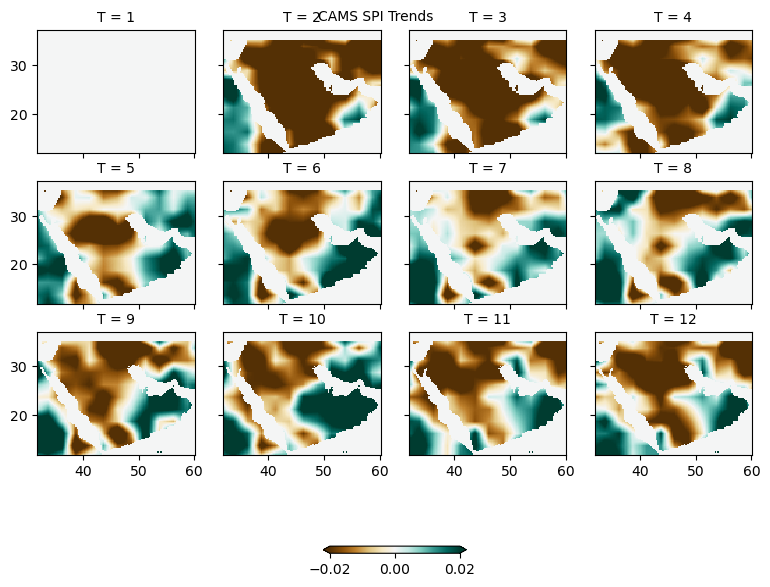

In [28]:
cams_trend_da.plot(col='T', col_wrap=4, cmap='BrBG', vmin=-0.02, vmax=0.02, figsize=(8, 7),cbar_kwargs={'shrink': 0.2, 'label': 'Trend', 'orientation': 'horizontal'})
#remove X and Y labels
for ax in plt.gcf().axes:
    ax.set(xlabel='', ylabel='')
plt.suptitle('CAMS SPI Trends', fontsize=10)

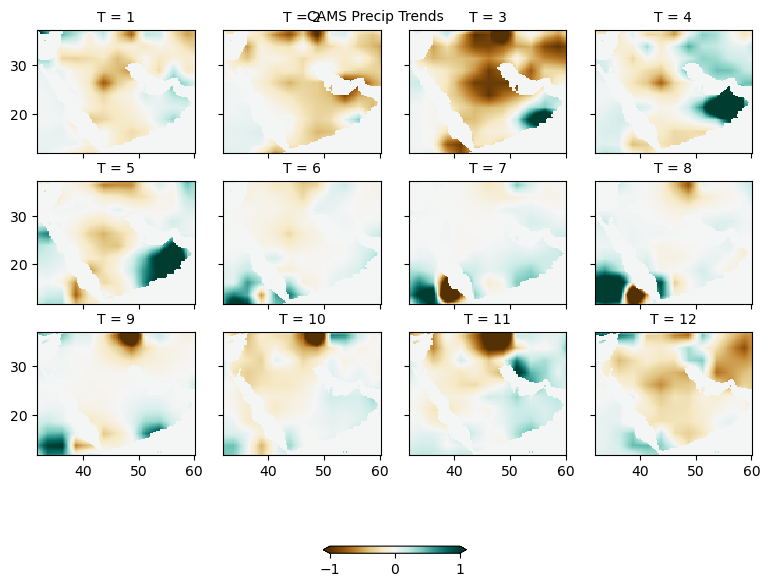

In [29]:
opi_trend_da.plot(col='T', col_wrap=4, cmap='BrBG', vmin=-1, vmax=1, figsize=(8, 7),cbar_kwargs={'label': 'Trend', 'orientation': 'horizontal','shrink': 0.2})
plt.suptitle('CAMS Precip Trends', fontsize=10)
#remove X and Y labels
for ax in plt.gcf().axes:
    ax.set(xlabel='', ylabel='')
#plt.tight_layout()


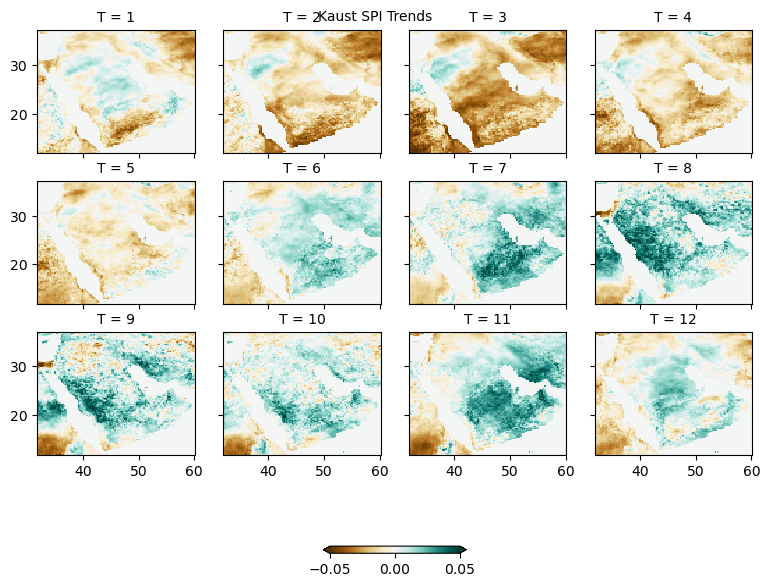

In [30]:
kaust_trend_da.plot(col='T', col_wrap=4, cmap='BrBG', vmin=-0.05, vmax=0.05, figsize=(8, 7),cbar_kwargs={'label': 'Trend', 'orientation': 'horizontal','shrink': 0.2})
plt.suptitle('Kaust SPI Trends', fontsize=10)
#remove X and Y labels
for ax in plt.gcf().axes:
    ax.set(xlabel='', ylabel='')


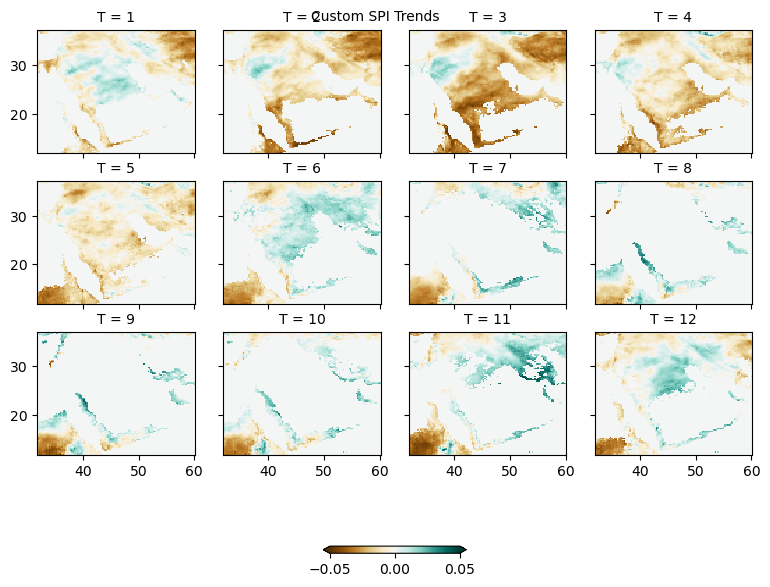

In [31]:
custom_trend_da.plot(col='T', col_wrap=4, cmap='BrBG', vmin=-0.05, vmax=0.05, figsize=(8, 7),cbar_kwargs={'label': 'Trend', 'orientation': 'horizontal','shrink': 0.2})
plt.suptitle('Custom SPI Trends', fontsize=10)
#remove X and Y labels
for ax in plt.gcf().axes:
    ax.set(xlabel='', ylabel='')

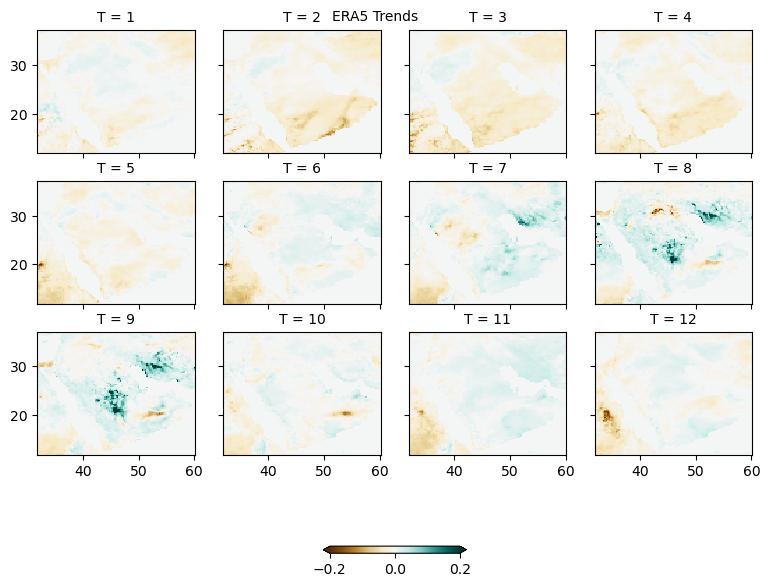

In [32]:
era5_trend_da.plot(col='T', col_wrap=4, vmin=-0.2, vmax=0.2, figsize=(8,7), cmap='BrBG',
                   cbar_kwargs={'shrink': 0.2, 'label': 'Trend', 'orientation': 'horizontal'})
plt.suptitle('ERA5 Trends', fontsize=10)
#remove X and Y labels
for ax in plt.gcf().axes:
    ax.set(xlabel='', ylabel='')

Text(0.5, 1.0, 'Mean Trend per month')

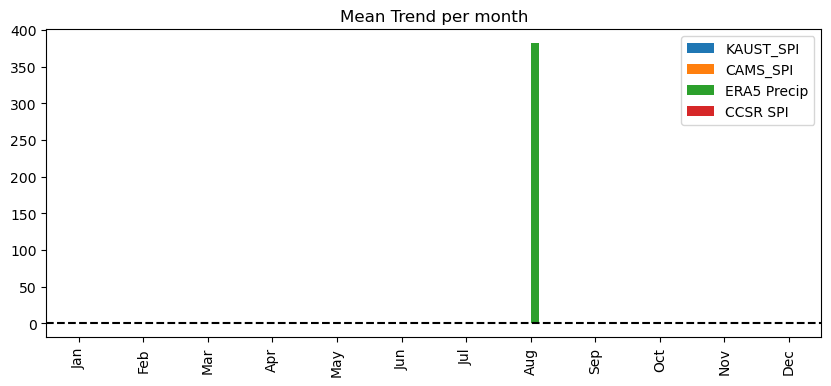

In [33]:
kaust_trend_mean = kaust_trend_da.mean(dim=['Y', 'X'])
cams_trend_mean = cams_trend_da.mean(dim=['Y', 'X'])
opi_trend_mean = opi_trend_da.mean(dim=['Y', 'X'])
era5_trend_mean = era5_trend_da.mean(dim=['Y', 'X'])/10
custom_trend_mean = custom_trend_da.mean(dim=['Y', 'X'])

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 4))


trend_df = pd.DataFrame({'KAUST_SPI': kaust_trend_mean, 'CAMS_SPI': cams_trend_mean, 'ERA5 Precip': era5_trend_mean, 'CCSR SPI': custom_trend_mean})
trend_df.plot(kind='bar', ax=ax)
#horizontal line at 0
#map x ticks to months strings
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.title('Mean Trend per month')

# Quantiles

In [34]:
#print the median 10th 90th percentile for each variable
print('Quantiles overall (10% - 50% - 90%)')
print('KAUST SPI: ',data['KAUST_SPI'].quantile([0.1, 0.5, 0.9]).values)
print('CAMS SPI: ',data['CAMS_SPI'].quantile([0.1, 0.5, 0.9]).values)
print('OPI Precip: ',data['CAMS_precip'].quantile([0.1, 0.5, 0.9]).values)
print('ERA5 Precip: ',data['KAUST_precip_anomalies'].quantile([0.1, 0.5, 0.9]).values)
print('CCSR SPI: ',data['custom_SPI'].quantile([0.1, 0.5, 0.9]).values)
print('KAUST SPEI: ',data['KAUST_SPEI'].quantile([0.1, 0.5, 0.9]).values)



Quantiles overall (10% - 50% - 90%)
KAUST SPI:  [-1.4889015   0.06282203  1.24167728]
CAMS SPI:  [-1.03938003  0.0998967   1.19462714]
OPI Precip:  [-10.63152275  -0.91086239  14.77572594]
ERA5 Precip:  [-0.90639845 -0.30589496  1.53469479]
CCSR SPI:  [-1.23637415 -0.00795641  1.2640493 ]
KAUST SPEI:  [-1.27169207  0.          1.31605548]


In [35]:
#label values below -0.5 as 1, below -2 as 2, rest as 0 keep nans
kaust_labeled = xr.where(data['KAUST_SPI'] < -1.5, 2, xr.where(data['KAUST_SPI'] < -0.5, 1, xr.where(np.isnan(data['KAUST_SPI']), np.nan, 0)))
cams_labeled = xr.where(data['CAMS_SPI'] < -1.5, 2, xr.where(data['CAMS_SPI'] < -0.5, 1, xr.where(np.isnan(data['CAMS_SPI']), np.nan, 0)))
custom_labeled = xr.where(data['custom_SPI'] < -1.5, 2, xr.where(data['custom_SPI'] < -0.5, 1, xr.where(np.isnan(data['custom_SPI']), np.nan, 0)))
data_labeled = xr.Dataset({'KAUST': kaust_labeled, 'CAMS': cams_labeled, 'Custom': custom_labeled})

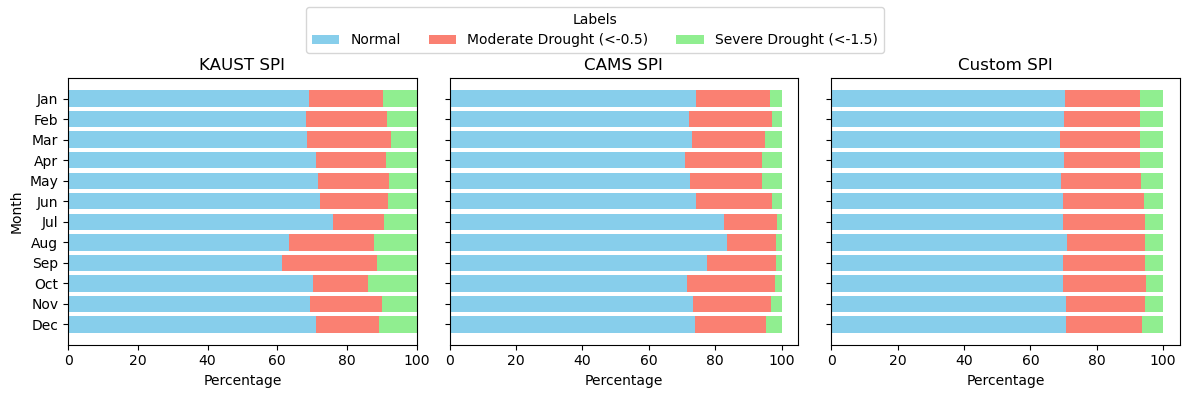

In [36]:
# Initialize lists to store results
months = np.arange(1, 13)  # Array of months from 1 to 12

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# Loop over the two variables 'KAUST' and 'CAMS' and generate the plots
for idx, var in enumerate(['KAUST', 'CAMS','Custom']):
    percentage_0 = []
    percentage_1 = []
    percentage_2 = []

    data_var = data_labeled[var]
    
    # Loop through each month and calculate label distribution
    for month in months:
        if data_var['T'].dtype != 'datetime64[ns]':
            data_var['T'] = pd.to_datetime(data_var['T'].values, format='%m-%Y')
        # Select the data for the specific month
        data_month = data_var.where(data_var['T'].dt.month == month, drop=True)
        flattened_data = data_month.values.flatten()
        flattened_data = flattened_data[~np.isnan(flattened_data)]
        
        # Count occurrences of each label
        total = len(flattened_data)
        count_0 = np.sum(flattened_data == 0)
        count_1 = np.sum(flattened_data == 1)
        count_2 = np.sum(flattened_data == 2)
        
        # Calculate percentage
        percent_0 = (count_0 / total) * 100 if total > 0 else 0
        percent_1 = (count_1 / total) * 100 if total > 0 else 0
        percent_2 = (count_2 / total) * 100 if total > 0 else 0
        
        # Store the results
        percentage_0.append(percent_0)
        percentage_1.append(percent_1)
        percentage_2.append(percent_2)

    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        'Month': months,
        '0': percentage_0,
        '1': percentage_1,
        '2': percentage_2
    })

    #normalize percentages
    df['0'] = (df['0'] / (df['0'] + df['1'] + df['2'])) * 100
    df['1'] = df['1'] / (df['0'] + df['1'] + df['2']) * 100
    df['2'] = df['2'] / (df['0'] + df['1'] + df['2']) * 100

    # Plotting the horizontal stacked bar chart
    ax = axes[idx]
    
    # Create stacked bar chart
    ax.barh(df['Month'], df['0'], color='skyblue', label='0')
    ax.barh(df['Month'], df['1'], left=df['0'], color='salmon', label='1')
    ax.barh(df['Month'], df['2'], left=df['0'] + df['1'], color='lightgreen', label='2')

    # Set labels and title
    ax.set_xlabel('Percentage')
    ax.set_ylabel('Month' if idx == 0 else '')  # Only set y-label for the first subplot

# Add a common legend for both plots
handles, labels = ax.get_legend_handles_labels()
#change label legend to string
labels = ['Normal', 'Moderate Drought (<-0.5)', 'Severe Drought (<-1.5)']
fig.legend(handles, labels, loc='upper center', title='Labels', ncol=3)
#tick every month
ax.set_yticks(months)
#y axis months string
axes[0].set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# x-axis 0-100
axes[0].set_xlim(0, 100)
#reverse y axis
axes[0].invert_yaxis()
#set titles
axes[0].set_title('KAUST SPI')
axes[1].set_title('CAMS SPI')
axes[2].set_title('Custom SPI')
# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.9])


# Show plot
plt.show()

# Indices - NINO NAO DMI

In [100]:
nino = pd.read_table('data/nino.txt', delim_whitespace=True)
#create a datetime index from columns YR and MON
nino['T'] = pd.to_datetime(nino['YR'].astype(str) + '-' + nino['MON'].astype(str))
nino['NINO3.4_3m'] = nino['NINO3.4'].rolling(window=3).sum()
#fill na with columns NINO3.4
nino['NINO3.4_3m'].fillna(nino['NINO3.4'], inplace=True)
nino = nino[nino['T'].dt.year >= 1951]
#add to data xarray with X and Y as coordinates 
nino_xr = xr.Dataset({'NINO': ('T', nino['NINO3.4_3m'].values)}, coords={'T': nino['T']})
data = xr.merge([data, nino_xr])

C:\Users\emile\AppData\Local\Temp\ipykernel_12856\827231391.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  nino = pd.read_table('data/nino.txt', delim_whitespace=True)
C:\Users\emile\AppData\Local\Temp\ipykernel_12856\827231391.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nino['NINO3.4_3m'].fillna(nino['NINO3.4'], inplace=True)


In [101]:
nao = pd.read_table('data/nao.txt', delim_whitespace=True,header=None)
nao['YR'] = nao[0]
nao['MON'] = nao[1]
nao['nao'] = nao[2]
#create a datetime index from columns YR and MON
nao['T'] = pd.to_datetime(nao['YR'].astype(str) + '-' + nao['MON'].astype(str))
nao['nao_3m'] = nao['nao'].rolling(window=3).sum()
#fill na with columns nao3.4
nao['nao_3m'].fillna(nao['nao'], inplace=True)
nao = nao[nao['T'].dt.year >= 1951]
#stop at 08-2024
nao = nao[nao['T'] <= '2024-08-01']
#add to data xarray with X and Y as coordinates 
nao_xr = xr.Dataset({'NAO': ('T', nao['nao_3m'].values)}, coords={'T': nao['T']})
data = xr.merge([data, nao_xr])

C:\Users\emile\AppData\Local\Temp\ipykernel_12856\1584988834.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  nao = pd.read_table('data/nao.txt', delim_whitespace=True,header=None)
C:\Users\emile\AppData\Local\Temp\ipykernel_12856\1584988834.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nao['nao_3m'].fillna(nao['nao'], inplace=True)


In [102]:
dmi = pd.read_table('data/DMI.txt', delim_whitespace=True)

# #create a datetime index from columns YR and MON
dmi['T'] = pd.to_datetime(dmi['Year'].astype(str) + '-' + dmi['Month'].astype(str))
dmi['DMI_3m'] = dmi['DMI'].rolling(window=3).sum()
# #fill na with columns dmi3.4
dmi['DMI_3m'].fillna(dmi['DMI_3m'], inplace=True)
dmi = dmi[dmi['T'].dt.year >= 1951]
# #stop at 08-2024
dmi = dmi[dmi['T'] <= '2024-08-01']
# #add to data xarray with X and Y as coordinates 
dmi_xr = xr.Dataset({'DMI': ('T', dmi['DMI_3m'].values)}, coords={'T': dmi['T']})
data = xr.merge([data, dmi_xr])


C:\Users\emile\AppData\Local\Temp\ipykernel_12856\3628167305.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dmi = pd.read_table('data/DMI.txt', delim_whitespace=True)


## SPI PC correlation

In [104]:
def compute_pc_correlation(data, index, n_pcs=2):
    """
    Computes the correlation between PC1 of SPI and the index for every month,
    and generates a 3x4 panel plot for all months.
    """
    data = data.transpose('T', 'Y', 'X')
    months = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
    spi = data['custom_SPI']

    fig, axes = plt.subplots(3, 4, figsize=(15, 10), constrained_layout=True)
    axes = axes.ravel()  # Flatten the 3x4 axes for easy indexing

    for i, month in enumerate(months):
        month_num = i + 1
        month_string = months[i]
        
        # Select data for the current month
        spi_month = spi.sel(T=spi['T.month'] == month_num)
        spi_month = (spi_month - spi_month.mean(dim='T')) / (spi_month.std(dim='T') + 1e-6)
        spi_2d = spi_month.fillna(0).values.reshape(spi_month.shape[0], -1)

        # PCA on SPI data
        spi_pca = PCA(n_components=n_pcs).fit(spi_2d)
        spi_pcs = spi_pca.transform(spi_2d)
        spi_explained_var = spi_pca.explained_variance_ratio_
        spi_times = spi_month['T'].values

        # Select the index data for the current month
        index_data = data[index].sel(T=data[index]['T.month'] == month_num)
        
        # Normalize PC1 and the index data
        spi_pc1 = spi_pcs[:, 0]
        spi_pc1 = (spi_pc1 - spi_pc1.mean()) / (spi_pc1.std()+1e-6)
        index_data = (index_data - index_data.mean()) / (index_data.std()+1e-6)

        # Compute correlation
        corr_pc1 = np.corrcoef(spi_pc1, index_data.values)[0, 1]

        # Plot for the current month
        ax = axes[i]
        ax.plot(spi_times, spi_pc1, label='PC1', color='blue')
        ax.plot(spi_times, index_data, label=index, color='red')
        ax.set_title(f'{month_string}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Normalized values')
        ax.legend(loc='upper right')
        ax.grid()
        ax.text(0.1, 0.9, f'Corr: {corr_pc1:.2f}', transform=ax.transAxes, fontsize=9)
        ax.text(0.1, 0.8, f'Expl Var: {spi_explained_var[0]:.2f}', transform=ax.transAxes, fontsize=9)

    # Set a global title for the figure
    fig.suptitle(f'PC1 vs {index}', fontsize=16)
    plt.show()

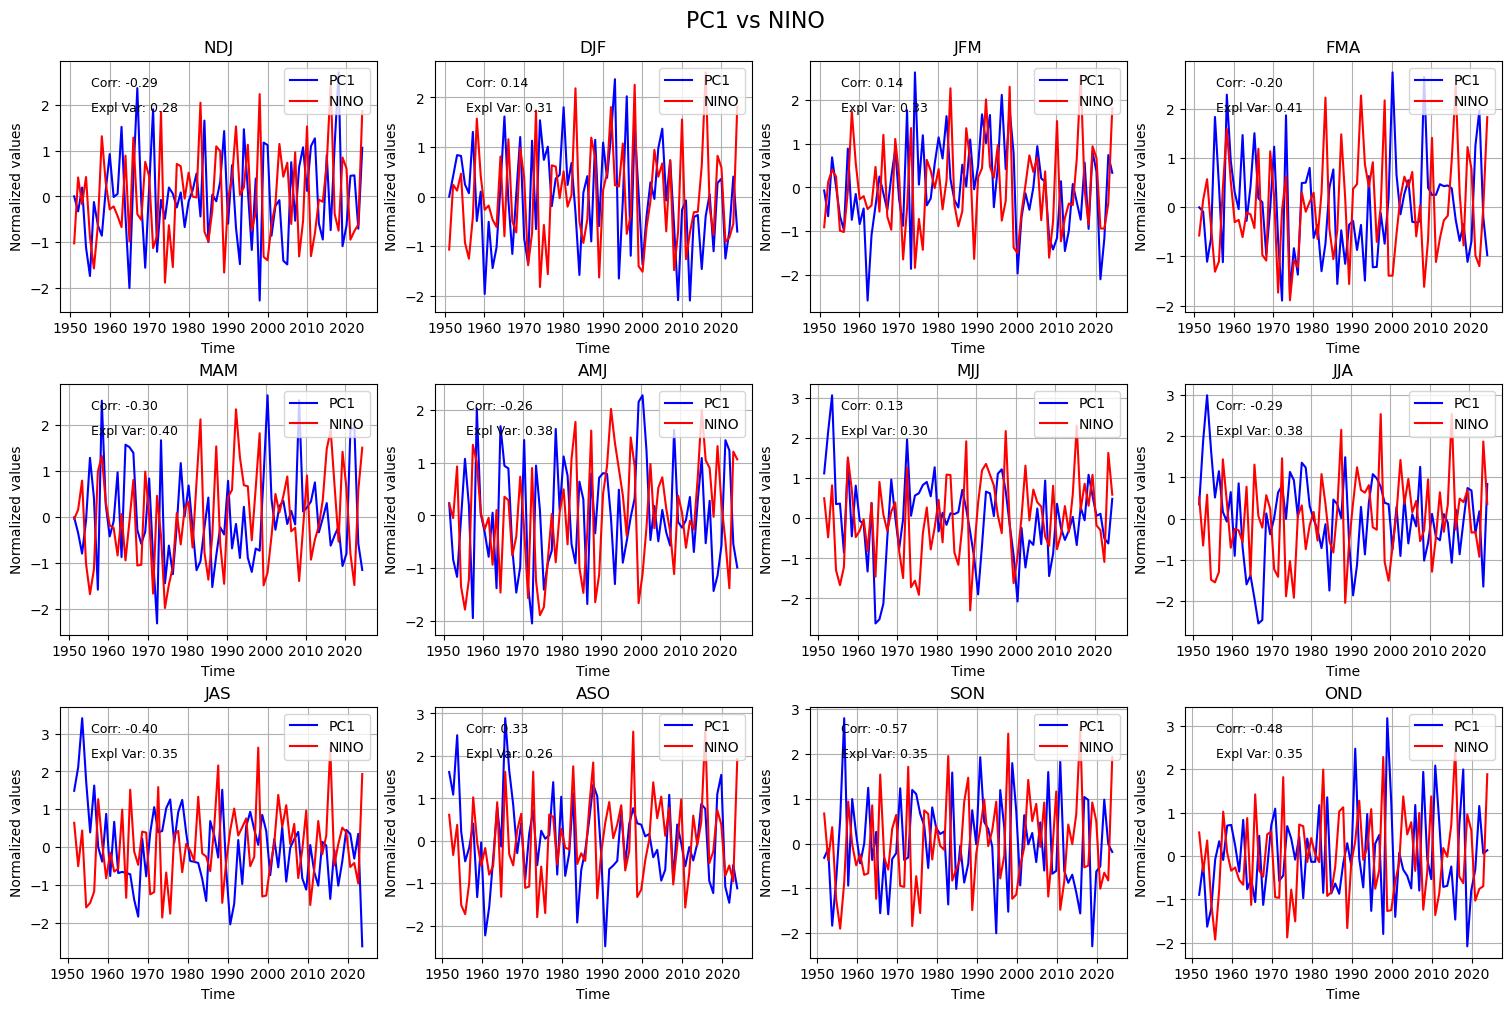

In [105]:
compute_pc_correlation(data, 'NINO')

In [116]:
def compute_correlation_summary(data, indices, n_pcs=2,pc=1):
    """
    Computes the correlation coefficients between PC1 of SPI and multiple indices for each period
    and generates a single line plot for the correlations.
    
    Parameters:
        data (xarray.Dataset): The dataset containing SPI and indices.
        indices (list of str): List of index variable names in the dataset.
        n_pcs (int): Number of principal components to retain in PCA (default is 2).
    """
    data = data.transpose('T', 'Y', 'X')
    months = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
    spi = data['custom_SPI']

    # Initialize a dictionary to store correlations for each index
    correlations = {index: [] for index in indices}

    for i, month in enumerate(months):
        month_num = i + 1
        spi_month = spi.sel(T=spi['T.month'] == month_num)
        spi_month = (spi_month - spi_month.mean(dim='T')) / (spi_month.std(dim='T') + 1e-6)
        spi_2d = spi_month.fillna(0).values.reshape(spi_month.shape[0], -1)

        # PCA on SPI data
        spi_pca = PCA(n_components=n_pcs).fit(spi_2d)
        spi_pc1 = spi_pca.transform(spi_2d)[:, pc-1]

        # Normalize PC1
        spi_pc1 = (spi_pc1 - spi_pc1.mean()) / spi_pc1.std()

        for index in indices:
            index_data = data[index].sel(T=data[index]['T.month'] == month_num)
            # Normalize the index data
            index_data = (index_data - index_data.mean()) / index_data.std()
            
            # Compute correlation between PC1 and the index
            corr_pc1 = np.corrcoef(spi_pc1, index_data.values)[0, 1]
            correlations[index].append(corr_pc1)

    # Plot the correlations for all indices
    plt.figure(figsize=(6, 4))
    for index in indices:
        plt.plot(months, correlations[index], label=index,marker='o')

    plt.title(f'Correlation of PC{pc} with Indices Across Periods')
    plt.xlabel('Period')
    plt.ylabel('Correlation Coefficient')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

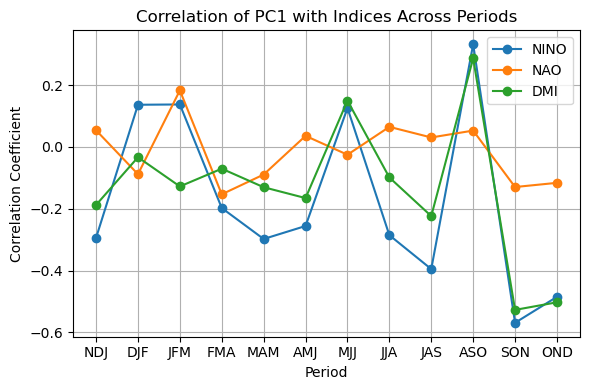

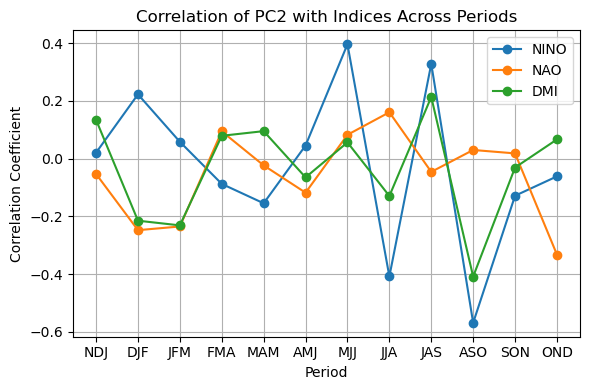

In [117]:
compute_correlation_summary(data, ['NINO', 'NAO', 'DMI'],pc=1)
compute_correlation_summary(data, ['NINO', 'NAO', 'DMI'],pc=2)

## Partial Correlations

In [40]:
def compute_gridwise_correlation(data, var1, var2, var3, var4, corr_type='partial'):


    def compute_first_order_partial_corr(corr_xy, corr_xz, corr_yz):
        numerator = corr_xy - corr_xz * corr_yz
        denominator = np.sqrt((1 - corr_xz**2) * (1 - corr_yz**2))
        return numerator / denominator

    def compute_second_order_partial_corr(corr_xy_z, corr_xz_y, corr_yz_x):
        numerator = corr_xy_z - corr_xz_y * corr_yz_x
        denominator = np.sqrt((1 - corr_xz_y**2) * (1 - corr_yz_x**2))
        return numerator / denominator

    # Ensure the time coordinate is in datetime format and extract the month
    if data['T'].dtype != 'datetime64[ns]':
        data['T'] = pd.to_datetime(data['T'].values, format='%m-%Y')
    months = data['T'].dt.month


    # Prepare an empty dataset to store the correlations for each month
    corr_ds = xr.Dataset()
    # Loop over each month
    for month in range(1, 13):  # Months 1 to 12
        # Select data for the specific month
        monthly_data = data.where(months == month, drop=True)

        # Compute correlations for each pair of variables using xarray's corr method
        corr1_4 = xr.corr(monthly_data[var1], monthly_data[var4], dim='T').assign_coords(X=monthly_data.X, Y=monthly_data.Y)
        corr2_4 = xr.corr(monthly_data[var2], monthly_data[var4], dim='T').assign_coords(X=monthly_data.X, Y=monthly_data.Y)
        corr3_4 = xr.corr(monthly_data[var3], monthly_data[var4], dim='T').assign_coords(X=monthly_data.X, Y=monthly_data.Y)

        corr1_2 = xr.corr(monthly_data[var1], monthly_data[var2], dim='T')
        corr1_3 = xr.corr(monthly_data[var1], monthly_data[var3], dim='T')
        corr2_3 = xr.corr(monthly_data[var2], monthly_data[var3], dim='T')

        # First-order partial correlations
        corr_1_4_2 = compute_first_order_partial_corr(corr1_4, corr1_2, corr2_4)
        corr_1_4_3 = compute_first_order_partial_corr(corr1_4, corr1_3, corr3_4)
        corr_2_4_3 = compute_first_order_partial_corr(corr2_4, corr2_3, corr3_4)
        corr_1_3_2 = compute_first_order_partial_corr(corr1_3, corr1_2, corr2_3)
        corr_3_4_2 = compute_first_order_partial_corr(corr3_4, corr2_3, corr3_4)
        corr_2_4_1 = compute_first_order_partial_corr(corr2_4, corr1_2, corr2_3)
        corr_2_3_1 = compute_first_order_partial_corr(corr2_3, corr1_2, corr2_3)

        # Second-order partial correlations
        corr_1_4_2_3 = compute_second_order_partial_corr(corr_1_4_2, corr_1_3_2, corr_3_4_2)
        corr_2_4_1_3 = compute_second_order_partial_corr(corr_2_4_1, corr_2_3_1, corr_3_4_2)
        corr_3_4_1_2 = compute_second_order_partial_corr(corr_1_4_3, corr_1_3_2, corr_2_4_1)



        # Store the correlation results in the dataset using X and Y coordinates from the first variable
        if corr_type=='partial':
            corr_ds[f'corr_{var1}_{var4}_month_{month}'] = corr_1_4_2_3
            corr_ds[f'corr_{var2}_{var4}_month_{month}'] = corr_2_4_1_3
            corr_ds[f'corr_{var3}_{var4}_month_{month}'] = corr_3_4_1_2
        else:
            corr_ds[f'corr_{var1}_{var4}_month_{month}'] = corr1_4
            corr_ds[f'corr_{var2}_{var4}_month_{month}'] = corr2_4
            corr_ds[f'corr_{var3}_{var4}_month_{month}'] = corr3_4

    return corr_ds


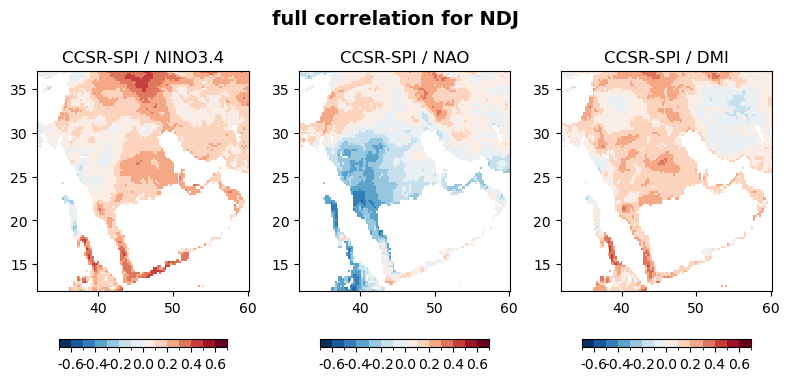

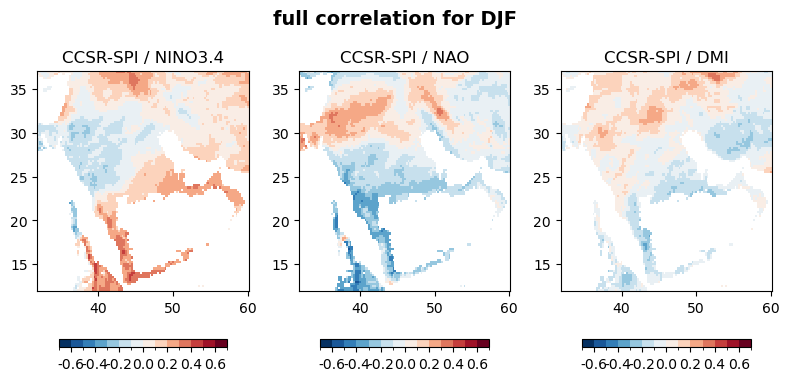

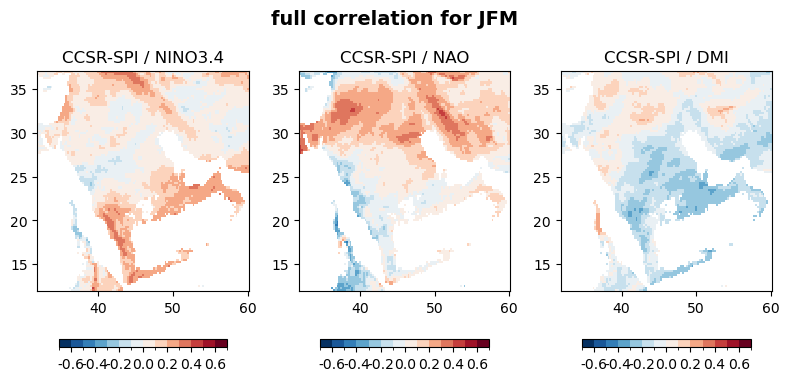

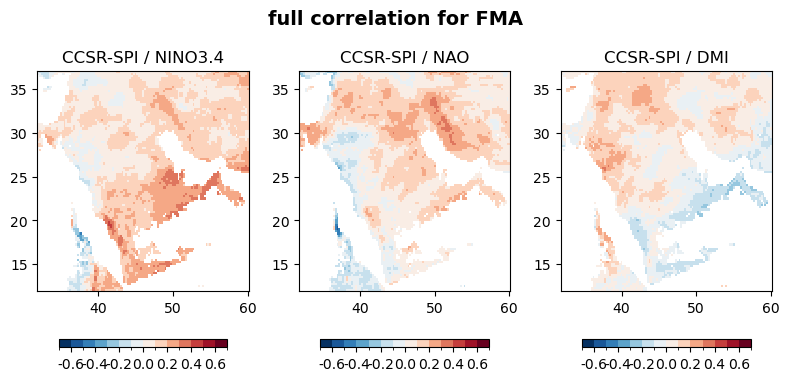

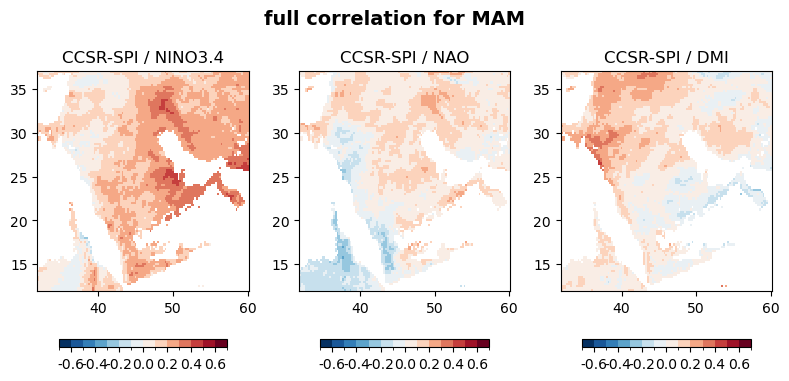

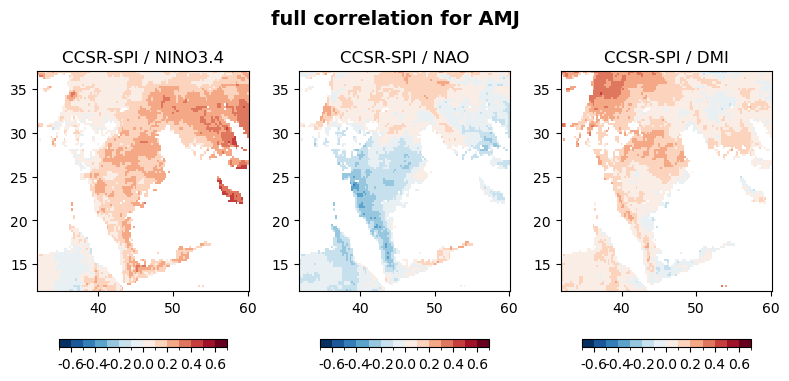

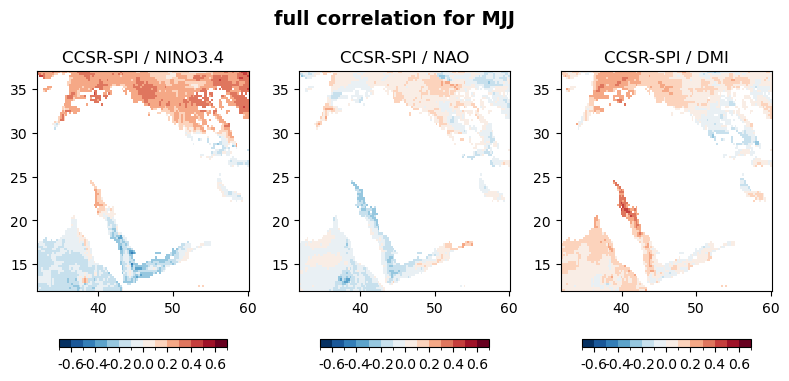

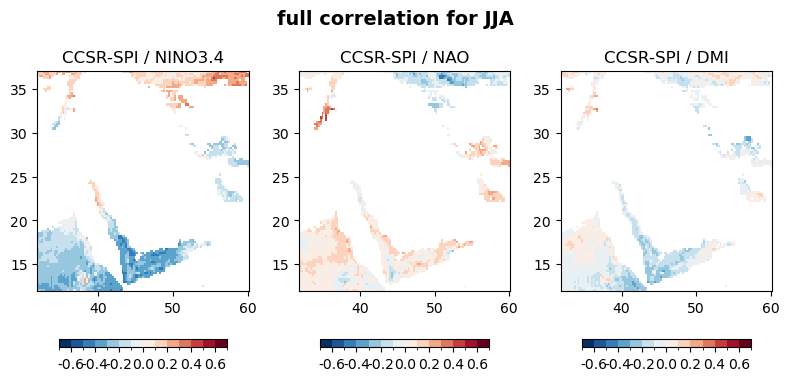

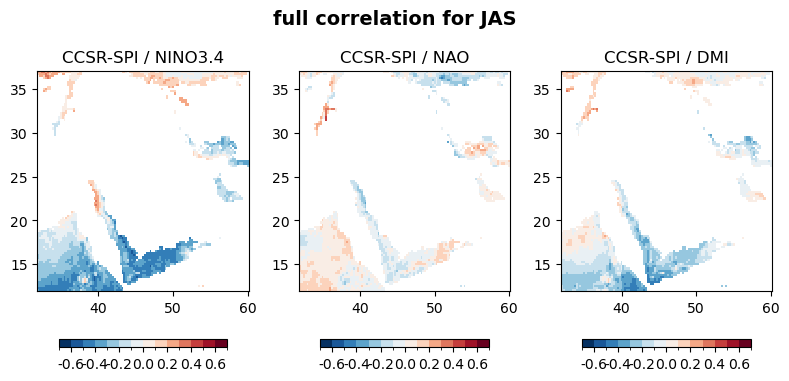

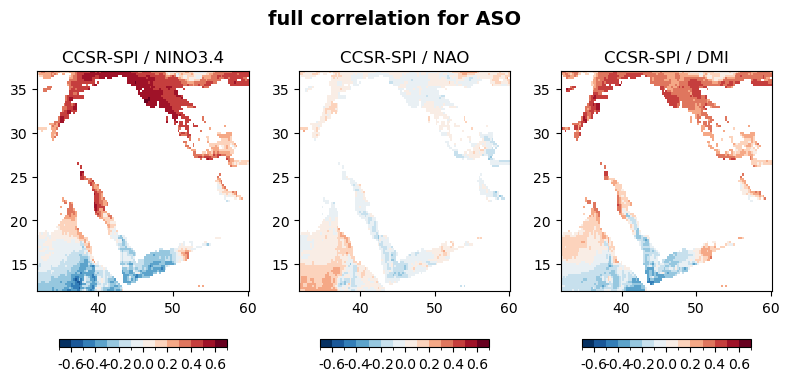

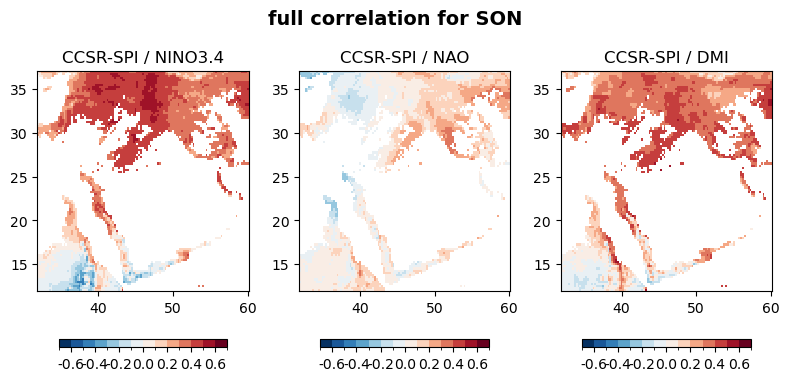

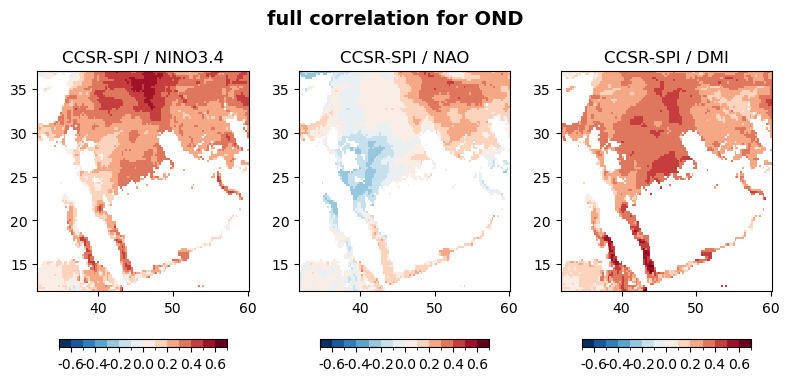

In [41]:
corr_type = 'full'
# Compute the gridwise correlation between KAUST, CAMS, and SPI
corr_ds = compute_gridwise_correlation(data, 'NAO', 'NINO', 'DMI', 'custom_SPI',corr_type=corr_type)
levels = [-0.8,-0.6,-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.8]

cbar_kwargs = {'shrink': 0.8, 'label': '', 'orientation': 'horizontal','format':'%.1f'}
# Plot the gridwise correlation for each month (var1 vs var2)
for month in range(1, 13):
    month_names = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
    month_name = month_names[month - 1]
    plt.figure(figsize=(8, 4))

    # Plot correlation between KAUST and CAMS
    plt.subplot(1, 3, 1)
    corr_map = corr_ds[f'corr_NINO_custom_SPI_month_{month}']
    corr_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NINO3.4')

    # Plot correlation between KAUST and SPI
    plt.subplot(1, 3, 2)
    corr_map = corr_ds[f'corr_NAO_custom_SPI_month_{month}']
    corr_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NAO')

    # # Plot correlation between CAMS and SPI
    plt.subplot(1, 3, 3)
    corr_map = corr_ds[f'corr_DMI_custom_SPI_month_{month}']
    corr_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / DMI')

    for ax in plt.gcf().axes:
        ax.set(xlabel='', ylabel='')
    plt.suptitle(f'{corr_type} correlation for {month_name}', fontsize=14,fontweight='bold')
    plt.tight_layout()
    plt.show()

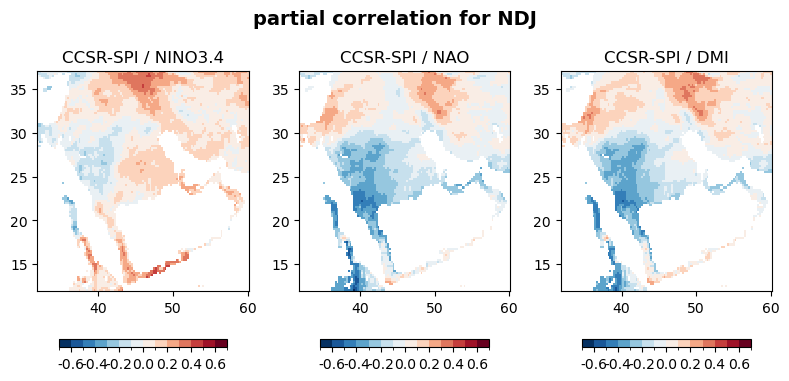

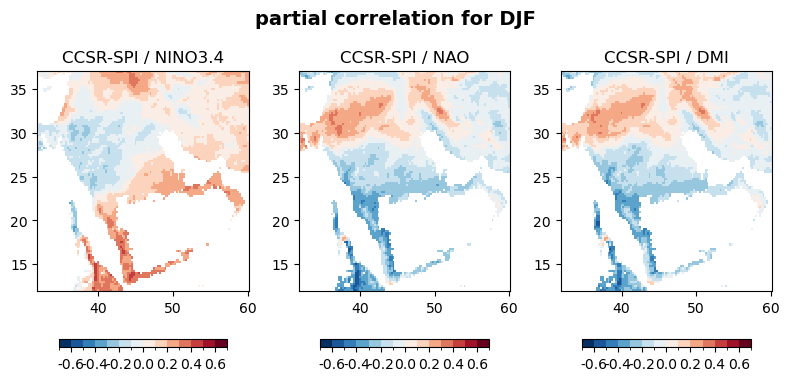

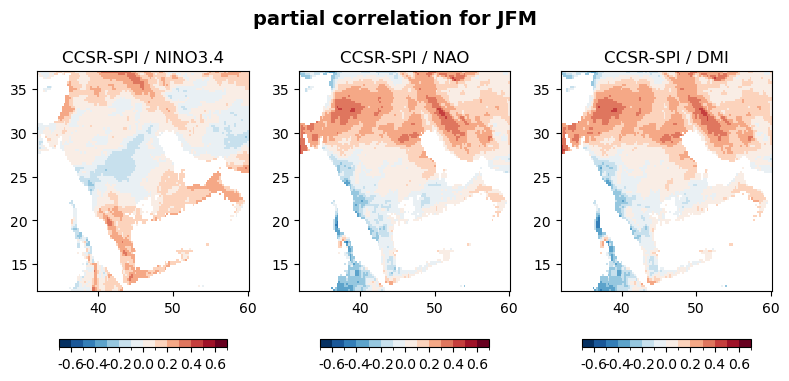

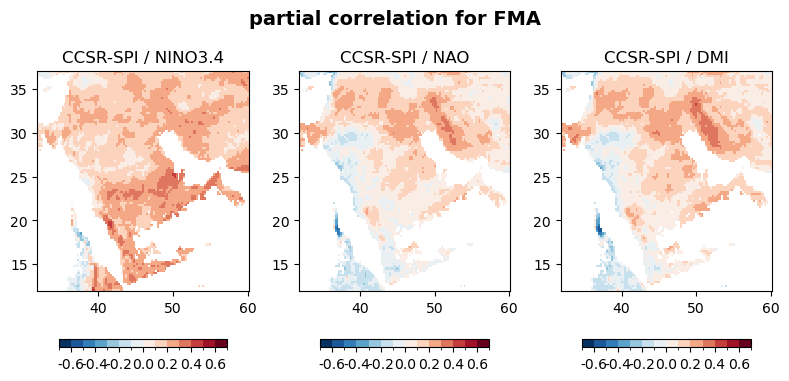

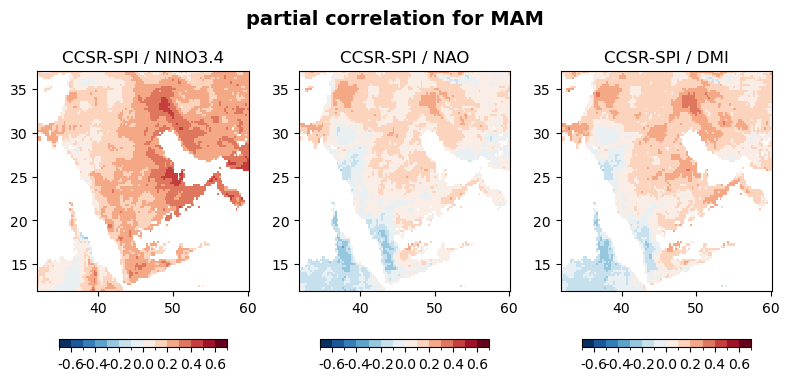

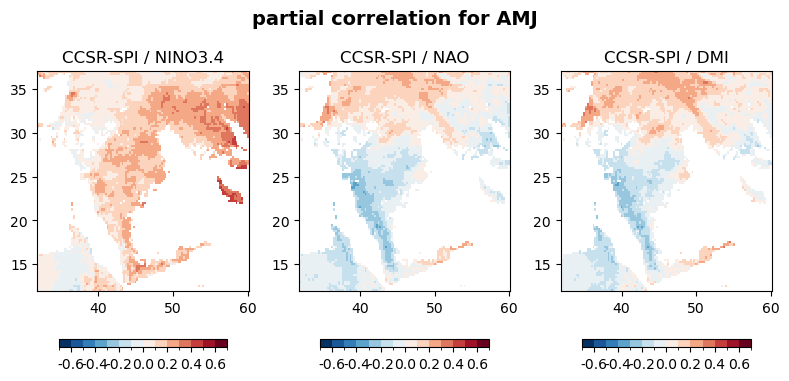

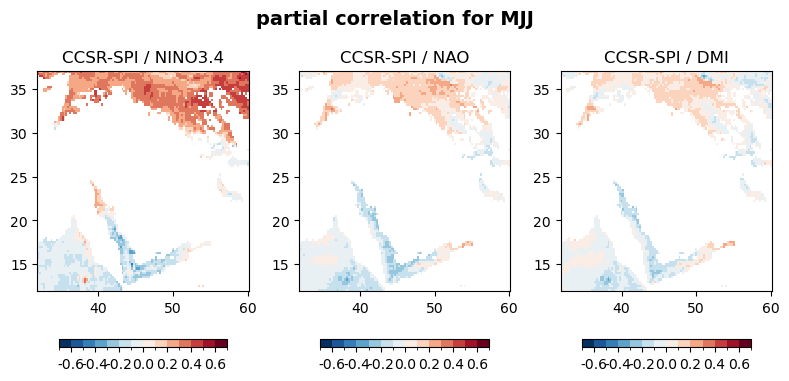

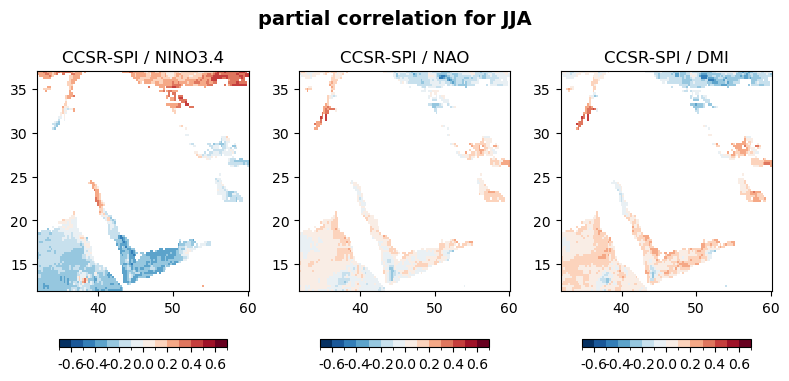

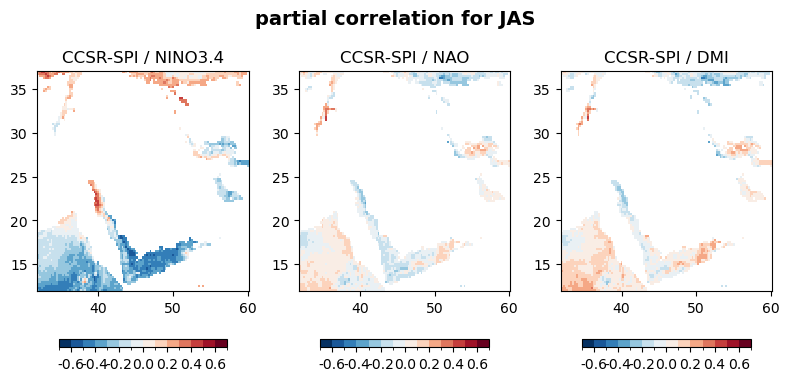

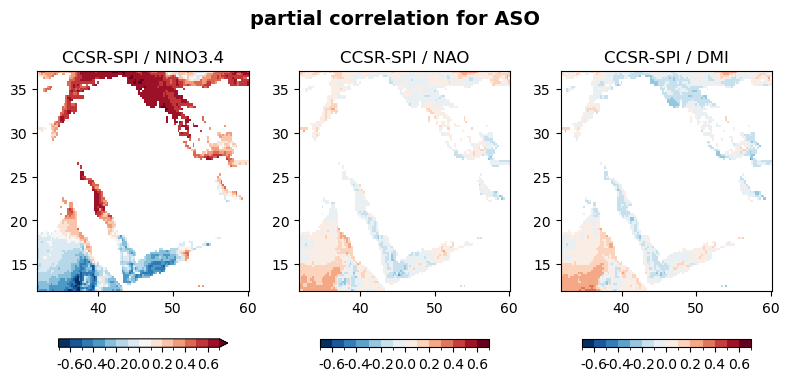

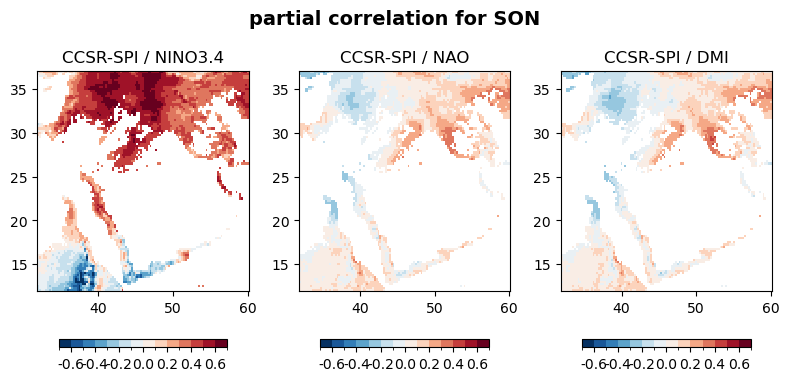

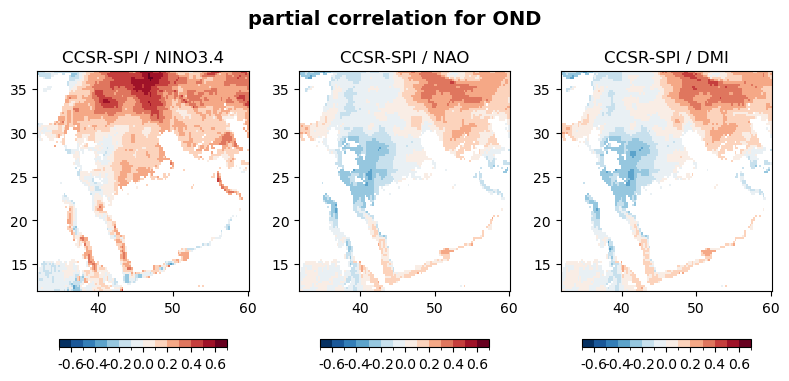

In [42]:

corr_type = 'partial'
# Compute the gridwise correlation between KAUST, CAMS, and SPI
corr_ds = compute_gridwise_correlation(data, 'NAO', 'NINO', 'DMI', 'custom_SPI',corr_type=corr_type)

levels = [-0.8,-0.6,-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.8]

cbar_kwargs = {'shrink': 0.8, 'label': '', 'orientation': 'horizontal','format':'%.1f'}
# Plot the gridwise correlation for each month (var1 vs var2)
for month in range(1, 13):
    month_names = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
    month_name = month_names[month - 1]
    plt.figure(figsize=(8, 4))

    # Plot correlation between KAUST and CAMS
    plt.subplot(1, 3, 1)
    corr_map = corr_ds[f'corr_NINO_custom_SPI_month_{month}']
    corr_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NINO3.4')

    # Plot correlation between KAUST and SPI
    plt.subplot(1, 3, 2)
    corr_map = corr_ds[f'corr_NAO_custom_SPI_month_{month}']
    corr_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NAO')

    # # Plot correlation between CAMS and SPI
    plt.subplot(1, 3, 3)
    corr_map = corr_ds[f'corr_DMI_custom_SPI_month_{month}']
    corr_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / DMI')

    for ax in plt.gcf().axes:
        ax.set(xlabel='', ylabel='')
    plt.suptitle(f'{corr_type} correlation for {month_name}', fontsize=14,fontweight='bold')
    plt.tight_layout()
    plt.show()

C:\Users\emile\AppData\Local\Temp\ipykernel_7948\716891044.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


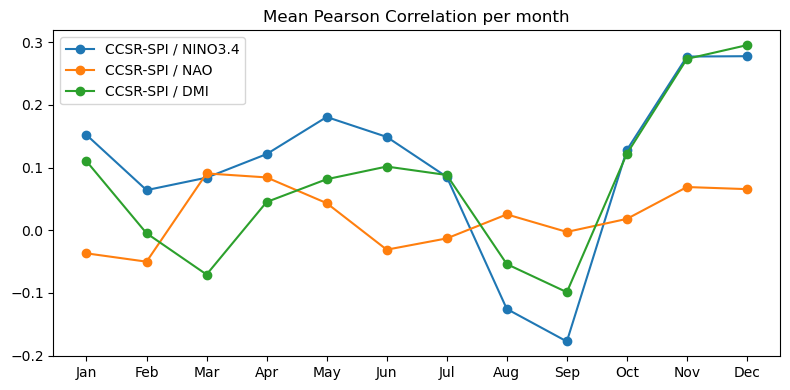

In [43]:
corr_nino = np.zeros(12)
corr_nao = np.zeros(12)
corr_dmi = np.zeros(12)

months = np.arange(1, 13)

for month in months:
    data_month = data.where(data['T'].dt.month == month, drop=True)

    corr_mat_nino = xr.corr(data_month['custom_SPI'], data_month['NINO'], dim='T')
    corr_mat_nao= xr.corr(data_month['custom_SPI'], data_month['NAO'], dim='T')
    corr_mat_dmi= xr.corr(data_month['custom_SPI'], data_month['DMI'], dim='T')
    #corr_mat_ccsr_nino = xr.corr(data_month['custom_SPI'], data_month['NINO'], dim='T')


    corr_nino[month-1] = xr.where(np.isinf(corr_mat_nino), np.nan, corr_mat_nino).mean()
    corr_nao[month-1] = xr.where(np.isinf(corr_mat_nao), np.nan, corr_mat_nao).mean()
    corr_dmi[month-1] = xr.where(np.isinf(corr_mat_dmi), np.nan, corr_mat_dmi).mean()
    #corr_ccsr_nino[month-1] = xr.where(np.isinf(corr_mat_ccsr_nino), np.nan, corr_mat_ccsr_nino).mean()


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

#dataframe with correlation values
df = pd.DataFrame({'Month': months, 'CCSR-SPI / NINO3.4': corr_nino,
                     'CCSR-SPI / NAO': corr_nao, 'CCSR-SPI / DMI': corr_dmi})


#bar plot
#df.plot(x='Month', kind='bar', ax=ax)

# # Plot the correlation values
#ax.plot(months, corr_kaust_custom, label='KAUST-SPI / CCSR-SPI', marker='o')
ax.plot(months, corr_nino, label='CCSR-SPI / NINO3.4', marker='o')
ax.plot(months, corr_nao, label='CCSR-SPI / NAO', marker='o')
ax.plot(months, corr_dmi, label='CCSR-SPI / DMI', marker='o')

#ticks every month
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_xticks(months)
plt.legend()
plt.title('Mean Pearson Correlation per month')
plt.tight_layout()

##  OLS betas

In [ ]:
def compute_gridwise_betas(data,estimator='OLS'):
    # Ensure the time coordinate is in datetime format and extract the month
    if data['T'].dtype != 'datetime64[ns]':
        data['T'] = pd.to_datetime(data['T'].values, format='%Y-%m')
    months = data['T'].dt.month

    # Prepare an empty dataset to store the R2 scores for each month
    beta_ds = xr.Dataset()

    # Loop over each month
    for month in range(1, 13):  # Adjust range(1, 13) for all 12 months
        print(f'Computing beta for month {month}')
        # Select data for the specific month
        monthly_data = data.where(months == month, drop=True)

        # Initialize R2 storage arrays for each variable at each grid point
        beta_storage1 = np.full((data.Y.size, data.X.size), np.nan)
        beta_storage2 = np.full((data.Y.size, data.X.size), np.nan)
        beta_storage3 = np.full((data.Y.size, data.X.size), np.nan)

        # Loop through each grid point
        X_grid = monthly_data['X'].values
        Y_grid = monthly_data['Y'].values

        for i, j in itertools.product(range(data.X.size), range(data.Y.size)):
                nino = monthly_data['NINO'].values.reshape(-1,1)
                nao = monthly_data['NAO'].values.reshape(-1,1)
                dmi = monthly_data['DMI'].values.reshape(-1,1)
                predictors = np.concatenate((nino, nao,dmi), axis=1)
                X = predictors
                y = monthly_data['custom_SPI'].sel(X=X_grid[i], Y=Y_grid[j]).values

                # Check if there are enough valid data points
                if np.isnan(y).all():
                    continue
                else:
                    if estimator == 'OLS':
                        model = LinearRegression()
                    elif estimator == 'PLS':
                        model = PLSRegression(n_components=3)
                    
                    if not np.isnan(y).all():
                        #drop na 
                        y1_dropna = y[~np.isnan(y)]
                        X1_dropna = X[~np.isnan(y)]
                        betas = model.fit(X1_dropna, y1_dropna).coef_
                        beta_storage1[j, i] = betas[0]
                        beta_storage2[j, i] = betas[1]
                        beta_storage3[j, i] = betas[2]


        # Store the R2 results in the dataset using X and Y coordinates from the first variable
        beta_ds[f'beta_NINO_month_{month}'] = xr.DataArray(beta_storage1, coords=[data.Y, data.X], dims=["Y", "X"])
        beta_ds[f'beta_NAO_month_{month}'] = xr.DataArray(beta_storage2, coords=[data.Y, data.X], dims=["Y", "X"])
        beta_ds[f'beta_DMI_month_{month}'] = xr.DataArray(beta_storage3, coords=[data.Y, data.X], dims=["Y", "X"])

    return beta_ds

In [ ]:
beta_ds = compute_gridwise_betas(data,estimator='OLS')

Computing R2 for month 1
Computing R2 for month 2
Computing R2 for month 3
Computing R2 for month 4
Computing R2 for month 5
Computing R2 for month 6
Computing R2 for month 7
Computing R2 for month 8
Computing R2 for month 9
Computing R2 for month 10
Computing R2 for month 11
Computing R2 for month 12


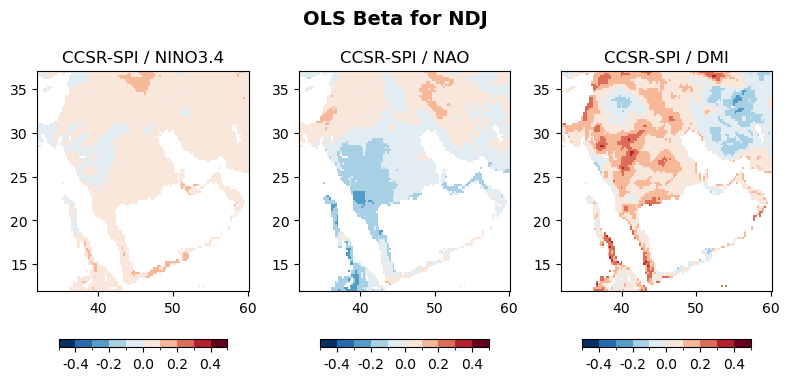

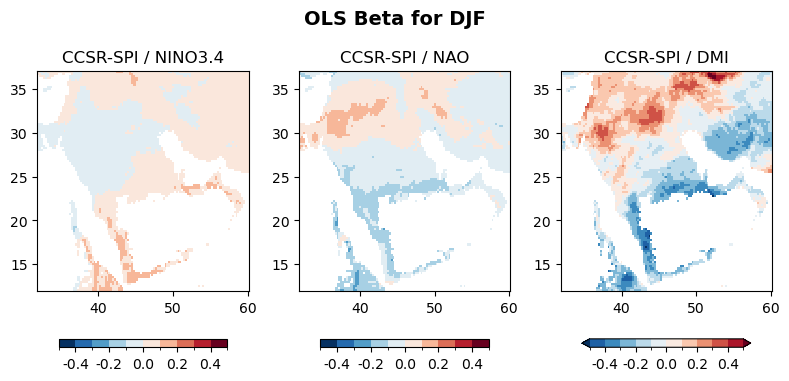

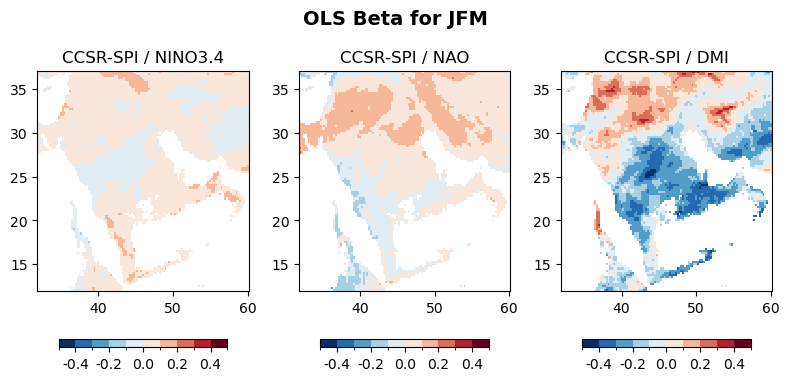

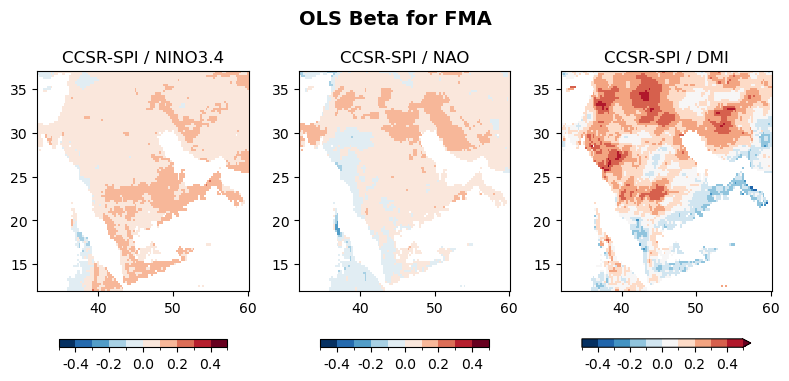

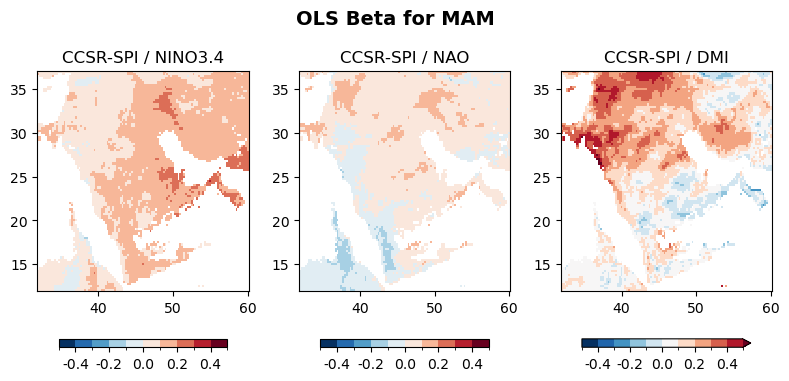

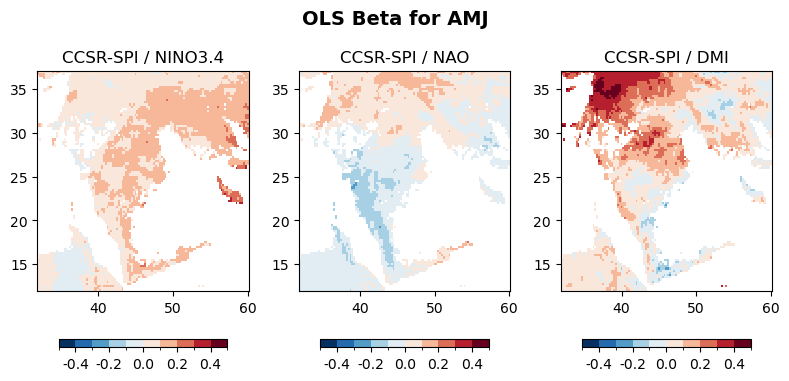

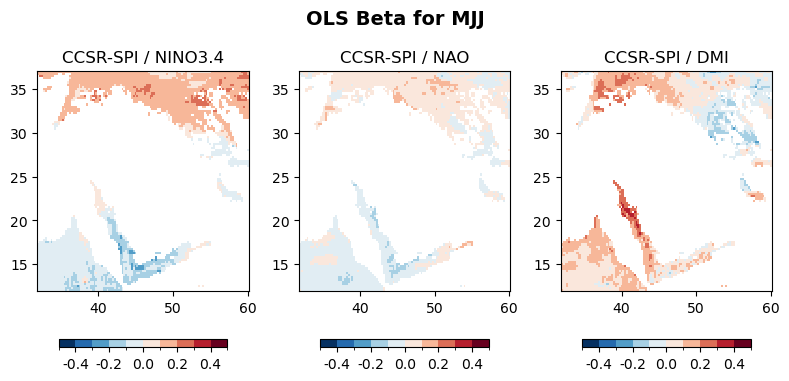

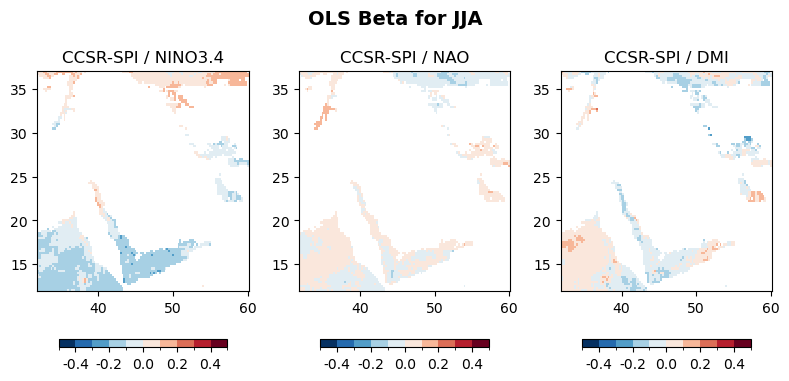

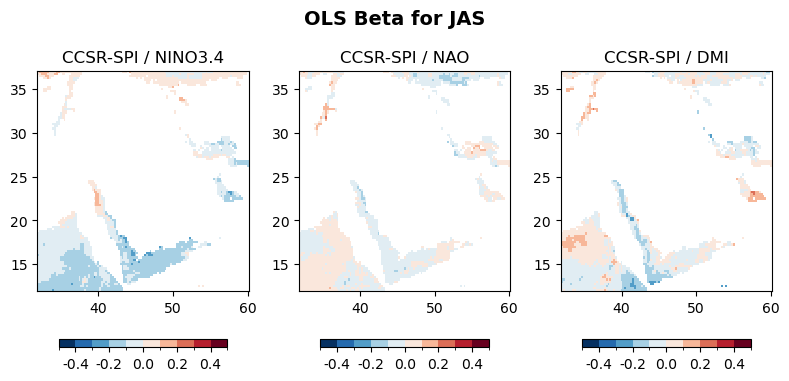

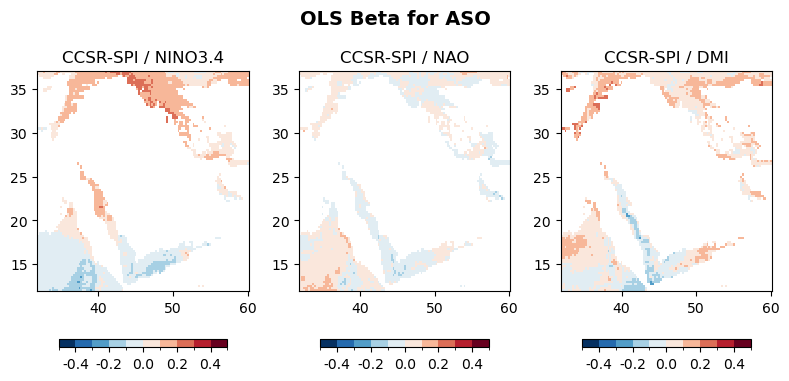

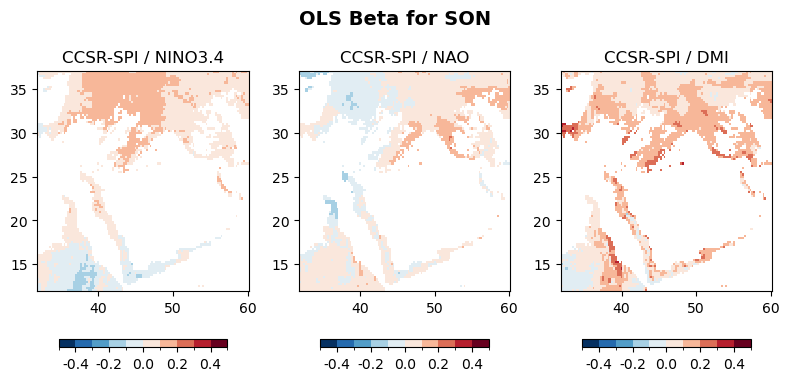

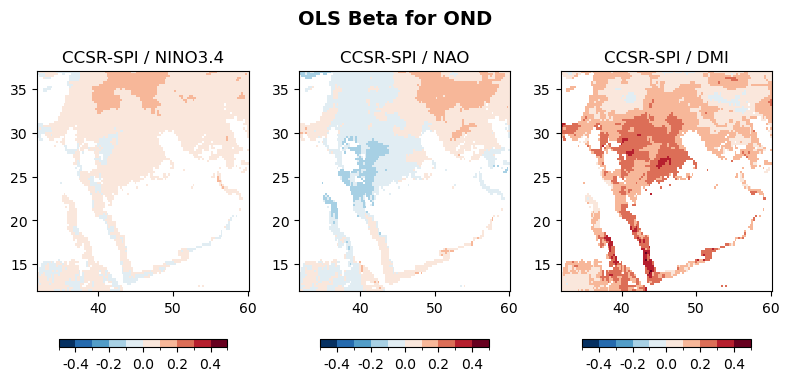

In [ ]:

# Plot the gridwise R2 scores for each month
levels = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]

cbar_kwargs = {'shrink': 0.8, 'label': '', 'orientation': 'horizontal','format':'%.1f'}
# Plot the gridwise correlation for each month (var1 vs var2)
for month in range(1, 13):
    month_names = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
    month_name = month_names[month - 1]
    plt.figure(figsize=(8, 4))

    # Plot correlation between KAUST and CAMS
    plt.subplot(1, 3, 1)
    beta_map = beta_ds[f'beta_NINO_month_{month}']
    beta_map.plot(cmap='RdBu_r', add_colorbar=True, cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NINO3.4')

    # Plot correlation between KAUST and SPI
    plt.subplot(1, 3, 2)
    beta_map = beta_ds[f'beta_NAO_month_{month}']
    beta_map.plot(cmap='RdBu_r', add_colorbar=True, cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NAO')

    # # Plot correlation between CAMS and SPI
    plt.subplot(1, 3, 3)
    beta_map = beta_ds[f'beta_DMI_month_{month}']
    beta_map.plot(cmap='RdBu_r', add_colorbar=True, cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / DMI')

    for ax in plt.gcf().axes:
        ax.set(xlabel='', ylabel='')
    plt.suptitle(f'OLS Beta for {month_name}', fontsize=14,fontweight='bold')
    plt.tight_layout()
    plt.show()

## PLS Beta

In [ ]:
beta_ds_pls = compute_gridwise_betas(data, estimator='PLS')

Computing PCR betas for month 1
Computing PCR betas for month 2
Computing PCR betas for month 3
Computing PCR betas for month 4
Computing PCR betas for month 5
Computing PCR betas for month 6
Computing PCR betas for month 7
Computing PCR betas for month 8
Computing PCR betas for month 9
Computing PCR betas for month 10
Computing PCR betas for month 11
Computing PCR betas for month 12


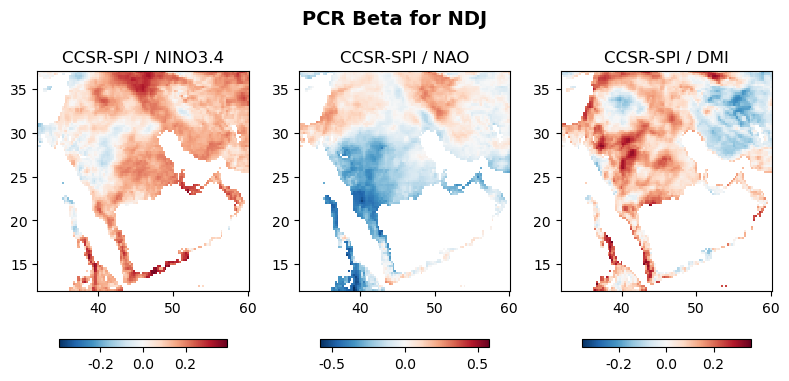

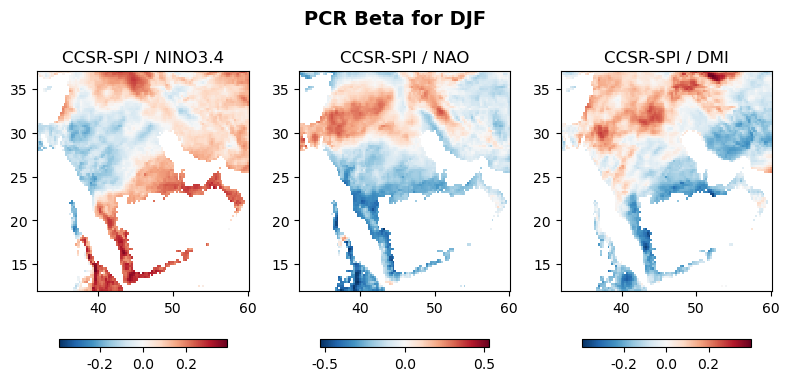

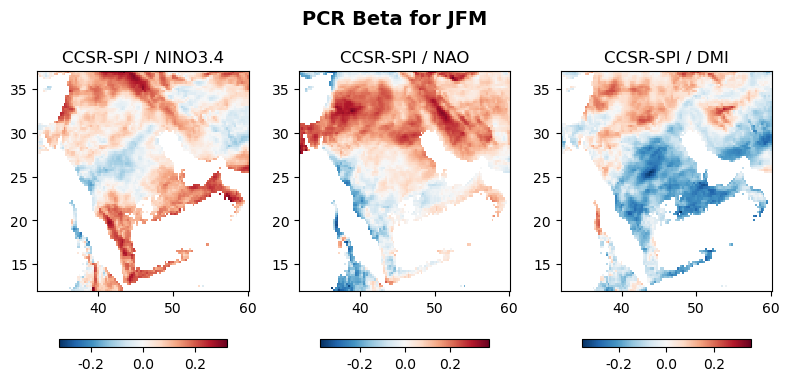

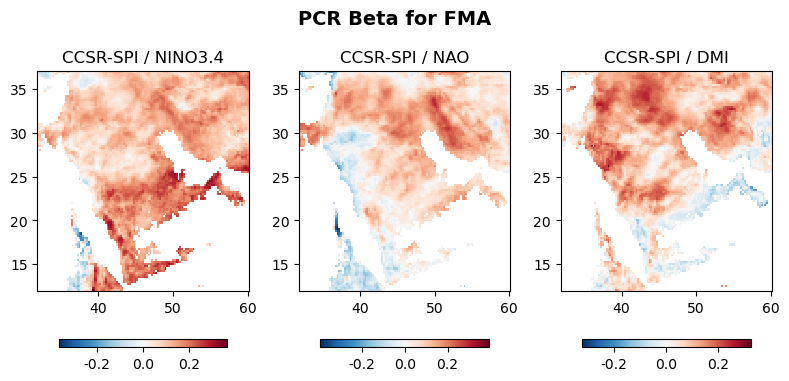

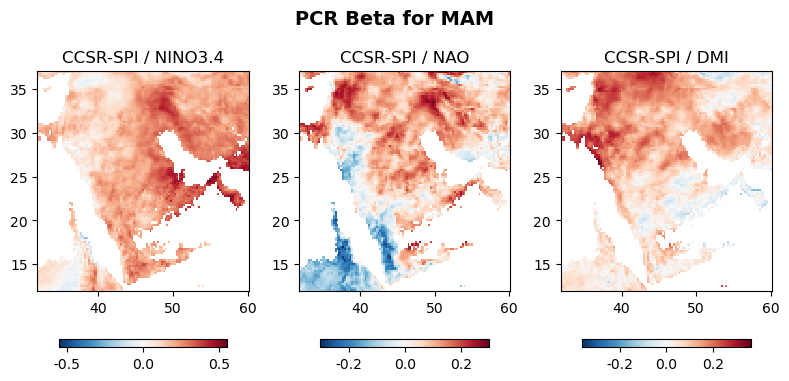

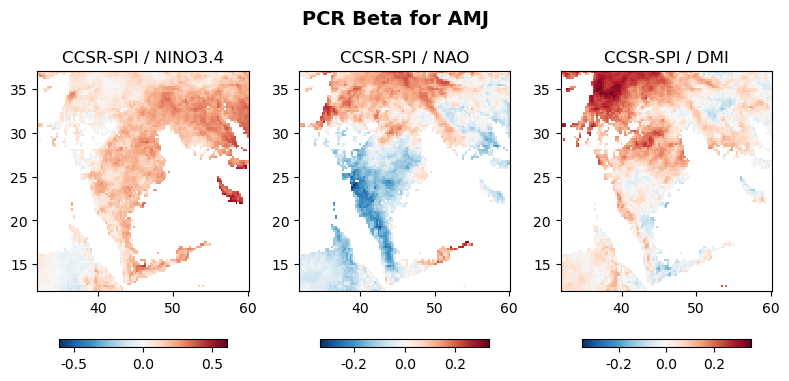

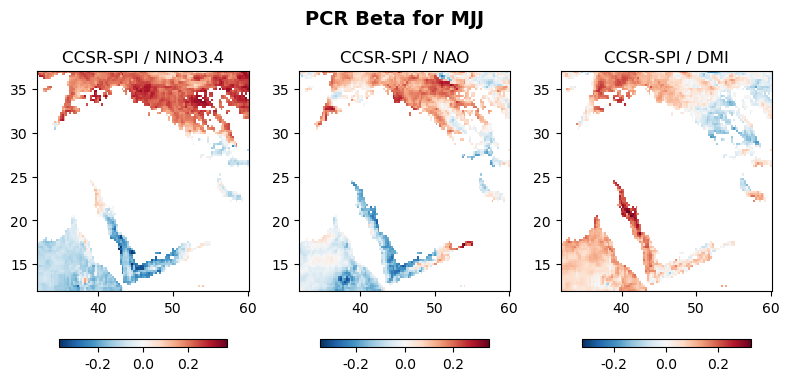

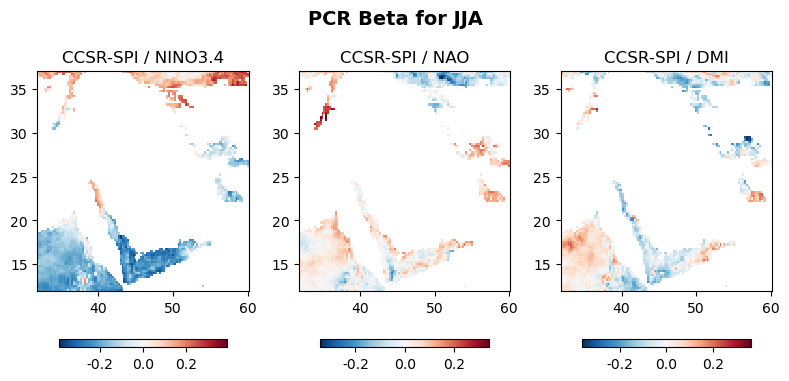

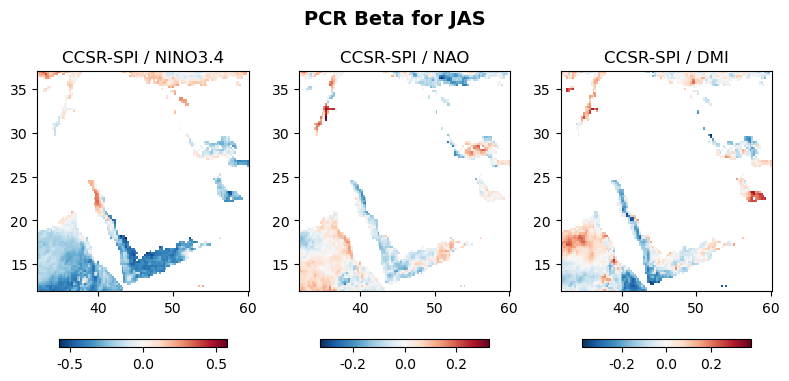

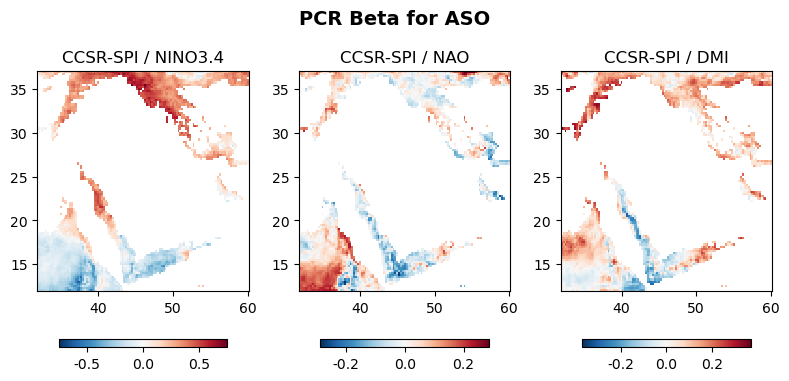

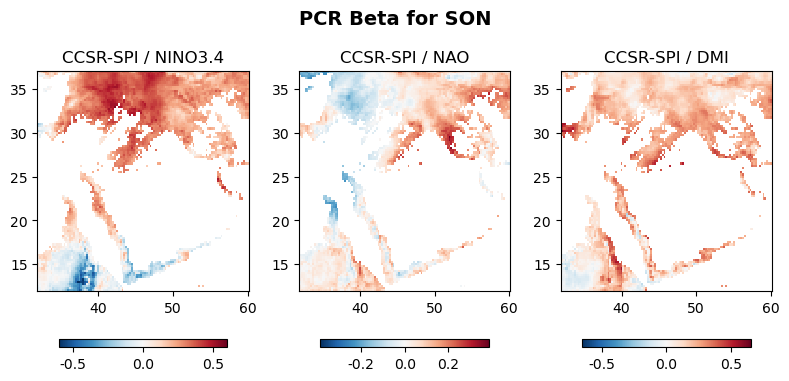

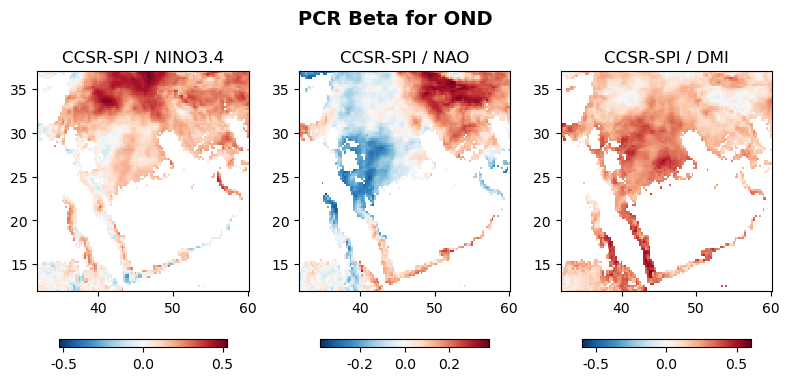

In [ ]:

# Plot the gridwise R2 scores for each month
levels = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]

cbar_kwargs = {'shrink': 0.8, 'label': '', 'orientation': 'horizontal','format':'%.1f'}
# Plot the gridwise correlation for each month (var1 vs var2)
for month in range(1, 13):
    month_names = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
    month_name = month_names[month - 1]
    plt.figure(figsize=(8, 4))

    # Plot correlation between KAUST and CAMS
    plt.subplot(1, 3, 1)
    beta_map = beta_ds_pls[f'beta_NINO_month_{month}']
    beta_map.plot( cmap='RdBu_r', add_colorbar=True,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NINO3.4')

    # Plot correlation between KAUST and SPI
    plt.subplot(1, 3, 2)
    beta_map = beta_ds_pls[f'beta_NAO_month_{month}']
    beta_map.plot( cmap='RdBu_r', add_colorbar=True,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NAO')

    # # Plot correlation between CAMS and SPI
    plt.subplot(1, 3, 3)
    beta_map = beta_ds_pls[f'beta_DMI_month_{month}']
    beta_map.plot(cmap='RdBu_r', add_colorbar=True,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / DMI')

    for ax in plt.gcf().axes:
        ax.set(xlabel='', ylabel='')
    plt.suptitle(f'PCR Beta for {month_name}', fontsize=14,fontweight='bold')
    plt.tight_layout()
    plt.show()

## OLS Forecast R2

In [134]:
def compute_gridwise_r2(data, n_folds=3,estimator="OLS"):
    # Ensure the time coordinate is in datetime format and extract the month
    if data['T'].dtype != 'datetime64[ns]':
        data['T'] = pd.to_datetime(data['T'].values, format='%Y-%m')
    months = data['T'].dt.month

    # Prepare an empty dataset to store the R2 scores for each month
    r2_ds = xr.Dataset()

    # Loop over each month
    for month in range(1, 13):  # Adjust range(1, 13) for all 12 months
        print(f'Computing R2 for month {month}')
        # Select data for the specific month
        monthly_data = data.where(months == month, drop=True)

        # Initialize R2 storage arrays for each variable at each grid point
        r2_storage1 = np.full((data.Y.size, data.X.size), np.nan)
        r2_storage2 = np.full((data.Y.size, data.X.size), np.nan)
        r2_storage3 = np.full((data.Y.size, data.X.size), np.nan)
        r2_storage4 = np.full((data.Y.size, data.X.size), np.nan)

        # Loop through each grid point
        X_grid = monthly_data['X'].values
        Y_grid = monthly_data['Y'].values

        #itetools product to iterate over all combinations of X and Y
        for i, j in itertools.product(range(len(X_grid)), range(len(Y_grid))):
                X1 = monthly_data['NINO'].values.reshape(-1,1)
                X2 = monthly_data['NAO'].values.reshape(-1,1)
                X3 = monthly_data['DMI'].values.reshape(-1,1)
                X = np.concatenate((X1, X2, X3), axis=1)

                y = monthly_data['custom_SPI'].sel(X=X_grid[i], Y=Y_grid[j]).values

                # Check if there are enough valid data points
                if np.isnan(y).all():
                    continue
                else:

                    linear_reg = LinearRegression()
                    pls_reg = PLSRegression(n_components=3)
                    
                    if not np.isnan(y).all():
                        #drop na 
                        y_dropna = y[~np.isnan(y)]
                        X1_dropna = X1[~np.isnan(y)].reshape(-1, 1)
                        X2_dropna = X2[~np.isnan(y)].reshape(-1, 1)
                        X3_dropna = X3[~np.isnan(y)].reshape(-1, 1)
                        X_dropna = X[~np.isnan(y)]

                        r2_1 = cross_val_score(linear_reg, X1_dropna, y_dropna, cv=n_folds, scoring='r2').mean()
                        r2_storage1[j, i] = r2_1
                        r2_2 = cross_val_score(linear_reg, X2_dropna, y_dropna, cv=n_folds, scoring='r2').mean()
                        r2_storage2[j, i] = r2_2
                        r2_3 = cross_val_score(linear_reg, X3_dropna, y_dropna, cv=n_folds, scoring='r2').mean()
                        r2_storage3[j, i] = r2_3
                        if estimator=="OLS":
                            r2 = cross_val_score(linear_reg, X_dropna, y_dropna, cv=n_folds, scoring='r2').mean()
                        elif estimator=="PLS":
                            r2 = cross_val_score(pls_reg, X_dropna, y_dropna, cv=n_folds, scoring='r2').mean()
                        r2_storage4[j, i] = r2


        # Store the R2 results in the dataset using X and Y coordinates from the first variable
        r2_ds[f'r2_NINO_month_{month}'] = xr.DataArray(r2_storage1, coords=[data.Y, data.X], dims=["Y", "X"])
        r2_ds[f'r2_NAO_month_{month}'] = xr.DataArray(r2_storage2, coords=[data.Y, data.X], dims=["Y", "X"])
        r2_ds[f'r2_DMI_month_{month}'] = xr.DataArray(r2_storage3, coords=[data.Y, data.X], dims=["Y", "X"])
        r2_ds[f'r2_all_month_{month}'] = xr.DataArray(r2_storage4, coords=[data.Y, data.X], dims=["Y", "X"])

    return r2_ds


In [130]:
# Compute the gridwise R2 scores for each month
r2_ds = compute_gridwise_r2(data, n_folds=3, estimator="OLS")

Computing R2 for month 1
Computing R2 for month 2
Computing R2 for month 3
Computing R2 for month 4
Computing R2 for month 5
Computing R2 for month 6
Computing R2 for month 7
Computing R2 for month 8
Computing R2 for month 9
Computing R2 for month 10
Computing R2 for month 11
Computing R2 for month 12


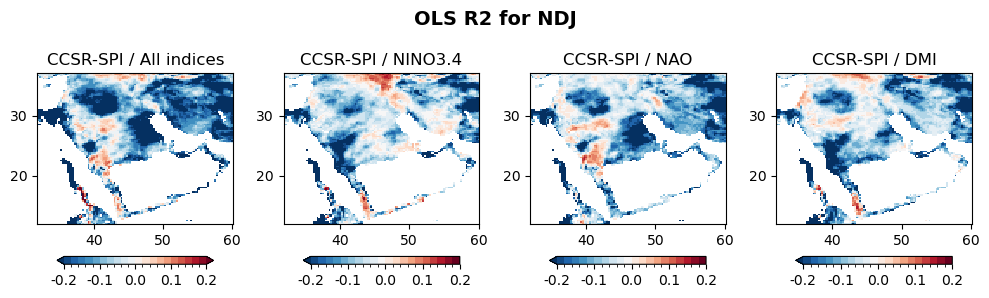

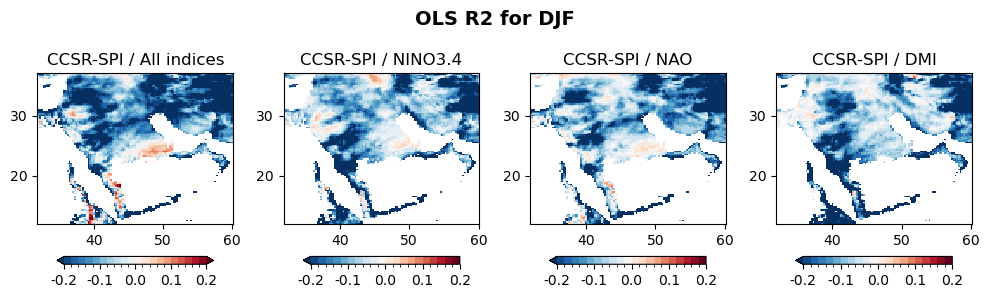

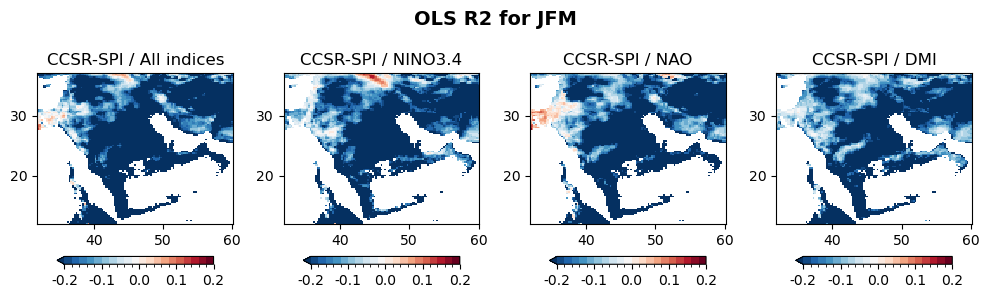

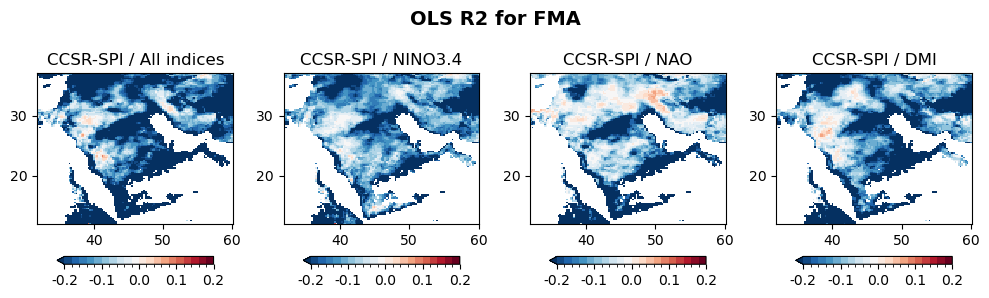

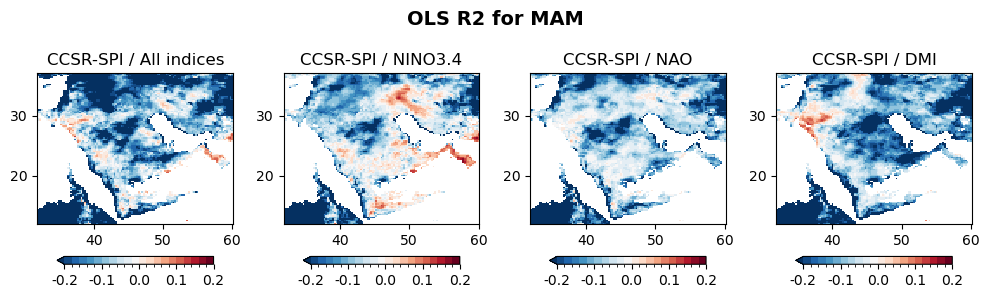

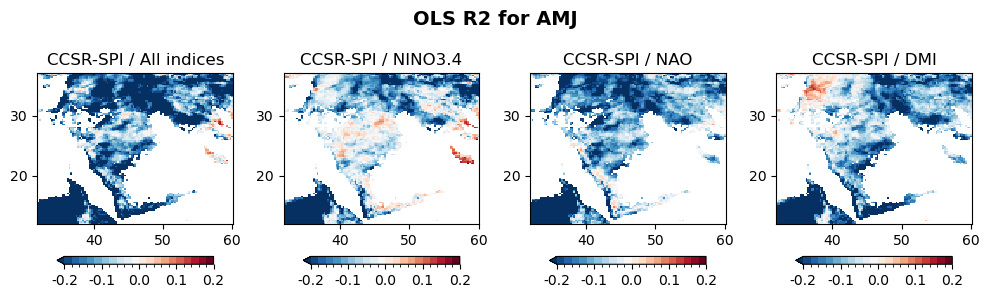

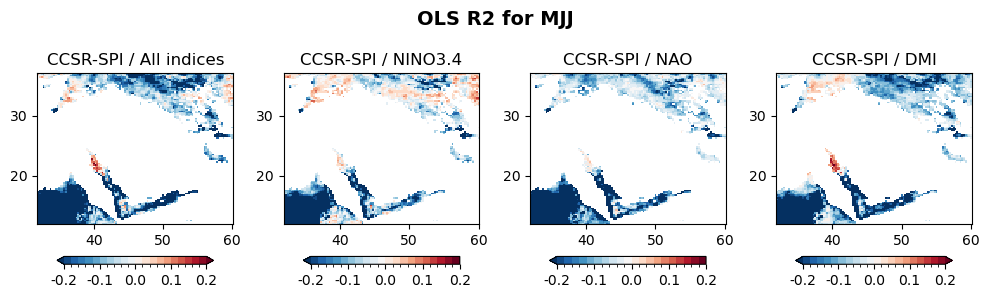

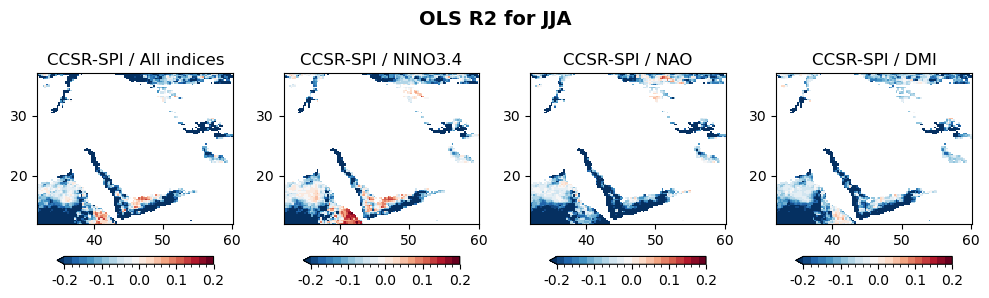

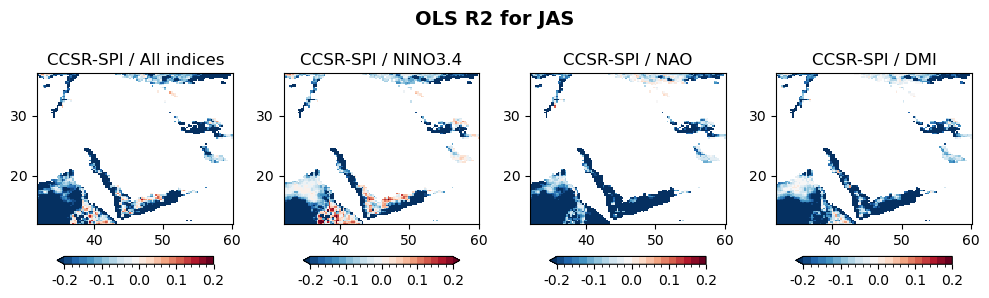

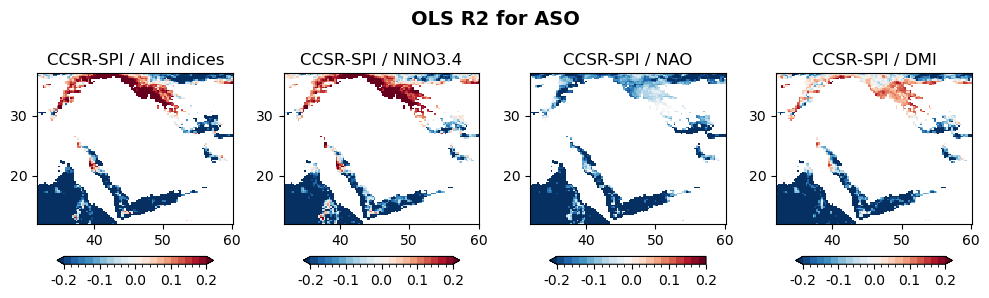

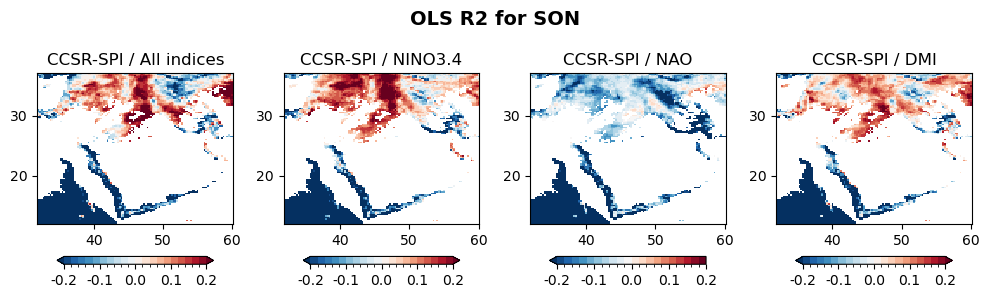

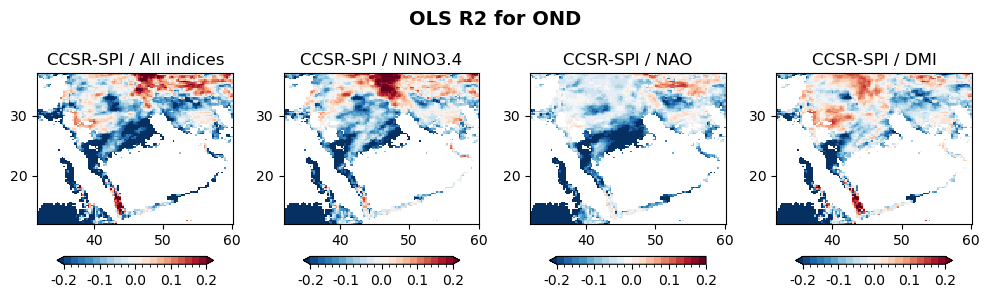

In [131]:

vmin = -0.2
vmax = 0.2
#clip values below 0.2 

levels = 21
cbar_kwargs = {'shrink': 0.8, 'label': '', 'orientation': 'horizontal','format':'%.1f', "spacing":'proportional', "ticks":[-0.2,-0.1,0,0.1,0.2]}

# Plot the gridwise correlation for each month (var1 vs var2)
for month in range(1, 13):
    month_names = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
    month_name = month_names[month - 1]
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 4, 1)
    r2_map = r2_ds[f'r2_all_month_{month}']
    r2_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / All indices')

    plt.subplot(1, 4, 2)
    r2_map = r2_ds[f'r2_NINO_month_{month}']
    r2_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NINO3.4')

    plt.subplot(1, 4, 3)
    r2_map = r2_ds[f'r2_NAO_month_{month}']
    r2_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NAO')

    plt.subplot(1, 4, 4)
    r2_map = r2_ds[f'r2_DMI_month_{month}']
    r2_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / DMI')

    #remove X and Y labels
    for ax in plt.gcf().axes:
        ax.set(xlabel='', ylabel='')
    plt.suptitle(f'OLS R2 for {month_name}', fontsize=14,fontweight='bold')
    plt.tight_layout()
    plt.show()

## PLS Forecast R2

In [135]:
# Compute the gridwise R2 scores for each month
r2_ds_pls = compute_gridwise_r2(data, n_folds=3, estimator="PLS")

Computing R2 for month 1
Computing R2 for month 2
Computing R2 for month 3
Computing R2 for month 4
Computing R2 for month 5
Computing R2 for month 6
Computing R2 for month 7
Computing R2 for month 8
Computing R2 for month 9
Computing R2 for month 10
Computing R2 for month 11
Computing R2 for month 12


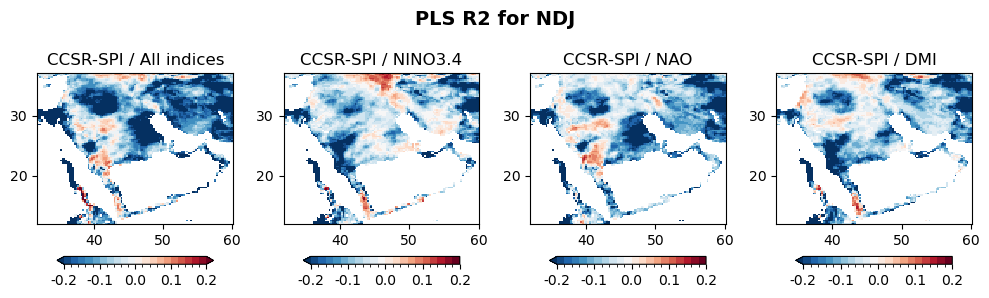

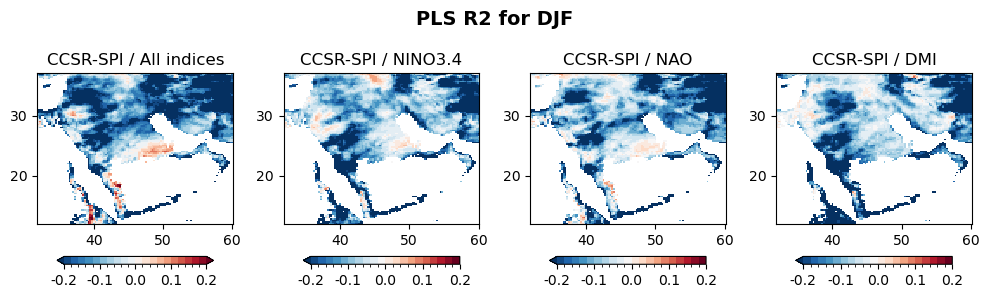

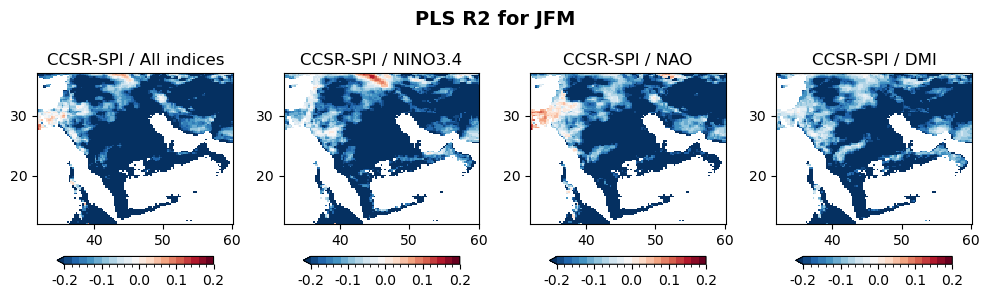

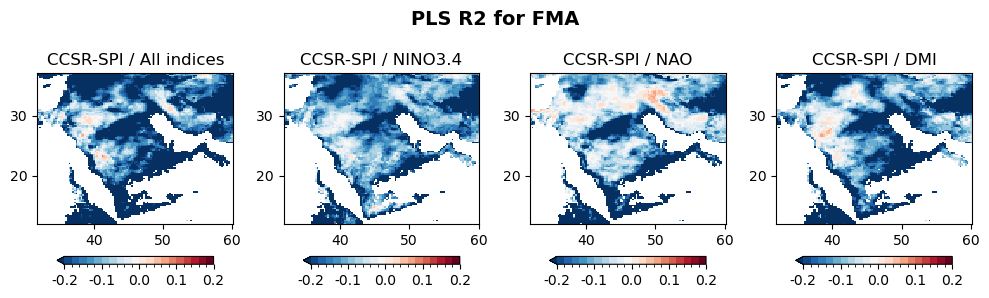

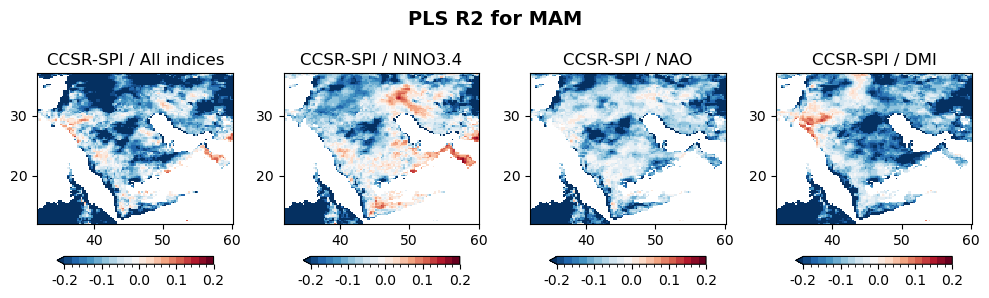

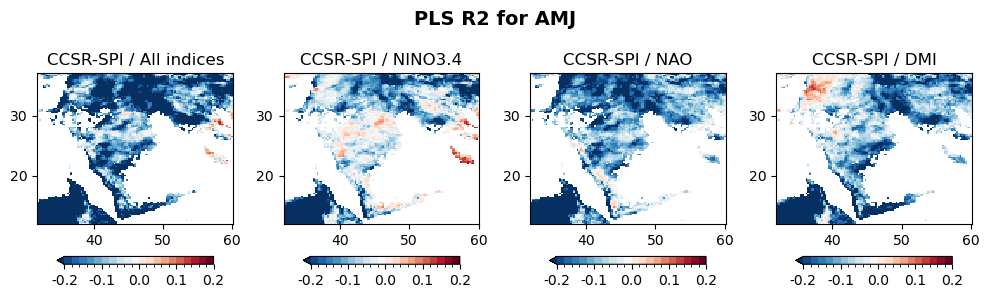

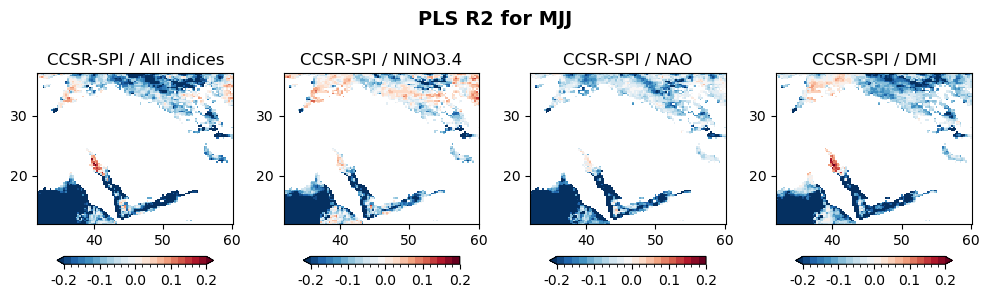

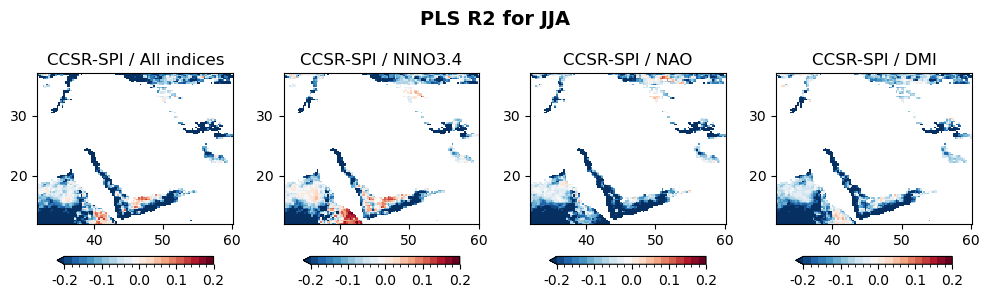

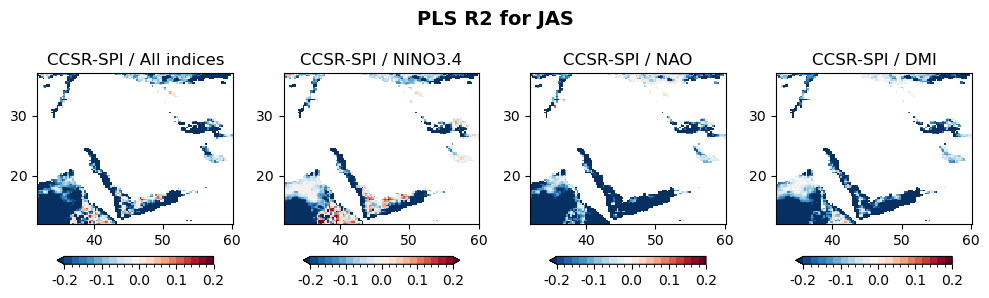

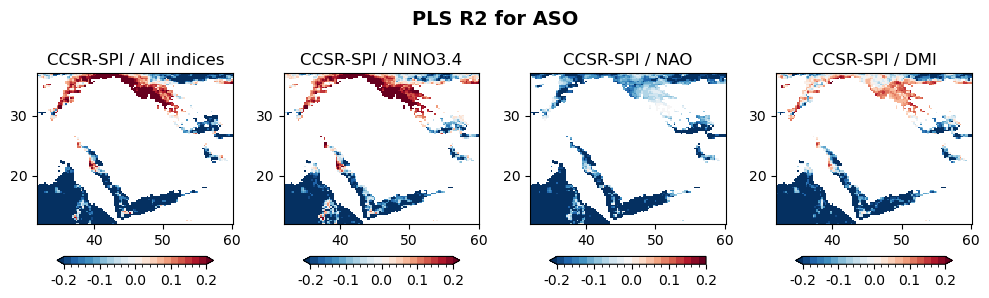

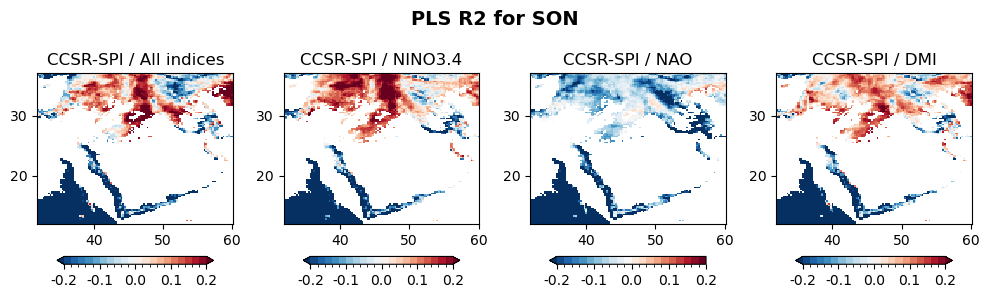

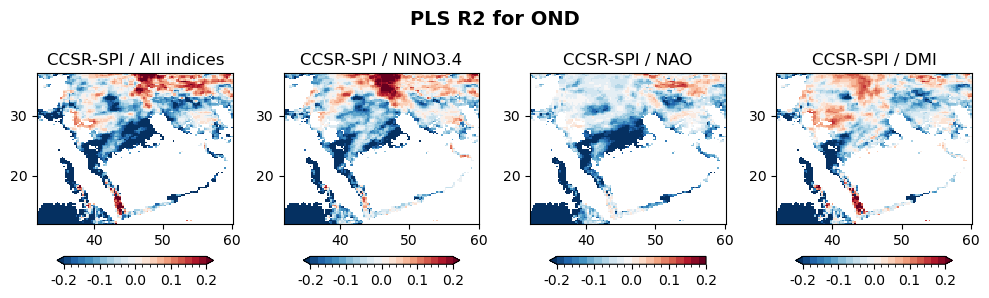

In [136]:
vmin = -0.2
vmax = 0.2
levels = 21
cbar_kwargs = {'shrink': 0.8, 'label': '', 'orientation': 'horizontal','format':'%.1f', "spacing":'proportional', "ticks":[-0.2,-0.1,0,0.1,0.2]}

# Plot the gridwise correlation for each month (var1 vs var2)
for month in range(1, 13):
    month_names = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
    month_name = month_names[month - 1]
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 4, 1)
    r2_map = r2_ds_pls[f'r2_all_month_{month}']
    r2_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / All indices')

    plt.subplot(1, 4, 2)
    r2_map = r2_ds_pls[f'r2_NINO_month_{month}']
    r2_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NINO3.4')

    plt.subplot(1, 4, 3)
    r2_map = r2_ds_pls[f'r2_NAO_month_{month}']
    r2_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NAO')

    plt.subplot(1, 4, 4)
    r2_map = r2_ds_pls[f'r2_DMI_month_{month}']
    r2_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / DMI')

    #remove X and Y labels
    for ax in plt.gcf().axes:
        ax.set(xlabel='', ylabel='')
    plt.suptitle(f'PLS R2 for {month_name}', fontsize=14,fontweight='bold')
    plt.tight_layout()
    plt.show()